In [61]:
import os
import re
import json
import pickle
import random
import warnings
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import files
from google.colab import drive

warnings.filterwarnings("ignore")

In [62]:
# –ü—É—Ç–∏ –∫ –¥–∞–Ω–Ω—ã–º
house_path = "/content/data/house_dataset.csv"
antagonists_path = "/content/data/antagonists_dataset.csv"

# –ó–∞–≥—Ä—É–∑–∫–∞ –¥–∞–Ω–Ω—ã—Ö
house_df = pd.read_csv(house_path)
antagonists_df = pd.read_csv(antagonists_path)

# –í—ã–≤–æ–¥ –ø–µ—Ä–≤—ã—Ö —Å—Ç—Ä–æ–∫ –¥–ª—è –ø—Ä–æ–≤–µ—Ä–∫–∏
print("–ü–µ—Ä–≤—ã–µ —Å—Ç—Ä–æ–∫–∏ –¥–∞—Ç–∞—Å–µ—Ç–∞ –î–æ–∫—Ç–æ—Ä–∞ –•–∞—É—Å–∞:")
print(house_df.head())

print("–ü–µ—Ä–≤—ã–µ —Å—Ç—Ä–æ–∫–∏ –¥–∞—Ç–∞—Å–µ—Ç–∞ –∞–Ω—Ç–∞–≥–æ–Ω–∏—Å—Ç–æ–≤:")
print(antagonists_df.head())

–ü–µ—Ä–≤—ã–µ —Å—Ç—Ä–æ–∫–∏ –¥–∞—Ç–∞—Å–µ—Ç–∞ –î–æ–∫—Ç–æ—Ä–∞ –•–∞—É—Å–∞:
    name  season                                      previous_line  \
0  house       1  Fair enough. I dont like healthy Patients. The...   
1  house       1  Shouldnt we be speaking to the Patient before ...   
2  house       1                                           No, but!   
3  house       1      Isnt treating Patients why we became doctors?   
4  house       1                                           Mad cow?   

  previous_speaker                                       context_long  \
0           wilson  See that? They all assume Im a Patient because...   
1          foreman  And shes not responding to radiation treatment...   
2          foreman  Come on! Why leave all the fun for the coroner...   
3          foreman  Shouldnt we be speaking to the Patient before ...   
4            chase  First year of medical school if you hear hoof ...   

   is_greeting  is_question  is_negation  is_exclamation  is_sar

In [63]:
import re
import pandas as pd

def clean_text(text):
    """–û—á–∏—Å—Ç–∫–∞ —Ç–µ–∫—Å—Ç–∞ –æ—Ç –ø—Ä–æ–±–ª–µ–º–Ω—ã—Ö —Å–∏–º–≤–æ–ª–æ–≤, –ª–∏—à–Ω–∏—Ö –ø—Ä–æ–±–µ–ª–æ–≤ –∏ –º—É—Å–æ—Ä–∞."""
    if not isinstance(text, str) or len(text) == 0:
        return ""

    text = text.replace("ÔøΩ", "")  # –£–¥–∞–ª–µ–Ω–∏–µ –Ω–µ–∏–∑–≤–µ—Å—Ç–Ω—ã—Ö —Å–∏–º–≤–æ–ª–æ–≤
    text = re.sub(r"\s+", " ", text).strip()  # –£–±–∏—Ä–∞–µ–º –ª–∏—à–Ω–∏–µ –ø—Ä–æ–±–µ–ª—ã
    text = re.sub(r"[^\x00-\x7F]+", "", text)  # –£–¥–∞–ª—è–µ–º –ª—é–±—ã–µ –Ω–µ-ASCII —Å–∏–º–≤–æ–ª—ã (–µ—Å–ª–∏ –µ—Å—Ç—å)

    return text

def additional_cleaning(text):
    """–î–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω–∞—è –æ—á–∏—Å—Ç–∫–∞ —Å —É—á–µ—Ç–æ–º —á–∏—Å–µ–ª, –ø—Ä–æ—Ü–µ–Ω—Ç–æ–≤, –¥—Ä–æ–±–µ–π –∏ —Å–ª—É—á–∞–π–Ω—ã—Ö –∑–∞–≥–ª–∞–≤–Ω—ã—Ö –±—É–∫–≤."""
    if not isinstance(text, str):
        return text

    # –†–∞–∑—Ä–µ—à–µ–Ω–Ω—ã–µ —Å–∏–º–≤–æ–ª—ã: –±—É–∫–≤—ã, —Ü–∏—Ñ—Ä—ã, –ø—Ä–æ–±–µ–ª—ã, –∑–Ω–∞–∫–∏ –ø—É–Ω–∫—Ç—É–∞—Ü–∏–∏, –ø—Ä–æ—Ü–µ–Ω—Ç—ã, –¥–æ–ª–ª–∞—Ä, –¥—Ä–æ–±–∏
    text = re.sub(r"[^\w\s.,!?'$/%-]", "", text)

    # –£–¥–∞–ª–µ–Ω–∏–µ –ª–∏—à–Ω–∏—Ö –ø—Ä–æ–±–µ–ª–æ–≤
    text = re.sub(r"\s+", " ", text).strip()

    # –ò—Å–ø—Ä–∞–≤–ª–µ–Ω–∏–µ —Å–ª—É—á–∞–π–Ω—ã—Ö –∑–∞–≥–ª–∞–≤–Ω—ã—Ö –±—É–∫–≤ –≤ —Å–µ—Ä–µ–¥–∏–Ω–µ —Å–ª–æ–≤–∞
    words = text.split()
    cleaned_words = []
    for word in words:
        if re.search(r"[A-Z][a-z]+[A-Z]", word):  # –ü—Ä–æ–≤–µ—Ä–∫–∞ —Å–ª—É—á–∞–π–Ω–æ–π –∑–∞–≥–ª–∞–≤–Ω–æ–π –±—É–∫–≤—ã –≤ —Å–µ—Ä–µ–¥–∏–Ω–µ —Å–ª–æ–≤–∞
            word = word.lower()
        cleaned_words.append(word)

    return " ".join(cleaned_words)

def apply_text_cleaning(df, text_columns):
    """–û—á–∏—Å—Ç–∫–∞ –≤—Å–µ—Ö —É–∫–∞–∑–∞–Ω–Ω—ã—Ö —Ç–µ–∫—Å—Ç–æ–≤—ã—Ö –∫–æ–ª–æ–Ω–æ–∫ –∏ —Å–±–æ—Ä —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏."""

    stats = {}

    for col in text_columns:
        initial_non_empty = df[col].notna().sum()  # –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–µ–ø—É—Å—Ç—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π –¥–æ –æ—á–∏—Å—Ç–∫–∏
        total_chars_before = df[col].dropna().apply(len).sum()  # –û–±—â–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å–∏–º–≤–æ–ª–æ–≤ –¥–æ –æ—á–∏—Å—Ç–∫–∏

        # –û—á–∏—Å—Ç–∫–∞
        df[col] = df[col].astype(str).apply(clean_text).apply(additional_cleaning)

        total_chars_after = df[col].dropna().apply(len).sum()  # –û–±—â–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å–∏–º–≤–æ–ª–æ–≤ –ø–æ—Å–ª–µ –æ—á–∏—Å—Ç–∫–∏
        cleaned_chars = total_chars_before - total_chars_after  # –£–¥–∞–ª–µ–Ω–æ —Å–∏–º–≤–æ–ª–æ–≤
        final_non_empty = df[col].notna().sum()  # –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–µ–ø—É—Å—Ç—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π –ø–æ—Å–ª–µ –æ—á–∏—Å—Ç–∫–∏

        stats[col] = {
            "–∏—Å—Ö–æ–¥–Ω—ã–µ —Å—Ç—Ä–æ–∫–∏": initial_non_empty,
            "–æ—á–∏—â–µ–Ω–Ω—ã–µ —Å—Ç—Ä–æ–∫–∏": final_non_empty,
            "—É–¥–∞–ª–µ–Ω–æ –ø—É—Å—Ç—ã—Ö —Å—Ç—Ä–æ–∫": initial_non_empty - final_non_empty,
            "–æ–±—â–∞—è –¥–ª–∏–Ω–∞ –¥–æ –æ—á–∏—Å—Ç–∫–∏": total_chars_before,
            "–æ–±—â–∞—è –¥–ª–∏–Ω–∞ –ø–æ—Å–ª–µ –æ—á–∏—Å—Ç–∫–∏": total_chars_after,
            "—É–¥–∞–ª–µ–Ω–æ —Å–∏–º–≤–æ–ª–æ–≤": cleaned_chars,
        }

    return df, stats

# –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –≤—Å–µ—Ö —Ç–µ–∫—Å—Ç–æ–≤—ã—Ö –∫–æ–ª–æ–Ω–æ–∫, –∫–æ—Ç–æ—Ä—ã–µ –Ω—É–∂–Ω–æ –æ—á–∏—Å—Ç–∏—Ç—å
text_columns_house = ["line", "previous_line", "context_1", "context_2", "context_3", "context_4", "context_5", "context_long"]
text_columns_antagonists = ["line"]

# –û—á–∏—Å—Ç–∫–∞ —Ç–µ–∫—Å—Ç–æ–≤—ã—Ö –∫–æ–ª–æ–Ω–æ–∫ –≤ –¥–∞—Ç–∞—Å–µ—Ç–µ –î–æ–∫—Ç–æ—Ä–∞ –•–∞—É—Å–∞ –∏ –ê–Ω—Ç–∞–≥–æ–Ω–∏—Å—Ç–æ–≤
house_df, house_stats = apply_text_cleaning(house_df, text_columns_house)
antagonists_df, antagonists_stats = apply_text_cleaning(antagonists_df, text_columns_antagonists)

# –í—ã–≤–æ–¥ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏ –¥–ª—è –î–æ–∫—Ç–æ—Ä–∞ –•–∞—É—Å–∞
print("\n–°–¢–ê–¢–ò–°–¢–ò–ö–ê –û–ß–ò–°–¢–ö–ò: –î–û–ö–¢–û–† –•–ê–£–°")
for col, stats in house_stats.items():
    print(f"\n–ö–æ–ª–æ–Ω–∫–∞: {col}")
    for key, value in stats.items():
        print(f"- {key}: {value}")

# –í—ã–≤–æ–¥ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏ –¥–ª—è –ê–Ω—Ç–∞–≥–æ–Ω–∏—Å—Ç–æ–≤
print("\n–°–¢–ê–¢–ò–°–¢–ò–ö–ê –û–ß–ò–°–¢–ö–ò: –ê–ù–¢–ê–ì–û–ù–ò–°–¢–´")
for col, stats in antagonists_stats.items():
    print(f"\n–ö–æ–ª–æ–Ω–∫–∞: {col}")
    for key, value in stats.items():
        print(f"- {key}: {value}")

# –ü—Ä–∏–º–µ—Ä—ã –∏–∑–º–µ–Ω–µ–Ω–∏–π –¥–æ –∏ –ø–æ—Å–ª–µ –æ—á–∏—Å—Ç–∫–∏
print("\n–ü–†–ò–ú–ï–†–´ –î–û –ò –ü–û–°–õ–ï –û–ß–ò–°–¢–ö–ò:")

for col in text_columns_house:
    sample_before = house_df[col].dropna().sample(1, random_state=42).values[0]
    sample_after = additional_cleaning(clean_text(sample_before))
    print(f"\n–ö–æ–ª–æ–Ω–∫–∞: {col}")
    print(f"–î–æ: {sample_before}")
    print(f"–ü–æ—Å–ª–µ: {sample_after}")



–°–¢–ê–¢–ò–°–¢–ò–ö–ê –û–ß–ò–°–¢–ö–ò: –î–û–ö–¢–û–† –•–ê–£–°

–ö–æ–ª–æ–Ω–∫–∞: line
- –∏—Å—Ö–æ–¥–Ω—ã–µ —Å—Ç—Ä–æ–∫–∏: 8557
- –æ—á–∏—â–µ–Ω–Ω—ã–µ —Å—Ç—Ä–æ–∫–∏: 8557
- —É–¥–∞–ª–µ–Ω–æ –ø—É—Å—Ç—ã—Ö —Å—Ç—Ä–æ–∫: 0
- –æ–±—â–∞—è –¥–ª–∏–Ω–∞ –¥–æ –æ—á–∏—Å—Ç–∫–∏: 625471
- –æ–±—â–∞—è –¥–ª–∏–Ω–∞ –ø–æ—Å–ª–µ –æ—á–∏—Å—Ç–∫–∏: 624772
- —É–¥–∞–ª–µ–Ω–æ —Å–∏–º–≤–æ–ª–æ–≤: 699

–ö–æ–ª–æ–Ω–∫–∞: previous_line
- –∏—Å—Ö–æ–¥–Ω—ã–µ —Å—Ç—Ä–æ–∫–∏: 8556
- –æ—á–∏—â–µ–Ω–Ω—ã–µ —Å—Ç—Ä–æ–∫–∏: 8557
- —É–¥–∞–ª–µ–Ω–æ –ø—É—Å—Ç—ã—Ö —Å—Ç—Ä–æ–∫: -1
- –æ–±—â–∞—è –¥–ª–∏–Ω–∞ –¥–æ –æ—á–∏—Å—Ç–∫–∏: 471335
- –æ–±—â–∞—è –¥–ª–∏–Ω–∞ –ø–æ—Å–ª–µ –æ—á–∏—Å—Ç–∫–∏: 470778
- —É–¥–∞–ª–µ–Ω–æ —Å–∏–º–≤–æ–ª–æ–≤: 557

–ö–æ–ª–æ–Ω–∫–∞: context_1
- –∏—Å—Ö–æ–¥–Ω—ã–µ —Å—Ç—Ä–æ–∫–∏: 8557
- –æ—á–∏—â–µ–Ω–Ω—ã–µ —Å—Ç—Ä–æ–∫–∏: 8557
- —É–¥–∞–ª–µ–Ω–æ –ø—É—Å—Ç—ã—Ö —Å—Ç—Ä–æ–∫: 0
- –æ–±—â–∞—è –¥–ª–∏–Ω–∞ –¥–æ –æ—á–∏—Å—Ç–∫–∏: 1260155
- –æ–±—â–∞—è –¥–ª–∏–Ω–∞ –ø–æ—Å–ª–µ –æ—á–∏—Å—Ç–∫–∏: 1258465
- —É–¥–∞–ª–µ–Ω–æ —Å–∏–º–≤–æ–ª–æ–≤: 1690

–ö–æ–ª–æ–Ω–∫–∞: context_2
- –∏—Å—Ö–æ–¥–Ω—ã

In [65]:
# –ü–∞—Ä–∞–º–µ—Ç—Ä—ã —Ñ–∏–ª—å—Ç—Ä–∞—Ü–∏–∏
MAX_REPLIES_PER_CHARACTER = 5000
MIN_HOUSE_WORD_COUNT = 3  # –ú–∏–Ω–∏–º–∞–ª—å–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å–ª–æ–≤ –≤ —Ä–µ–ø–ª–∏–∫–µ –¥–ª—è –î–æ–∫—Ç–æ—Ä–∞ –•–∞—É—Å–∞
MIN_ANTAGONISTS_WORD_COUNT = 5  # –ú–∏–Ω–∏–º–∞–ª—å–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å–ª–æ–≤ –≤ —Ä–µ–ø–ª–∏–∫–µ –¥–ª—è –ê–Ω—Ç–∞–≥–æ–Ω–∏—Å—Ç–æ–≤
MIN_LINE_LENGTH = 10  # –ú–∏–Ω–∏–º–∞–ª—å–Ω–∞—è –¥–ª–∏–Ω–∞ —Ä–µ–ø–ª–∏–∫–∏ –≤ —Å–∏–º–≤–æ–ª–∞—Ö

def count_words(text):
    """–ü–æ–¥—Å—á–µ—Ç –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ —Å–ª–æ–≤ –≤ —Ç–µ–∫—Å—Ç–µ."""
    return len(text.split()) if isinstance(text, str) else 0

def filter_dataframe(df, min_word_count, text_column="line", group_by_character=True):
    """–£–¥–∞–ª–µ–Ω–∏–µ –ø—É—Å—Ç—ã—Ö —Å—Ç—Ä–æ–∫, –∫–æ—Ä–æ—Ç–∫–∏—Ö —Ä–µ–ø–ª–∏–∫, –≤–æ–ø—Ä–æ—Å–æ–≤, –¥—É–±–ª–∏–∫–∞—Ç–æ–≤ –∏ –ø–æ–¥–æ–∑—Ä–∏—Ç–µ–ª—å–Ω—ã—Ö —Å–∏–º–≤–æ–ª–æ–≤."""

    initial_count = len(df)

    # –£–¥–∞–ª–µ–Ω–∏–µ –ø—É—Å—Ç—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π
    df = df.dropna(subset=[text_column]).reset_index(drop=True)
    after_na_removal = len(df)

    # –£–¥–∞–ª–µ–Ω–∏–µ —Å–ª–∏—à–∫–æ–º –∫–æ—Ä–æ—Ç–∫–∏—Ö —Ä–µ–ø–ª–∏–∫
    df = df[df[text_column].str.len() >= MIN_LINE_LENGTH].reset_index(drop=True)
    after_length_filter = len(df)

    # –£–¥–∞–ª–µ–Ω–∏–µ –≤–æ–ø—Ä–æ—Å–æ–≤
    df = df[~df[text_column].str.match(r"^[^.!?]+\?$", na=False)].reset_index(drop=True)
    df = df[~df[text_column].str.endswith("?")].reset_index(drop=True)
    after_question_filter = len(df)

    # –£–¥–∞–ª–µ–Ω–∏–µ –¥—É–±–ª–∏–∫–∞—Ç–æ–≤
    df = df.drop_duplicates(subset=[text_column]).reset_index(drop=True)
    after_duplicates_removal = len(df)

    # –§–∏–ª—å—Ç—Ä–∞—Ü–∏—è —Ä–µ–ø–ª–∏–∫ –ø–æ –∫–æ–ª–∏—á–µ—Å—Ç–≤—É —Å–ª–æ–≤
    df["word_count"] = df[text_column].apply(count_words)
    df = df[df["word_count"] >= min_word_count].drop(columns=["word_count"]).reset_index(drop=True)
    after_word_count_filter = len(df)

    # –û–≥—Ä–∞–Ω–∏—á–µ–Ω–∏–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ —Ä–µ–ø–ª–∏–∫ –Ω–∞ –ø–µ—Ä—Å–æ–Ω–∞–∂–∞
    if group_by_character and "character" in df.columns:
        df = df.groupby("character").apply(
            lambda x: x.sample(n=min(len(x), MAX_REPLIES_PER_CHARACTER), random_state=42)
        ).reset_index(drop=True)

    final_count = len(df)

    # –í—ã–≤–æ–¥ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏ –ø–æ —É–¥–∞–ª–µ–Ω–∏—é —Å—Ç—Ä–æ–∫
    print(f"–£–¥–∞–ª–µ–Ω–æ –ø—É—Å—Ç—ã—Ö —Å—Ç—Ä–æ–∫: {initial_count - after_na_removal}")
    print(f"–£–¥–∞–ª–µ–Ω–æ –∫–æ—Ä–æ—Ç–∫–∏—Ö —Å—Ç—Ä–æ–∫ (<{MIN_LINE_LENGTH} —Å–∏–º–≤–æ–ª–æ–≤): {after_na_removal - after_length_filter}")
    print(f"–£–¥–∞–ª–µ–Ω–æ –≤–æ–ø—Ä–æ—Å–æ–≤: {after_length_filter - after_question_filter}")
    print(f"–£–¥–∞–ª–µ–Ω–æ –¥—É–±–ª–∏–∫–∞—Ç–æ–≤: {after_question_filter - after_duplicates_removal}")
    print(f"–£–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫ —Å –º–∞–ª—ã–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ–º —Å–ª–æ–≤ (<{min_word_count}): {after_duplicates_removal - after_word_count_filter}")
    print(f"–ò—Ç–æ–≥–æ–≤–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—Ç—Ä–æ–∫: {final_count}\n")

    return df

# –ó–∞–ø—É—Å–∫ —Ñ–∏–ª—å—Ç—Ä–∞—Ü–∏–∏ –¥–∞–Ω–Ω—ã—Ö
house_df = filter_dataframe(house_df, min_word_count=MIN_HOUSE_WORD_COUNT, group_by_character=False)
antagonists_df = filter_dataframe(antagonists_df, min_word_count=MIN_ANTAGONISTS_WORD_COUNT)

# –í—ã–≤–æ–¥ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏
print(f"\n–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ä–µ–ø–ª–∏–∫ –ø–æ—Å–ª–µ –æ—á–∏—Å—Ç–∫–∏: {len(house_df)} (–î–æ–∫—Ç–æ—Ä –•–∞—É—Å), {len(antagonists_df)} (–ê–Ω—Ç–∞–≥–æ–Ω–∏—Å—Ç—ã).")

–£–¥–∞–ª–µ–Ω–æ –ø—É—Å—Ç—ã—Ö —Å—Ç—Ä–æ–∫: 0
–£–¥–∞–ª–µ–Ω–æ –∫–æ—Ä–æ—Ç–∫–∏—Ö —Å—Ç—Ä–æ–∫ (<10 —Å–∏–º–≤–æ–ª–æ–≤): 430
–£–¥–∞–ª–µ–Ω–æ –≤–æ–ø—Ä–æ—Å–æ–≤: 446
–£–¥–∞–ª–µ–Ω–æ –¥—É–±–ª–∏–∫–∞—Ç–æ–≤: 47
–£–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫ —Å –º–∞–ª—ã–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ–º —Å–ª–æ–≤ (<3): 217
–ò—Ç–æ–≥–æ–≤–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—Ç—Ä–æ–∫: 7417

–£–¥–∞–ª–µ–Ω–æ –ø—É—Å—Ç—ã—Ö —Å—Ç—Ä–æ–∫: 0
–£–¥–∞–ª–µ–Ω–æ –∫–æ—Ä–æ—Ç–∫–∏—Ö —Å—Ç—Ä–æ–∫ (<10 —Å–∏–º–≤–æ–ª–æ–≤): 1555
–£–¥–∞–ª–µ–Ω–æ –≤–æ–ø—Ä–æ—Å–æ–≤: 9677
–£–¥–∞–ª–µ–Ω–æ –¥—É–±–ª–∏–∫–∞—Ç–æ–≤: 1168
–£–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫ —Å –º–∞–ª—ã–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ–º —Å–ª–æ–≤ (<5): 11842
–ò—Ç–æ–≥–æ–≤–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—Ç—Ä–æ–∫: 57840


–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ä–µ–ø–ª–∏–∫ –ø–æ—Å–ª–µ –æ—á–∏—Å—Ç–∫–∏: 7417 (–î–æ–∫—Ç–æ—Ä –•–∞—É—Å), 57840 (–ê–Ω—Ç–∞–≥–æ–Ω–∏—Å—Ç—ã).


In [67]:
MAX_LINE_LENGTH = 30  # –ú–∞–∫—Å–∏–º–∞–ª—å–Ω–∞—è –¥–ª–∏–Ω–∞ –ø–æ—Å–ª–µ —Ä–∞–∑–±–∏–µ–Ω–∏—è –Ω–∞ —á–∞–Ω–∫–∏

def split_into_chunks(text, max_length=MAX_LINE_LENGTH):
    """–†–∞–∑–±–∏–≤–∞–µ—Ç —Ç–µ–∫—Å—Ç –Ω–∞ —á–∞–Ω–∫–∏ –ø–æ –∫–æ–ª–∏—á–µ—Å—Ç–≤—É —Å–ª–æ–≤."""
    if not isinstance(text, str):  # –ü—Ä–æ–≤–µ—Ä–∫–∞ –Ω–∞ –∫–æ—Ä—Ä–µ–∫—Ç–Ω—ã–π —Ç–∏–ø
        return []

    words = text.split()
    chunks = [" ".join(words[i:i + max_length]) for i in range(0, len(words), max_length)]

    return chunks

def apply_chunking(df, text_column="line"):
    """–†–∞–∑–±–∏–≤–∞–µ—Ç –¥–ª–∏–Ω–Ω—ã–µ —Ä–µ–ø–ª–∏–∫–∏ –Ω–∞ —á–∞–Ω–∫–∏ –∏ –≤—ã–≤–æ–¥–∏—Ç —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫—É –ø–æ –∏–∑–º–µ–Ω–µ–Ω–∏—è–º."""

    initial_count = len(df)

    # –†–∞–∑–±–∏–µ–Ω–∏–µ –Ω–∞ —á–∞–Ω–∫–∏ –∏ –æ–±—Ä–∞–±–æ—Ç–∫–∞ NaN
    df[text_column] = df[text_column].fillna("").apply(lambda x: split_into_chunks(x))

    # –ü–æ–¥—Å—á–µ—Ç –æ–±—â–µ–≥–æ –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ —á–∞–Ω–∫–æ–≤ –¥–æ –æ–±—Ä–∞–±–æ—Ç–∫–∏
    total_chunks_before = df[text_column].apply(lambda x: 1 if isinstance(x, str) else len(x)).sum()

    # –†–∞–∑–±–∏–µ–Ω–∏–µ —Å—Ç—Ä–æ–∫ –Ω–∞ –æ—Ç–¥–µ–ª—å–Ω—ã–µ —á–∞–Ω–∫–∏
    df = df.explode(text_column).reset_index(drop=True)

    # –ü–æ–¥—Å—á–µ—Ç —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏ –ø–æ—Å–ª–µ –æ–±—Ä–∞–±–æ—Ç–∫–∏
    final_count = len(df)
    total_chunks_after = df[text_column].apply(lambda x: len(x.split()) // MAX_LINE_LENGTH + 1 if isinstance(x, str) else 1).sum()
    new_chunks_added = final_count - initial_count

    # –í—ã–≤–æ–¥ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏
    print("\n–°–¢–ê–¢–ò–°–¢–ò–ö–ê –ü–û –ß–ê–ù–ö–ê–ú:")
    print(f"- –ò—Å—Ö–æ–¥–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—Ç—Ä–æ–∫: {initial_count}")
    print(f"- –ß–∏—Å–ª–æ –ø–æ—Ç–µ–Ω—Ü–∏–∞–ª—å–Ω—ã—Ö —á–∞–Ω–∫–æ–≤ –¥–æ –æ–±—Ä–∞–±–æ—Ç–∫–∏: {total_chunks_before}")
    print(f"- –ò—Ç–æ–≥–æ–≤–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—Ç—Ä–æ–∫ –ø–æ—Å–ª–µ —Ä–∞–∑–±–∏–µ–Ω–∏—è: {final_count}")
    print(f"- –ß–∏—Å–ª–æ –Ω–æ–≤—ã—Ö —á–∞–Ω–∫–æ–≤: {new_chunks_added}")
    print(f"- –ß–∏—Å–ª–æ –ø–æ—Ç–µ–Ω—Ü–∏–∞–ª—å–Ω—ã—Ö —á–∞–Ω–∫–æ–≤ –ø–æ—Å–ª–µ –æ–±—Ä–∞–±–æ—Ç–∫–∏: {total_chunks_after}")

    return df

# –†–∞–∑–±–∏–µ–Ω–∏–µ –Ω–∞ —á–∞–Ω–∫–∏ –¥–ª—è –∞–Ω—Ç–∞–≥–æ–Ω–∏—Å—Ç–æ–≤
antagonists_df = apply_chunking(antagonists_df, text_column="line")

# –ò—Ç–æ–≥–æ–≤–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—Ç—Ä–æ–∫ –ø–æ—Å–ª–µ –æ–±—Ä–∞–±–æ—Ç–∫–∏
print(f"\n–ò—Ç–æ–≥–æ–≤–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—Ç—Ä–æ–∫ –ø–æ—Å–ª–µ —Ä–∞–∑–±–∏–µ–Ω–∏—è –Ω–∞ —á–∞–Ω–∫–∏: {len(antagonists_df)} (–ê–Ω—Ç–∞–≥–æ–Ω–∏—Å—Ç—ã).")



–°–¢–ê–¢–ò–°–¢–ò–ö–ê –ü–û –ß–ê–ù–ö–ê–ú:
- –ò—Å—Ö–æ–¥–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—Ç—Ä–æ–∫: 57840
- –ß–∏—Å–ª–æ –ø–æ—Ç–µ–Ω—Ü–∏–∞–ª—å–Ω—ã—Ö —á–∞–Ω–∫–æ–≤ –¥–æ –æ–±—Ä–∞–±–æ—Ç–∫–∏: 60724
- –ò—Ç–æ–≥–æ–≤–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—Ç—Ä–æ–∫ –ø–æ—Å–ª–µ —Ä–∞–∑–±–∏–µ–Ω–∏—è: 60724
- –ß–∏—Å–ª–æ –Ω–æ–≤—ã—Ö —á–∞–Ω–∫–æ–≤: 2884
- –ß–∏—Å–ª–æ –ø–æ—Ç–µ–Ω—Ü–∏–∞–ª—å–Ω—ã—Ö —á–∞–Ω–∫–æ–≤ –ø–æ—Å–ª–µ –æ–±—Ä–∞–±–æ—Ç–∫–∏: 64236

–ò—Ç–æ–≥–æ–≤–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—Ç—Ä–æ–∫ –ø–æ—Å–ª–µ —Ä–∞–∑–±–∏–µ–Ω–∏—è –Ω–∞ —á–∞–Ω–∫–∏: 60724 (–ê–Ω—Ç–∞–≥–æ–Ω–∏—Å—Ç—ã).


In [70]:
house_df

name  season                                      previous_line  \
0     house       1  Fair enough. I dont like healthy Patients. The...   
1     house       1  Shouldnt we be speaking to the Patient before ...   
2     house       1      Isnt treating Patients why we became doctors?   
3     house       1                         Wernickies encephalopathy?   
4     house       1           You think we have nothing to talk about?   
...     ...     ...                                                ...   
7412  house       8          Who says Im here to convince you to live?   
7413  house       8  That moment with the Patient! the chunk of the...   
7414  house       8  Whats your point? That you cared about him mor...   
7415  house       8  You know its the same, or you wouldnt be bicke...   
7416  house       8                                               How?   

     previous_speaker                                       context_long  \
0              wilson  See that? They all assume Im a Patient because...   
1             foreman  And shes not responding to radiation treatment...   
2             foreman  Shouldnt we be speaking to the Patient before ...   
3             foreman  Aneurysm, stroke, or some other ischemic syndr...   
4               cuddy  No, blood thiamine lEvel was normal. Lab in Tr...   
...               ...                                                ...   
7412          cameron  Why settle so easily? These are just idiotic f...   
7413            house  Just let go. Just go to sleep. I had a chance ...   
7414          cameron  I failed. Motives dont matter. Only actions. T...   
7415          cameron  Thank you. And youre doing this because youre ...   
7416           wilson  But somewhere in there! he knew how to love. H...   

      is_greeting  is_question  is_negation  is_exclamation  is_sarcasm  \
0           False        False        False           False       False   
1           False         True        False           False       False   
2           False        False         True           False       False   
3           False        False         True           False       False   
4           False        False         True           False       False   
...           ...          ...          ...             ...         ...   
7412        False        False        False           False       False   
7413        False        False        False           False       False   
7414        False        False        False           False       False   
7415        False        False        False           False       False   
7416        False        False        False           False       False   

      is_answer                                          context_1  \
0         False  You see where the administration might have a ...   
1          True                     Its a lesion. Is she a doctor?   
2          True  No, but! No, treating illnesses is why we beca...   
3          True      Mad cow? No, blood thiamine lEvel was normal.   
4          True  I was expecting you in my office 20 minutes ag...   
...         ...                                                ...   
7412       True  Get up. You do not have to die in here! Youre ...   
7413      False  Theyre all different, but the reasons are all ...   
7414      False  Im doing this because I have nothing left to l...   
7415      False  Whats your point? That you cared about him mor...   
7416       True  Phone. A million times he needed me, and the o...   

                                              context_2  \
0     So put on a white coat like the rest of us. Yo...   
1     And shes not responding to radiation treatment...   
2     Shouldnt we be speaking to the Patient before ...   
3     Aneurysm, stroke, or some other ischemic syndr...   
4     Lab in Trenton could have screwed up the blood...   
...                                                 ...   
7412  Greg, dont. Get up. You do not have to die i

In [48]:
# –ù–∞—Å—Ç—Ä–æ–π–∫–∏
MODEL_NAME = "sentence-transformers/all-mpnet-base-v2"
MAX_SAMPLES_PER_CHARACTER = 500
SAMPLE_SIZE_HOUSE = 500

# –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –º–æ–¥–µ–ª–∏
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer(MODEL_NAME, device=device)

def encode_texts(texts, model):
    """–í–µ–∫—Ç–æ—Ä–∏–∑–∞—Ü–∏—è —Ä–µ–ø–ª–∏–∫ —Å –æ—Ç–∫–ª—é—á–µ–Ω–∏–µ–º –≥—Ä–∞–¥–∏–µ–Ω—Ç–æ–≤"""
    with torch.no_grad():
        return model.encode(texts, convert_to_numpy=True)

# –ü–æ–¥—Å—á–µ—Ç –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ —Ä–µ–ø–ª–∏–∫ –∫–∞–∂–¥–æ–≥–æ –ø–µ—Ä—Å–æ–Ω–∞–∂–∞ –≤ –æ—Ä–∏–≥–∏–Ω–∞–ª—å–Ω–æ–º –¥–∞—Ç–∞—Å–µ—Ç–µ –∞–Ω—Ç–∞–≥–æ–Ω–∏—Å—Ç–æ–≤
total_replica_counts = antagonists_df["character"].value_counts().to_dict()

# –û–≥—Ä–∞–Ω–∏—á–µ–Ω–∏–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ —Ä–µ–ø–ª–∏–∫ –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –ø–µ—Ä—Å–æ–Ω–∞–∂–∞-–∞–Ω—Ç–∞–≥–æ–Ω–∏—Å—Ç–∞
filtered_antagonists_df = antagonists_df.groupby("character").apply(
    lambda x: x.sample(n=min(len(x), MAX_SAMPLES_PER_CHARACTER), random_state=42)
).reset_index(drop=True)

# –í–µ–∫—Ç–æ—Ä–∏–∑–∞—Ü–∏—è —Å–ª—É—á–∞–π–Ω—ã—Ö —Ä–µ–ø–ª–∏–∫ –î–æ–∫—Ç–æ—Ä–∞ –•–∞—É—Å–∞
house_sample = house_df.sample(n=min(SAMPLE_SIZE_HOUSE, len(house_df)), random_state=42)["line"].tolist()
house_vectors = encode_texts(house_sample, model)

# –í–µ–∫—Ç–æ—Ä–∏–∑–∞—Ü–∏—è —Ä–µ–ø–ª–∏–∫ –∞–Ω—Ç–∞–≥–æ–Ω–∏—Å—Ç–æ–≤
antagonist_vectors = {
    char: encode_texts(filtered_antagonists_df[filtered_antagonists_df["character"] == char]["line"].tolist(), model)
    for char in filtered_antagonists_df["character"].unique()
}

# –ü–æ–¥—Å—á–µ—Ç –∫–æ—Å–∏–Ω—É—Å–Ω–æ–≥–æ —Å—Ö–æ–¥—Å—Ç–≤–∞
character_similarities = {}
for char, vectors in antagonist_vectors.items():
    similarities = cosine_similarity(house_vectors, vectors).flatten()
    character_similarities[char] = {
        "mean": np.mean(similarities),
        "std": np.std(similarities),
        "min": np.min(similarities),
        "max": np.max(similarities),
        "num_replicas": total_replica_counts.get(char, 0)  # –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ä–µ–ø–ª–∏–∫ –∏–∑ –æ—Ä–∏–≥–∏–Ω–∞–ª—å–Ω–æ–≥–æ –¥–∞—Ç–∞—Å–µ—Ç–∞
    }

# –ü—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ –≤ DataFrame
similarity_df = pd.DataFrame.from_dict(character_similarities, orient="index").sort_values(by="mean", ascending=False)

# –í—ã–≤–æ–¥ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏
print("–†–∞–Ω–∂–∏—Ä–æ–≤–∞–Ω–∏–µ –ø–µ—Ä—Å–æ–Ω–∞–∂–µ–π –ø–æ —Å—Ö–æ–∂–µ—Å—Ç–∏ —Å –î–æ–∫—Ç–æ—Ä–æ–º –•–∞—É—Å–æ–º:")
print(similarity_df)

# –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞ –≤ CSV
similarity_df.to_csv("character_similarities.csv")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

–†–∞–Ω–∂–∏—Ä–æ–≤–∞–Ω–∏–µ –ø–µ—Ä—Å–æ–Ω–∞–∂–µ–π –ø–æ —Å—Ö–æ–∂–µ—Å—Ç–∏ —Å –î–æ–∫—Ç–æ—Ä–æ–º –•–∞—É—Å–æ–º:
                        mean       std       min       max  num_replicas
Ross Geller         0.092230  0.088357 -0.221232  0.609087          4844
Penny               0.091292  0.085924 -0.218778  0.640348          3787
SpongeBob           0.088842  0.082698 -0.212020  0.697453           785
Monica Geller       0.088708  0.086333 -0.268981  0.641960          4374
Chandler Bing       0.088326  0.086667 -0.221817  0.656805          4567
Amy Farrah Fowler   0.087583  0.085869 -0.220094  0.712113          1989
Leonard Hofstadter  0.087316  0.086814 -0.216000  0.700076          5000
Joey Tribbiani      0.086559  0.086805 -0.224932  0.685517          4467
Michael Scott       0.085446  0.086287 -0.223269  0.799825          5000
Jim Halpert         0.085379  0.085636 -0.220056  0.625217          3270
Pam Beesly          0.083557  0.086088 -0.235843  0.724380          2624
Dwight Schrute      0.

In [59]:
import json

def detect_low_quality_responses(df, text_column="line"):
    """
    –ü–æ–∏—Å–∫ –Ω–∏–∑–∫–æ–∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω—ã—Ö —Ä–µ–ø–ª–∏–∫, –∫–æ—Ç–æ—Ä—ã–µ –º–æ–≥—É—Ç —É—Ö—É–¥—à–∞—Ç—å –∫–∞—á–µ—Å—Ç–≤–æ –º–æ–¥–µ–ª–∏.

    df: DataFrame —Å —Ä–µ–ø–ª–∏–∫–∞–º–∏.
    text_column: –ù–∞–∑–≤–∞–Ω–∏–µ –∫–æ–ª–æ–Ω–∫–∏ —Å —Ç–µ–∫—Å—Ç–æ–º —Ä–µ–ø–ª–∏–∫–∏.
    """
    low_quality_responses = set()

    for text in df[text_column].dropna():
        if re.search(r"[?!.]{3,}", text):  # –ú–Ω–æ–≥–æ –∑–Ω–∞–∫–æ–≤ –ø—Ä–µ–ø–∏–Ω–∞–Ω–∏—è –ø–æ–¥—Ä—è–¥
            low_quality_responses.add(text)
        elif text.isupper() and len(text) > 5:  # –ü–æ–ª–Ω–æ—Å—Ç—å—é –∑–∞–≥–ª–∞–≤–Ω—ã–µ –±—É–∫–≤—ã (–∫—Ä–∏–∫)
            low_quality_responses.add(text)
        elif "ÔøΩ" in text:  # –û—à–∏–±–∫–∏ –∫–æ–¥–∏—Ä–æ–≤–∫–∏
            low_quality_responses.add(text)

    return list(low_quality_responses)

# –ì–µ–Ω–µ—Ä–∞—Ü–∏—è —Å–ø–∏—Å–∫–∞ –Ω–∏–∑–∫–æ–∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω—ã—Ö —Ä–µ–ø–ª–∏–∫ –¥–ª—è –æ–±–æ–∏—Ö –¥–∞—Ç–∞—Å–µ—Ç–æ–≤
low_quality_house = detect_low_quality_responses(house_df)
low_quality_antagonists = detect_low_quality_responses(antagonists_df)

# –û–±—ä–µ–¥–∏–Ω–µ–Ω–∏–µ –∏ —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ
low_quality_responses = list(set(low_quality_house + low_quality_antagonists))

low_score_path = "/content/data/low_score_sripts.json"

with open(low_score_path, "w", encoding="utf-8") as f:
    json.dump(low_quality_responses, f, ensure_ascii=False, indent=4)

print(f"–§–∞–π–ª {low_score_path} —Å–æ–∑–¥–∞–Ω. –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–∏–∑–∫–æ–∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω—ã—Ö —Ä–µ–ø–ª–∏–∫: {len(low_quality_responses)}")


–§–∞–π–ª /content/data/low_score_sripts.json —Å–æ–∑–¥–∞–Ω. –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–∏–∑–∫–æ–∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω—ã—Ö —Ä–µ–ø–ª–∏–∫: 234
–û—á–∏—â–µ–Ω–æ –¥–∞–Ω–Ω—ã—Ö: 57840 —Å—Ç—Ä–æ–∫ –≤ antagonists_df


In [52]:
# def check_previous_in_context1(row):
#     """–ü—Ä–æ–≤–µ—Ä—è–µ—Ç, –≤–∫–ª—é—á–∞–µ—Ç—Å—è –ª–∏ previous_line –≤ context_1"""
#     if pd.notna(row["previous_line"]) and pd.notna(row["context_1"]):
#         return row["previous_line"] in row["context_1"]
#     return False

# house_df["prev_in_context1"] = house_df.apply(check_previous_in_context1, axis=1)

# # –í—ã–≤–æ–¥ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏
# num_included = house_df["prev_in_context1"].sum()
# print(f"–ù–∞–π–¥–µ–Ω–æ {num_included} —Å–ª—É—á–∞–µ–≤, –∫–æ–≥–¥–∞ previous_line —É–∂–µ —Å–æ–¥–µ—Ä–∂–∏—Ç—Å—è –≤ context_1.")

–ù–∞–π–¥–µ–Ω–æ 16 —Å–ª—É—á–∞–µ–≤, –∫–æ–≥–¥–∞ previous_line —É–∂–µ —Å–æ–¥–µ—Ä–∂–∏—Ç—Å—è –≤ context_1.


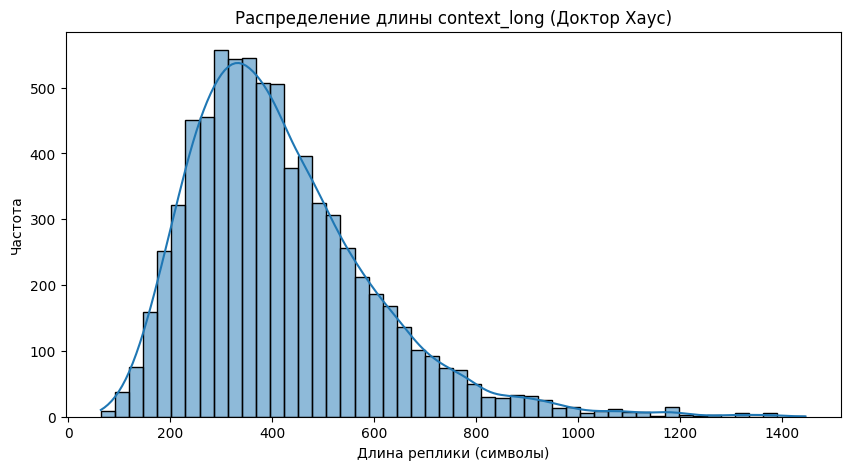

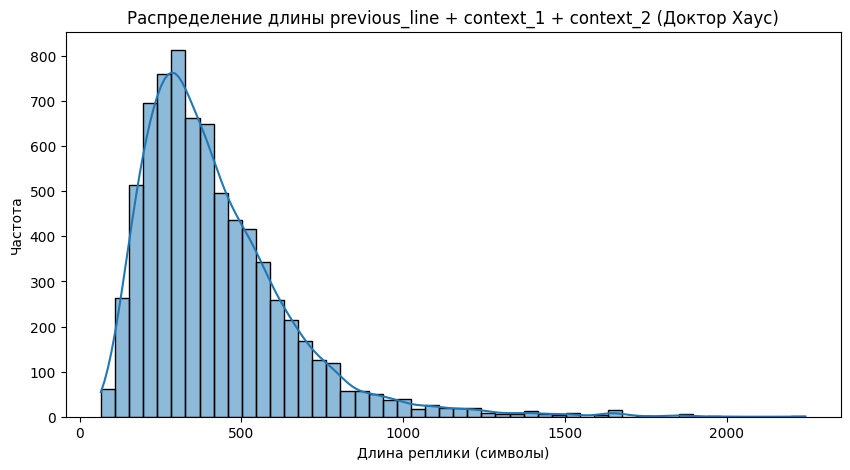

In [72]:
def plot_length_distribution(df, column, title):
    """
    –§—É–Ω–∫—Ü–∏—è –¥–ª—è –ø–æ—Å—Ç—Ä–æ–µ–Ω–∏—è —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –¥–ª–∏–Ω—ã —Ä–µ–ø–ª–∏–∫ –≤ —Å–∏–º–≤–æ–ª–∞—Ö.

    df: DataFrame —Å –∫–æ–ª–æ–Ω–∫–æ–π —Ç–µ–∫—Å—Ç–∞.
    column: –ù–∞–∑–≤–∞–Ω–∏–µ –∫–æ–ª–æ–Ω–∫–∏, –¥–ª–∏–Ω—É –∫–æ—Ç–æ—Ä–æ–π –∞–Ω–∞–ª–∏–∑–∏—Ä—É–µ–º.
    title: –ó–∞–≥–æ–ª–æ–≤–æ–∫ –≥—Ä–∞—Ñ–∏–∫–∞.
    """
    lengths = df[column].dropna().apply(len)

    plt.figure(figsize=(10, 5))
    sns.histplot(lengths, bins=50, kde=True)
    plt.xlabel("–î–ª–∏–Ω–∞ —Ä–µ–ø–ª–∏–∫–∏ (—Å–∏–º–≤–æ–ª—ã)")
    plt.ylabel("–ß–∞—Å—Ç–æ—Ç–∞")
    plt.title(title)
    plt.show()

# –ü—Ä–æ–≤–µ—Ä–∫–∞ –¥–ª–∏–Ω—ã context_long
plot_length_distribution(house_df, "context_long", "–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –¥–ª–∏–Ω—ã context_long (–î–æ–∫—Ç–æ—Ä –•–∞—É—Å)")

# –ü—Ä–æ–≤–µ—Ä–∫–∞ –¥–ª–∏–Ω—ã –∞–ª—å—Ç–µ—Ä–Ω–∞—Ç–∏–≤–Ω–æ–≥–æ –≤–∞—Ä–∏–∞–Ω—Ç–∞: previous_line + context_1 + context_2
house_df["context_combined"] = house_df[["previous_line", "context_1", "context_2"]].fillna("").agg(" ".join, axis=1)
plot_length_distribution(house_df, "context_combined", "–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –¥–ª–∏–Ω—ã previous_line + context_1 + context_2 (–î–æ–∫—Ç–æ—Ä –•–∞—É—Å)")

–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –¥–ª–∏–Ω—ã –∞–Ω–∫–æ—Ä–æ–≤ –ø–æ—Å–ª–µ –∫–æ–ø–∏—Ä–æ–≤–∞–Ω–∏—è previous_line:
count    7417.00000
mean       10.14251
std         9.81743
min         1.00000
25%         4.00000
50%         7.00000
75%        13.00000
max       152.00000
Name: anchor_length, dtype: float64


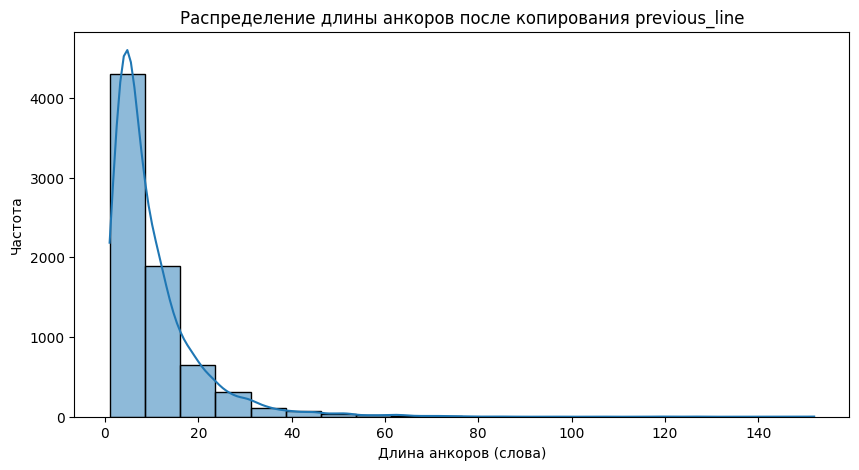

In [74]:
# –ö–æ–ø–∏—Ä—É–µ–º –ø—Ä–µ–¥—ã–¥—É—â–∏–µ —Ä–µ–ø–ª–∏–∫–∏ –≤ –∞–Ω–∫–æ—Ä—ã –±–µ–∑ –∏–∑–º–µ–Ω–µ–Ω–∏–π
house_df["anchor"] = house_df["previous_line"]

# –ü—Ä–æ–≤–µ—Ä–∫–∞ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏ –¥–ª–∏–Ω—ã –∞–Ω–∫–æ—Ä–æ–≤
house_df["anchor_length"] = house_df["anchor"].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
print("–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –¥–ª–∏–Ω—ã –∞–Ω–∫–æ—Ä–æ–≤ –ø–æ—Å–ª–µ –∫–æ–ø–∏—Ä–æ–≤–∞–Ω–∏—è previous_line:")
print(house_df["anchor_length"].describe())

# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –¥–ª–∏–Ω—ã –∞–Ω–∫–æ—Ä–æ–≤
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(house_df["anchor_length"], bins=20, kde=True)
plt.xlabel("–î–ª–∏–Ω–∞ –∞–Ω–∫–æ—Ä–æ–≤ (—Å–ª–æ–≤–∞)")
plt.ylabel("–ß–∞—Å—Ç–æ—Ç–∞")
plt.title("–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –¥–ª–∏–Ω—ã –∞–Ω–∫–æ—Ä–æ–≤ –ø–æ—Å–ª–µ –∫–æ–ø–∏—Ä–æ–≤–∞–Ω–∏—è previous_line")
plt.show()


In [77]:
# –í—ã–±–∏—Ä–∞–µ–º 5 —Å–∞–º—ã—Ö –¥–ª–∏–Ω–Ω—ã—Ö –∞–Ω–∫–æ—Ä–æ–≤
longest_anchors = house_df.nlargest(5, "anchor_length")[["anchor", "line"]]

# –í—ã–≤–æ–¥–∏–º –ø–æ–ª–Ω—ã–µ —Ç–µ–∫—Å—Ç—ã
for idx, row in longest_anchors.iterrows():
    print(f"–ê–Ω–∫–æ—Ä ({len(row['anchor'].split())} —Å–ª–æ–≤): {row['anchor']}")
    print(f"–û—Ç–≤–µ—Ç –•–∞—É—Å–∞: {row['line']}")
    print("-" * 100)

–ê–Ω–∫–æ—Ä (152 —Å–ª–æ–≤): A few things I forgot to mention. Ed Vogler is a brilliant businessMan. A brilliant Judge of people, and a Man who has nEver lost a fight. You know how I know the new ACE inhibitor is good? Because the old one was good. The new one is really the same, its just more expensive. A lot more expensive. See, thats another example of Eds brilliance. whenever one of his drugs is about to lose its patent he has his boys and girls alter it just a tiny bit and patent it all over again. Making not just a pointless new pill, but millions and millions of dollars. Which is good for Everbody, right? The Patients, pish. Who cares, theyre just so damn sick! God obviously nEver liked them anyway. All the healthy people in the room, lets have a big round of applause for Ed Vogler! I threw in a joke.
–û—Ç–≤–µ—Ç –•–∞—É—Å–∞: Im sorry. I should have taken a couple of extra Vicodin and just held my nose.
--------------------------------------------------------------------------------

In [79]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sentence_transformers import SentenceTransformer

# –ó–∞–≥—Ä—É–∂–∞–µ—Ç—Å—è –º–æ–¥–µ–ª—å SentenceTransformer
model = SentenceTransformer("all-mpnet-base-v2")

# –ü—Ä–æ–≤–µ—Ä–∫–∞ –Ω–∞–ª–∏—á–∏—è –Ω—É–∂–Ω—ã—Ö –∫–æ–ª–æ–Ω–æ–∫
assert "anchor" in house_df.columns, "–ö–æ–ª–æ–Ω–∫–∞ 'anchor' –æ—Ç—Å—É—Ç—Å—Ç–≤—É–µ—Ç –≤ house_df"
assert "line" in house_df.columns, "–ö–æ–ª–æ–Ω–∫–∞ 'line' –æ—Ç—Å—É—Ç—Å—Ç–≤—É–µ—Ç –≤ house_df"

# –£–¥–∞–ª–µ–Ω–∏–µ —Å—Ç—Ä–æ–∫, –≥–¥–µ anchor –∏–ª–∏ line –æ—Ç—Å—É—Ç—Å—Ç–≤—É—é—Ç, —á—Ç–æ–±—ã —Å–æ—Ö—Ä–∞–Ω–∏—Ç—å –æ–¥–∏–Ω–∞–∫–æ–≤—ã–π —Ä–∞–∑–º–µ—Ä
valid_rows = house_df.dropna(subset=["anchor", "line"]).reset_index(drop=True)

# –í–µ–∫—Ç–æ—Ä–∏–∑–∞—Ü–∏—è –∞–Ω–∫–æ—Ä–Ω—ã—Ö —Ä–µ–ø–ª–∏–∫ –∏ –∏—Ö –æ—Ç–≤–µ—Ç–æ–≤
print("–í–µ–∫—Ç–æ—Ä–∏–∑–∞—Ü–∏—è –∞–Ω–∫–æ—Ä–Ω—ã—Ö —Ä–µ–ø–ª–∏–∫ –∏ –æ—Ç–≤–µ—Ç–æ–≤...")
anchor_vectors = model.encode(valid_rows["anchor"].tolist(), convert_to_numpy=True)
response_vectors = model.encode(valid_rows["line"].tolist(), convert_to_numpy=True)

# –ü—Ä–æ–≤–µ—Ä–∫–∞ —Ä–∞–∑–º–µ—Ä–æ–≤ –≤–µ–∫—Ç–æ—Ä–æ–≤ (–æ–Ω–∏ –¥–æ–ª–∂–Ω—ã –±—ã—Ç—å –æ–¥–∏–Ω–∞–∫–æ–≤—ã–º–∏)
assert anchor_vectors.shape[0] == response_vectors.shape[0], "–†–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å –∞–Ω–∫–æ—Ä–Ω—ã—Ö –∏ –æ—Ç–≤–µ—Ç–Ω—ã—Ö –≤–µ–∫—Ç–æ—Ä–æ–≤ –Ω–µ —Å–æ–≤–ø–∞–¥–∞–µ—Ç"

# –í—ã—á–∏—Å–ª–µ–Ω–∏–µ –∫–æ—Å–∏–Ω—É—Å–Ω–æ–≥–æ —Å—Ö–æ–¥—Å—Ç–≤–∞
similarity_scores = cosine_similarity(anchor_vectors, response_vectors)
avg_similarity = np.mean(np.diag(similarity_scores))  # –ë–µ—Ä–µ—Ç—Å—è –¥–∏–∞–≥–æ–Ω–∞–ª—å, —á—Ç–æ–±—ã —Å—Ä–∞–≤–Ω–∏—Ç—å –ø–∞—Ä—ã

print(f"–°—Ä–µ–¥–Ω–µ–µ –∫–æ—Å–∏–Ω—É—Å–Ω–æ–µ —Å—Ö–æ–¥—Å—Ç–≤–æ –∞–Ω–∫–æ—Ä–Ω—ã—Ö —Ä–µ–ø–ª–∏–∫ –∏ –∏—Ö –æ—Ç–≤–µ—Ç–æ–≤: {avg_similarity:.4f}")


–í–µ–∫—Ç–æ—Ä–∏–∑–∞—Ü–∏—è –∞–Ω–∫–æ—Ä–Ω—ã—Ö —Ä–µ–ø–ª–∏–∫ –∏ –æ—Ç–≤–µ—Ç–æ–≤...
–°—Ä–µ–¥–Ω–µ–µ –∫–æ—Å–∏–Ω—É—Å–Ω–æ–µ —Å—Ö–æ–¥—Å—Ç–≤–æ –∞–Ω–∫–æ—Ä–Ω—ã—Ö —Ä–µ–ø–ª–∏–∫ –∏ –∏—Ö –æ—Ç–≤–µ—Ç–æ–≤: 0.2177


In [88]:
import re
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from tqdm.notebook import tqdm

# –ú–æ–¥–µ–ª—å SentenceTransformer –¥–ª—è –≤–µ–∫—Ç–æ—Ä–∏–∑–∞—Ü–∏–∏
model = SentenceTransformer("all-mpnet-base-v2")

def count_words(text):
    """–ü–æ–¥—Å—á–µ—Ç –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ —Å–ª–æ–≤ –≤ —Ç–µ–∫—Å—Ç–µ."""
    return len(text.split()) if isinstance(text, str) else 0

def split_sentences(text):
    """–†–∞–∑–±–∏–≤–∞–µ—Ç —Ç–µ–∫—Å—Ç –Ω–∞ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è."""
    return re.split(r'(?<=[.!?])\s+', text.strip())

def extract_relevant_pairs(context, response, min_words=10, max_words=25, similarity_threshold=0.3):
    """
    –ò–∑–≤–ª–µ–∫–∞–µ—Ç —Ä–µ–ª–µ–≤–∞–Ω—Ç–Ω—ã–µ –ø–∞—Ä—ã –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –∏–∑ –∫–æ–Ω—Ç–µ–∫—Å—Ç–∞ –∏ –æ—Ç–≤–µ—Ç–∞.
    –ö–∞–∂–¥–∞—è –ø–∞—Ä–∞ —Å–æ—Å—Ç–æ–∏—Ç –∏–∑ –æ–¥–Ω–æ–≥–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è –∏–∑ –∫–æ–Ω—Ç–µ–∫—Å—Ç–∞ –∏ –æ–¥–Ω–æ–≥–æ –∏–∑ –æ—Ç–≤–µ—Ç–∞.
    """
    if not isinstance(context, str) or not isinstance(response, str):
        return []

    context_sentences = split_sentences(context)
    response_sentences = split_sentences(response)

    pairs = []

    for context_sent in context_sentences:
        for response_sent in response_sentences:
            total_words = count_words(context_sent) + count_words(response_sent)
            if 10 <= total_words <= 25:
                # –í–µ–∫—Ç–æ—Ä–∏–∑–∞—Ü–∏—è –ø–æ–ø–∞—Ä–Ω–æ, —á—Ç–æ–±—ã –Ω–µ –∑–∞–±–∏–≤–∞—Ç—å –ø–∞–º—è—Ç—å
                context_vec = model.encode([context_sent])[0]
                response_vec = model.encode([response_sent])[0]

                similarity = cosine_similarity([context_vec], [response_vec])[0][0]

                # –ü–æ—Ä–æ–≥ –∫–æ—Å–∏–Ω—É—Å–Ω–æ–≥–æ —Å—Ö–æ–¥—Å—Ç–≤–∞ –¥–ª—è –æ—Ç–±–æ—Ä–∞ –ø–∞—Ä
                if similarity >= similarity_threshold:
                    pairs.append({"anchor": context_sent, "line": response_sent, "similarity": float(similarity)})

    return pairs

# –°–ø–∏—Å–æ–∫ –¥–ª—è –Ω–æ–≤—ã—Ö –ø–∞—Ä
new_data = []

# üîπ –ë–µ—Ä—ë–º —Ç–æ–ª—å–∫–æ 500 —Å—Ç—Ä–æ–∫ –¥–ª—è —Ç–µ—Å—Ç–∞
sample_size = 50
house_sample = house_df.head(sample_size)

# –ü—Ä–æ—Ö–æ–¥–∏–º –ø–æ –ø–æ–¥–≤—ã–±–æ—Ä–∫–µ
for _, row in tqdm(house_sample.iterrows(), total=len(house_sample), desc="–û–±—Ä–∞–±–æ—Ç–∫–∞ —Å—Ç—Ä–æ–∫ (—Ç–µ—Å—Ç)"):
    context = row.get("context_long", "")
    response = row.get("line", "")

    pairs = extract_relevant_pairs(context, response, similarity_threshold=0.3)

    # –î–æ–±–∞–≤–ª—è–µ–º –ø–∞—Ä—ã –≤ –æ—Ç–¥–µ–ª—å–Ω—ã–π —Å–ø–∏—Å–æ–∫
    for pair in pairs:
        pair["similarity"] = float(pair["similarity"])  # –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –≤ —á–∏—Å–ª–æ
        new_data.append(pair)

# –°–æ–∑–¥–∞–Ω–∏–µ –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–∞ —Å –Ω–æ–≤—ã–º–∏ –ø–∞—Ä–∞–º–∏
expanded_df_test = pd.DataFrame(new_data)

# ‚úÖ –ü—Ä–æ–≤–µ—Ä–∫–∞ –∏ —É–¥–∞–ª–µ–Ω–∏–µ —Å—Ç—Ä–æ–∫, –≥–¥–µ similarity –Ω–µ —á–∏—Å–ª–æ
expanded_df_test = expanded_df_test[pd.to_numeric(expanded_df_test["similarity"], errors="coerce").notna()]
expanded_df_test["similarity"] = expanded_df_test["similarity"].astype(float)

# –°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –ø–æ –∏—Ç–æ–≥–∞–º —Ç–µ—Å—Ç–∞
if not expanded_df_test.empty:
    avg_similarity = expanded_df_test["similarity"].mean()
    print(f"\n–°—Ä–µ–¥–Ω–µ–µ –∫–æ—Å–∏–Ω—É—Å–Ω–æ–µ —Å—Ö–æ–¥—Å—Ç–≤–æ –Ω–æ–≤—ã—Ö –ø–∞—Ä (—Ç–µ—Å—Ç): {avg_similarity:.4f}")

print(f"\n–¢–µ—Å—Ç: –≤–∑—è–ª–∏ {sample_size} —Å—Ç—Ä–æ–∫ –∏–∑ house_df")
print(f"–°–æ–∑–¥–∞–Ω–æ {len(expanded_df_test)} –Ω–æ–≤—ã—Ö –ø–∞—Ä –∞–Ω–∫–æ—Ä–æ–≤")


–û–±—Ä–∞–±–æ—Ç–∫–∞ —Å—Ç—Ä–æ–∫ (—Ç–µ—Å—Ç):   0%|          | 0/50 [00:00<?, ?it/s]


–°—Ä–µ–¥–Ω–µ–µ –∫–æ—Å–∏–Ω—É—Å–Ω–æ–µ —Å—Ö–æ–¥—Å—Ç–≤–æ –Ω–æ–≤—ã—Ö –ø–∞—Ä (—Ç–µ—Å—Ç): 0.6582

–¢–µ—Å—Ç: –≤–∑—è–ª–∏ 50 —Å—Ç—Ä–æ–∫ –∏–∑ house_df
–°–æ–∑–¥–∞–Ω–æ 139 –Ω–æ–≤—ã—Ö –ø–∞—Ä –∞–Ω–∫–æ—Ä–æ–≤


In [91]:
# –ó–∞–ø—É—Å–∫ –ø–æ–ª–Ω–æ–π –æ–±—Ä–∞–±–æ—Ç–∫–∏ –Ω–∞ –≤—Å–µ–º house_df
new_data_full = []

# –ü—Ä–æ—Ö–æ–¥–∏–º –ø–æ –≤—Å–µ–º—É –¥–∞—Ç–∞—Å–µ—Ç—É
for _, row in tqdm(house_df.iterrows(), total=len(house_df), desc="–û–±—Ä–∞–±–æ—Ç–∫–∞ —Å—Ç—Ä–æ–∫ (–ø–æ–ª–Ω—ã–π –∑–∞–ø—É—Å–∫)"):
    context = row.get("context_long", "")
    response = row.get("line", "")

    pairs = extract_relevant_pairs(context, response, similarity_threshold=0.3)

    # –î–æ–±–∞–≤–ª—è–µ–º –ø–∞—Ä—ã –≤ –æ–±—â–∏–π —Å–ø–∏—Å–æ–∫
    for pair in pairs:
        pair["similarity"] = float(pair["similarity"])
        new_data_full.append(pair)

# –°–æ–∑–¥–∞–µ–º —Ä–∞—Å—à–∏—Ä–µ–Ω–Ω—ã–π –¥–∞—Ç–∞—Ñ—Ä–µ–π–º
expanded_df_full = pd.DataFrame(new_data_full)

# ‚úÖ –ü—Ä–æ–≤–µ—Ä—è–µ–º –∏ —É–¥–∞–ª—è–µ–º –Ω–µ–∫–æ—Ä—Ä–µ–∫—Ç–Ω—ã–µ —Å—Ç—Ä–æ–∫–∏
expanded_df_full = expanded_df_full[pd.to_numeric(expanded_df_full["similarity"], errors="coerce").notna()]
expanded_df_full["similarity"] = expanded_df_full["similarity"].astype(float)

# –í—ã–≤–æ–¥ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏
if not expanded_df_full.empty:
    avg_similarity_full = expanded_df_full["similarity"].mean()
    print(f"\n–°—Ä–µ–¥–Ω–µ–µ –∫–æ—Å–∏–Ω—É—Å–Ω–æ–µ —Å—Ö–æ–¥—Å—Ç–≤–æ –Ω–æ–≤—ã—Ö –ø–∞—Ä (–ø–æ–ª–Ω—ã–π –∑–∞–ø—É—Å–∫): {avg_similarity_full:.4f}")

print(f"\n–ò—Å—Ö–æ–¥–Ω—ã–π —Ä–∞–∑–º–µ—Ä –¥–∞—Ç–∞—Å–µ—Ç–∞: {len(house_df)} —Å—Ç—Ä–æ–∫")
print(f"–°–æ–∑–¥–∞–Ω–æ –Ω–æ–≤—ã—Ö –ø–∞—Ä: {len(expanded_df_full)}")
print(f"–ò—Ç–æ–≥–æ–≤—ã–π —Ä–∞–∑–º–µ—Ä —Ä–∞—Å—à–∏—Ä–µ–Ω–Ω–æ–≥–æ –¥–∞—Ç–∞—Å–µ—Ç–∞: {len(house_df) + len(expanded_df_full)} —Å—Ç—Ä–æ–∫")

# –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤ –≤ CSV
expanded_df_full.to_csv("/content/expanded_pairs.csv", index=False)

print("\n–§–∞–π–ª expanded_pairs.csv —Å–æ—Ö—Ä–∞–Ω–µ–Ω.")


–û–±—Ä–∞–±–æ—Ç–∫–∞ —Å—Ç—Ä–æ–∫ (–ø–æ–ª–Ω—ã–π –∑–∞–ø—É—Å–∫):   0%|          | 0/7417 [00:00<?, ?it/s]


–°—Ä–µ–¥–Ω–µ–µ –∫–æ—Å–∏–Ω—É—Å–Ω–æ–µ —Å—Ö–æ–¥—Å—Ç–≤–æ –Ω–æ–≤—ã—Ö –ø–∞—Ä (–ø–æ–ª–Ω—ã–π –∑–∞–ø—É—Å–∫): 0.6866

–ò—Å—Ö–æ–¥–Ω—ã–π —Ä–∞–∑–º–µ—Ä –¥–∞—Ç–∞—Å–µ—Ç–∞: 7417 —Å—Ç—Ä–æ–∫
–°–æ–∑–¥–∞–Ω–æ –Ω–æ–≤—ã—Ö –ø–∞—Ä: 16518
–ò—Ç–æ–≥–æ–≤—ã–π —Ä–∞–∑–º–µ—Ä —Ä–∞—Å—à–∏—Ä–µ–Ω–Ω–æ–≥–æ –¥–∞—Ç–∞—Å–µ—Ç–∞: 23935 —Å—Ç—Ä–æ–∫

–§–∞–π–ª expanded_pairs.csv —Å–æ—Ö—Ä–∞–Ω–µ–Ω.


In [92]:
expanded_df_full

anchor  \
0              The one who cant talk, I liked that part.   
1        And shes not responding to radiation treatment.   
2                            Your cousin goes to an HMO?   
3      Youve got three overqualified doctors working ...   
4                                       Is she a doctor?   
...                                                  ...   
16513     All you have to do is create reasonable doubt.   
16514            That is a risk you are willing to take.   
16515                        How to act when youre gone?   
16516        Youre the last one I thought would hate me.   
16517             I got out of the back of the building.   

                                                    line  similarity  
0              The one who cant talk, I liked that part.    1.000000  
1                                        Is she a doctor    0.343417  
2                                        Is she a doctor    0.393680  
3                                        Is she a doctor    0.408620  
4      No, treating illnesses is why we became doctor...    0.383374  
...                                                  ...         ...  
16513     All you have to do is create reasonable doubt.    1.000000  
16514            That is a risk you are willing to take.    1.000000  
16515                        How to act when youre gone?    1.000000  
16516        Youre the last one I thought would hate me.    1.000000  
16517             I got out of the back of the building.    1.000000  

[16518 rows x 3 columns]

In [94]:
# –£–¥–∞–ª–µ–Ω–∏–µ –ø–æ–ª–Ω—ã—Ö –∫–æ–ø–∏–π
expanded_df_full = expanded_df_full[expanded_df_full["anchor"] != expanded_df_full["line"]].reset_index(drop=True)

# –í—ã–≤–æ–¥ –Ω–æ–≤–æ–π —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏
print(f"–ü–æ—Å–ª–µ —É–¥–∞–ª–µ–Ω–∏—è –∫–æ–ø–∏–π –æ—Å—Ç–∞–ª–æ—Å—å: {len(expanded_df_full)} —Å—Ç—Ä–æ–∫")

–ü–æ—Å–ª–µ —É–¥–∞–ª–µ–Ω–∏—è –∫–æ–ø–∏–π –æ—Å—Ç–∞–ª–æ—Å—å: 9335 —Å—Ç—Ä–æ–∫


–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –¥–ª–∏–Ω—ã –æ—Ç–≤–µ—Ç–æ–≤ –ø–æ—Å–ª–µ –æ–±—Ä–µ–∑–∫–∏ –¥–æ 30 —Å–ª–æ–≤:
count    9335.000000
mean        8.190252
std         3.692430
min         1.000000
25%         5.000000
50%         8.000000
75%        10.000000
max        23.000000
Name: line, dtype: float64


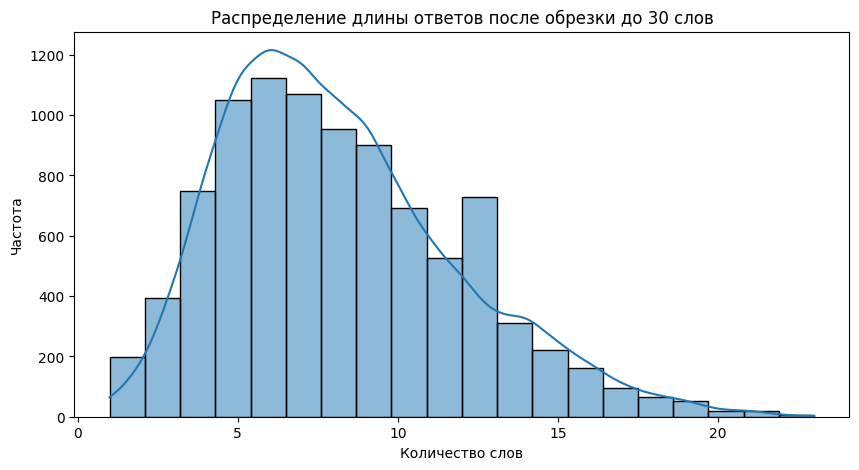

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

# –û–±—Ä–µ–∑–∫–∞ –¥–ª–∏–Ω–Ω—ã—Ö —Ä–µ–ø–ª–∏–∫ –•–∞—É—Å–∞ (–±–æ–ª—å—à–µ 30 —Å–ª–æ–≤)
MAX_WORDS = 30

def truncate_text(text, max_words=MAX_LINE_LENGTH):
    words = text.split()
    return " ".join(words[:max_words]) if len(words) > max_words else text

expanded_df_full["line"] = expanded_df_full["line"].apply(lambda x: truncate_text(x) if isinstance(x, str) else x)

# –í—ã–≤–æ–¥ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏ –±–µ–∑ –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω–æ–π –∫–æ–ª–æ–Ω–∫–∏
lengths = expanded_df_full["line"].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

print("–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –¥–ª–∏–Ω—ã –æ—Ç–≤–µ—Ç–æ–≤ –ø–æ—Å–ª–µ –æ–±—Ä–µ–∑–∫–∏ –¥–æ 30 —Å–ª–æ–≤:")
print(lengths.describe())

# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è
plt.figure(figsize=(10, 5))
sns.histplot(lengths, bins=20, kde=True)
plt.xlabel("–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å–ª–æ–≤")
plt.ylabel("–ß–∞—Å—Ç–æ—Ç–∞")
plt.title("–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –¥–ª–∏–Ω—ã –æ—Ç–≤–µ—Ç–æ–≤ –ø–æ—Å–ª–µ –æ–±—Ä–µ–∑–∫–∏ –¥–æ 30 —Å–ª–æ–≤")
plt.show()


–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –¥–ª–∏–Ω—ã –∞–Ω–∫–æ—Ä–æ–≤ –ø–æ—Å–ª–µ –æ–±—Ä–µ–∑–∫–∏ –¥–æ 20 –ø–æ—Å–ª–µ–¥–Ω–∏—Ö —Å–ª–æ–≤:
count    9335.000000
mean        7.800000
std         3.591791
min         1.000000
25%         5.000000
50%         7.000000
75%        10.000000
max        20.000000
Name: anchor, dtype: float64


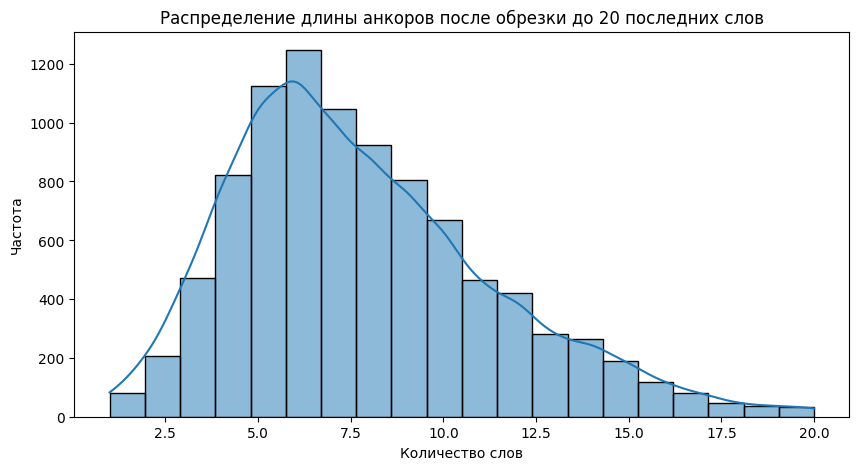

In [97]:
MAX_ANCHOR_LENGTH = 20  # –ú–∞–∫—Å–∏–º–∞–ª—å–Ω–∞—è –¥–ª–∏–Ω–∞ –∞–Ω–∫–æ—Ä–æ–≤ (–ø–æ—Å–ª–µ–¥–Ω–∏—Ö —Å–ª–æ–≤)

def truncate_anchor_last_words(text, max_words=MAX_ANCHOR_LENGTH):
    words = text.split()
    if len(words) <= max_words:
        return text
    # –û—Å—Ç–∞–≤–ª—è–µ–º —Ç–æ–ª—å–∫–æ –ø–æ—Å–ª–µ–¥–Ω–∏–µ —Å–ª–æ–≤–∞
    return " ".join(words[-max_words:])

# –°–æ–∑–¥–∞–Ω–∏–µ –∫–æ–ª–æ–Ω–∫–∏ anchor –∏ –∫–æ–ø–∏—Ä–æ–≤–∞–Ω–∏–µ –ø—Ä–µ–¥—ã–¥—É—â–∏—Ö —Ä–µ–ø–ª–∏–∫
expanded_df_full["anchor"] = expanded_df_full["anchor"].apply(lambda x: truncate_anchor_last_words(x) if isinstance(x, str) else x)

# –ü—Ä–æ–≤–µ—Ä–∫–∞ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏
anchor_lengths = expanded_df_full["anchor"].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

print("–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –¥–ª–∏–Ω—ã –∞–Ω–∫–æ—Ä–æ–≤ –ø–æ—Å–ª–µ –æ–±—Ä–µ–∑–∫–∏ –¥–æ 20 –ø–æ—Å–ª–µ–¥–Ω–∏—Ö —Å–ª–æ–≤:")
print(anchor_lengths.describe())

# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –¥–ª–∏–Ω—ã –∞–Ω–∫–æ—Ä–æ–≤
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(anchor_lengths, bins=20, kde=True)
plt.xlabel("–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å–ª–æ–≤")
plt.ylabel("–ß–∞—Å—Ç–æ—Ç–∞")
plt.title("–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –¥–ª–∏–Ω—ã –∞–Ω–∫–æ—Ä–æ–≤ –ø–æ—Å–ª–µ –æ–±—Ä–µ–∑–∫–∏ –¥–æ 20 –ø–æ—Å–ª–µ–¥–Ω–∏—Ö —Å–ª–æ–≤")
plt.show()


In [100]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sentence_transformers import SentenceTransformer

# –ó–∞–≥—Ä—É–∂–∞–µ—Ç—Å—è –º–æ–¥–µ–ª—å SentenceTransformer
model = SentenceTransformer("all-mpnet-base-v2")

# –ü—Ä–æ–≤–µ—Ä–∫–∞ –Ω–∞–ª–∏—á–∏—è –Ω—É–∂–Ω—ã—Ö –∫–æ–ª–æ–Ω–æ–∫
assert "anchor" in expanded_df_full.columns, "–ö–æ–ª–æ–Ω–∫–∞ 'anchor' –æ—Ç—Å—É—Ç—Å—Ç–≤—É–µ—Ç –≤ expanded_df_full"
assert "line" in expanded_df_full.columns, "–ö–æ–ª–æ–Ω–∫–∞ 'line' –æ—Ç—Å—É—Ç—Å—Ç–≤—É–µ—Ç –≤ expanded_df_full"

# –£–¥–∞–ª–µ–Ω–∏–µ —Å—Ç—Ä–æ–∫, –≥–¥–µ anchor –∏–ª–∏ line –æ—Ç—Å—É—Ç—Å—Ç–≤—É—é—Ç, —á—Ç–æ–±—ã —Å–æ—Ö—Ä–∞–Ω–∏—Ç—å –æ–¥–∏–Ω–∞–∫–æ–≤—ã–π —Ä–∞–∑–º–µ—Ä
valid_rows = expanded_df_full.dropna(subset=["anchor", "line"]).reset_index(drop=True)

# –í–µ–∫—Ç–æ—Ä–∏–∑–∞—Ü–∏—è –∞–Ω–∫–æ—Ä–Ω—ã—Ö —Ä–µ–ø–ª–∏–∫ –∏ –∏—Ö –æ—Ç–≤–µ—Ç–æ–≤
print("–í–µ–∫—Ç–æ—Ä–∏–∑–∞—Ü–∏—è –∞–Ω–∫–æ—Ä–Ω—ã—Ö —Ä–µ–ø–ª–∏–∫ –∏ –æ—Ç–≤–µ—Ç–æ–≤...")
anchor_vectors = model.encode(valid_rows["anchor"].tolist(), convert_to_numpy=True)
response_vectors = model.encode(valid_rows["line"].tolist(), convert_to_numpy=True)

# –ü—Ä–æ–≤–µ—Ä–∫–∞ —Ä–∞–∑–º–µ—Ä–æ–≤ –≤–µ–∫—Ç–æ—Ä–æ–≤ (–æ–Ω–∏ –¥–æ–ª–∂–Ω—ã –±—ã—Ç—å –æ–¥–∏–Ω–∞–∫–æ–≤—ã–º–∏)
assert anchor_vectors.shape[0] == response_vectors.shape[0], "–†–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å –∞–Ω–∫–æ—Ä–Ω—ã—Ö –∏ –æ—Ç–≤–µ—Ç–Ω—ã—Ö –≤–µ–∫—Ç–æ—Ä–æ–≤ –Ω–µ —Å–æ–≤–ø–∞–¥–∞–µ—Ç"

# –í—ã—á–∏—Å–ª–µ–Ω–∏–µ –∫–æ—Å–∏–Ω—É—Å–Ω–æ–≥–æ —Å—Ö–æ–¥—Å—Ç–≤–∞
similarity_scores = cosine_similarity(anchor_vectors, response_vectors)
avg_similarity = np.mean(np.diag(similarity_scores))  # –ë–µ—Ä–µ—Ç—Å—è –¥–∏–∞–≥–æ–Ω–∞–ª—å, —á—Ç–æ–±—ã —Å—Ä–∞–≤–Ω–∏—Ç—å –ø–∞—Ä—ã

print(f"–°—Ä–µ–¥–Ω–µ–µ –∫–æ—Å–∏–Ω—É—Å–Ω–æ–µ —Å—Ö–æ–¥—Å—Ç–≤–æ –∞–Ω–∫–æ—Ä–Ω—ã—Ö —Ä–µ–ø–ª–∏–∫ –∏ –∏—Ö –æ—Ç–≤–µ—Ç–æ–≤: {avg_similarity:.4f}")


–í–µ–∫—Ç–æ—Ä–∏–∑–∞—Ü–∏—è –∞–Ω–∫–æ—Ä–Ω—ã—Ö —Ä–µ–ø–ª–∏–∫ –∏ –æ—Ç–≤–µ—Ç–æ–≤...
–°—Ä–µ–¥–Ω–µ–µ –∫–æ—Å–∏–Ω—É—Å–Ω–æ–µ —Å—Ö–æ–¥—Å—Ç–≤–æ –∞–Ω–∫–æ—Ä–Ω—ã—Ö —Ä–µ–ø–ª–∏–∫ –∏ –∏—Ö –æ—Ç–≤–µ—Ç–æ–≤: 0.4454


In [103]:
# –£–¥–∞–ª–µ–Ω–∏–µ —Å—Ç—Ä–æ–∫, –≥–¥–µ –æ—Ç–≤–µ—Ç —Å–æ–¥–µ—Ä–∂–∏—Ç—Å—è –≤ –∞–Ω–∫–æ—Ä–µ
expanded_df_full = expanded_df_full[~expanded_df_full["answer_in_anchor"]].reset_index(drop=True)

# –ò—Ç–æ–≥–æ–≤–∞—è —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞
print(f"–û–±–Ω–æ–≤–ª–µ–Ω–Ω—ã–π —Ä–∞–∑–º–µ—Ä –¥–∞—Ç–∞—Å–µ—Ç–∞ –ø–æ—Å–ª–µ —É–¥–∞–ª–µ–Ω–∏—è: {len(expanded_df_full)} —Å—Ç—Ä–æ–∫")

–û–±–Ω–æ–≤–ª–µ–Ω–Ω—ã–π —Ä–∞–∑–º–µ—Ä –¥–∞—Ç–∞—Å–µ—Ç–∞ –ø–æ—Å–ª–µ —É–¥–∞–ª–µ–Ω–∏—è: 8674 —Å—Ç—Ä–æ–∫


In [105]:
import numpy as np

threshold_lower = 0.05  # –û—Å–ª–∞–±–ª—è–µ–º –Ω–∏–∂–Ω–∏–π –ø–æ—Ä–æ–≥
threshold_upper = 0.2   # –£–º–µ–Ω—å—à–∞–µ–º –≤–µ—Ä—Ö–Ω–∏–π –ø–æ—Ä–æ–≥
top_k = 50  # –†–∞—Å—à–∏—Ä—è–µ–º –≤—ã–±–æ—Ä–∫—É –¥–ª—è –Ω–µ–≥–∞—Ç–∏–≤–Ω—ã—Ö –ø—Ä–∏–º–µ—Ä–æ–≤

# –ü—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ DataFrame –≤ –º–∞—Å—Å–∏–≤—ã
antagonist_lines = antagonists_df["line"].values
similarities_np = np.array(similarities)

# –°–æ–∑–¥–∞–Ω–∏–µ —Å–ø–∏—Å–∫–∞ –¥–ª—è –Ω–µ–≥–∞—Ç–∏–≤–Ω—ã—Ö –ø—Ä–∏–º–µ—Ä–æ–≤ (—Å —É—á–µ—Ç–æ–º —Ä–∞—Å—à–∏—Ä–µ–Ω–Ω–æ–≥–æ –¥–∞—Ç–∞—Å–µ—Ç–∞)
new_hard_negatives = np.full(len(expanded_df_full), "", dtype=object)

for i in range(similarities_np.shape[0]):
    sorted_idx = np.argsort(similarities_np[i])[::-1]  # –°–æ—Ä—Ç–∏—Ä–æ–≤–∫–∞ –ø–æ —É–±—ã–≤–∞–Ω–∏—é
    candidates = sorted_idx[
        (similarities_np[i][sorted_idx] > threshold_lower) &
        (similarities_np[i][sorted_idx] < threshold_upper)
    ]  # –§–∏–ª—å—Ç—Ä–∞—Ü–∏—è —Å–ª–∏—à–∫–æ–º –ª–µ–≥–∫–∏—Ö –∏ —Å–ª–∏—à–∫–æ–º –ø–æ—Ö–æ–∂–∏—Ö –ø—Ä–∏–º–µ—Ä–æ–≤

    if len(candidates) > 5:
        neg_idx = np.random.choice(candidates[:top_k])  # –í—ã–±–∏—Ä–∞–µ–º —Å–ª—É—á–∞–π–Ω—ã–π –∏–∑ top-k
        new_hard_negatives[i] = antagonist_lines[neg_idx]

# ‚úÖ –î–æ–±–∞–≤–ª—è–µ–º –≤ expanded_df_full –∫–æ–ª–æ–Ω–∫—É —Å –Ω–µ–≥–∞—Ç–∏–≤–Ω—ã–º–∏ –æ—Ç–≤–µ—Ç–∞–º–∏
expanded_df_full["neg_answer"] = new_hard_negatives[:len(expanded_df_full)]  # –ü–æ–¥–≥–æ–Ω—è–µ–º –¥–ª–∏–Ω—É
print(f"–û–±–Ω–æ–≤–ª–µ–Ω–æ {len(new_hard_negatives)} –Ω–µ–≥–∞—Ç–∏–≤–Ω—ã—Ö –ø—Ä–∏–º–µ—Ä–æ–≤.")

# === –¢–µ–ø–µ—Ä—å —Å–æ–∑–¥–∞–µ–º —Ç—Ä–∏–ø–ª–µ—Ç—ã ===
triplets_df = expanded_df_full[["anchor", "line", "neg_answer"]].copy()
triplets_df.columns = ["anchor", "response", "neg_response"]  # –ü–µ—Ä–µ–∏–º–µ–Ω–æ–≤—ã–≤–∞–µ–º –¥–ª—è –µ–¥–∏–Ω–æ–æ–±—Ä–∞–∑–∏—è

print(f"–°–æ–∑–¥–∞–Ω–æ {len(triplets_df)} —Ç—Ä–∏–ø–ª–µ—Ç–æ–≤.")

# –ü—Ä–æ–≤–µ—Ä–∫–∞ –Ω–∞ NaN
assert triplets_df.isna().sum().sum() == 0, "–ï—Å—Ç—å NaN –≤ —Ç—Ä–∏–ø–ª–µ—Ç–∞—Ö!"

# ‚úÖ –í—ã–≤–æ–¥ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏
print("\n–¢—Ä–∏–ø–ª–µ—Ç—ã —É—Å–ø–µ—à–Ω–æ —Å–æ–∑–¥–∞–Ω—ã.")
print(triplets_df.head())


–û–±–Ω–æ–≤–ª–µ–Ω–æ 8674 –Ω–µ–≥–∞—Ç–∏–≤–Ω—ã—Ö –ø—Ä–∏–º–µ—Ä–æ–≤.
–°–æ–∑–¥–∞–Ω–æ 8674 —Ç—Ä–∏–ø–ª–µ—Ç–æ–≤.

–¢—Ä–∏–ø–ª–µ—Ç—ã —É—Å–ø–µ—à–Ω–æ —Å–æ–∑–¥–∞–Ω—ã.
                                              anchor  \
0    And shes not responding to radiation treatment.   
1                        Your cousin goes to an HMO?   
2  Youve got three overqualified doctors working ...   
3                                   Is she a doctor?   
4                                                Dr.   

                                            response neg_response  
0                                    Is she a doctor               
1                                    Is she a doctor               
2                                    Is she a doctor               
3  No, treating illnesses is why we became doctor...               
4  No, treating illnesses is why we became doctor...               


Sentences: 3, Similarities shape: (3,)
Sentences: 2, Similarities shape: (2,)
Sentences: 5, Similarities shape: (5,)
Sentences: 3, Similarities shape: (3,)
Sentences: 3, Similarities shape: (3,)
Sentences: 2, Similarities shape: (2,)
Sentences: 7, Similarities shape: (7,)
Sentences: 3, Similarities shape: (3,)
Sentences: 3, Similarities shape: (3,)
Sentences: 1, Similarities shape: (1,)
Sentences: 2, Similarities shape: (2,)
Sentences: 4, Similarities shape: (4,)
Sentences: 4, Similarities shape: (4,)
Sentences: 4, Similarities shape: (4,)
Sentences: 2, Similarities shape: (2,)
Sentences: 4, Similarities shape: (4,)
Sentences: 3, Similarities shape: (3,)
Sentences: 4, Similarities shape: (4,)
Sentences: 1, Similarities shape: (1,)
Sentences: 2, Similarities shape: (2,)
Sentences: 4, Similarities shape: (4,)
Sentences: 4, Similarities shape: (4,)
Sentences: 4, Similarities shape: (4,)
Sentences: 3, Similarities shape: (3,)
Sentences: 3, Similarities shape: (3,)
Sentences: 8, Similaritie

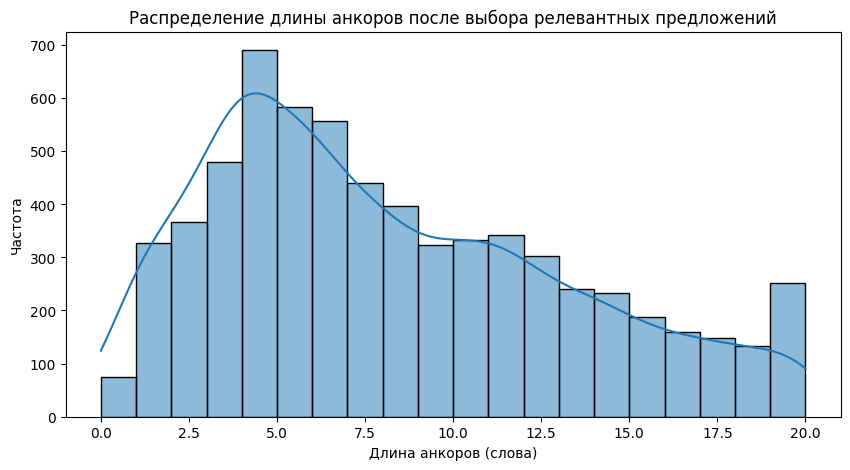

In [28]:
def count_words(text):
    """–ü–æ–¥—Å—á–µ—Ç –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ —Å–ª–æ–≤ –≤ —Ç–µ–∫—Å—Ç–µ."""
    return len(text.split()) if isinstance(text, str) else 0

def split_sentences(text):
    """–†–∞–∑–±–∏–≤–∞–µ—Ç —Ç–µ–∫—Å—Ç –Ω–∞ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è —Å —É—á–µ—Ç–æ–º –∑–Ω–∞–∫–æ–≤ –ø—Ä–µ–ø–∏–Ω–∞–Ω–∏—è."""
    return re.split(r'(?<=[.!?])\s+', text.strip())

def select_best_sentences(row, min_words=10, max_words=20):
    """
    –í—ã–±–∏—Ä–∞–µ—Ç 1-3 –Ω–∞–∏–±–æ–ª–µ–µ —Ä–µ–ª–µ–≤–∞–Ω—Ç–Ω—ã—Ö –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è –∏–∑ `previous_line`
    –Ω–∞ –æ—Å–Ω–æ–≤–µ –∫–æ—Å–∏–Ω—É—Å–Ω–æ–≥–æ —Å—Ö–æ–¥—Å—Ç–≤–∞ —Å `line` (–æ—Ç–≤–µ—Ç–æ–º).
    """
    text = row.get("previous_line", "")
    response = row.get("line", "")

    if not isinstance(text, str) or len(text) == 0:
        return None

    # –†–∞–∑–¥–µ–ª—è–µ–º –ø—Ä–µ–¥—ã–¥—É—â—É—é —Ä–µ–ø–ª–∏–∫—É –Ω–∞ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è
    sentences = split_sentences(text)
    if len(sentences) == 0:
        return None  # –ï—Å–ª–∏ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –Ω–µ—Ç, –≤–µ—Ä–Ω—É—Ç—å –ø—É—Å—Ç–æ–π –∞–Ω–∫–æ—Ä

    # –í–µ–∫—Ç–æ—Ä–∏–∑—É–µ–º –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è –∏ —Å–∞–º –æ—Ç–≤–µ—Ç
    try:
        sentences_vectors = model.encode(sentences, convert_to_numpy=True)
        response_vector = model.encode([response], convert_to_numpy=True)[0]  # –ò–∑–≤–ª–µ–∫–∞–µ–º –ø–µ—Ä–≤—ã–π –≤–µ–∫—Ç–æ—Ä
    except Exception as e:
        print(f"–û—à–∏–±–∫–∞ –≤–µ–∫—Ç–æ—Ä–∏–∑–∞—Ü–∏–∏: {e}")
        return None

    # –í—ã—á–∏—Å–ª—è–µ–º –∫–æ—Å–∏–Ω—É—Å–Ω–æ–µ —Å—Ö–æ–¥—Å—Ç–≤–æ
    similarities = cosine_similarity(sentences_vectors, [response_vector]).flatten()

    # –û—Ç–ª–∞–¥–∫–∞: –ø—Ä–æ–≤–µ—Ä–∏—Ç—å —Ä–∞–∑–º–µ—Ä—ã –º–∞—Å—Å–∏–≤–æ–≤
    print(f"Sentences: {len(sentences)}, Similarities shape: {similarities.shape}")

    # –ï—Å–ª–∏ similarities –∏–º–µ–µ—Ç 0-–º–µ—Ä–Ω—É—é —Ñ–æ—Ä–º—É (—Å–∫–∞–ª—è—Ä), –∑–Ω–∞—á–∏—Ç, –ø—Ä–æ–∏–∑–æ—à–ª–∞ –æ—à–∏–±–∫–∞
    if similarities.ndim == 0:
        print("–û—à–∏–±–∫–∞: similarities –∏–º–µ–µ—Ç 0-–º–µ—Ä–Ω—É—é —Ñ–æ—Ä–º—É (—Å–∫–∞–ª—è—Ä).")
        return None

    # –°–æ—Ä—Ç–∏—Ä—É–µ–º –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è –ø–æ —É–±—ã–≤–∞–Ω–∏—é —Å—Ö–æ–∂–µ—Å—Ç–∏
    ranked_sentences = sorted(zip(sentences, similarities), key=lambda x: x[1], reverse=True)

    # –í—ã–±–∏—Ä–∞–µ–º 1-3 –Ω–∞–∏–±–æ–ª–µ–µ —Ä–µ–ª–µ–≤–∞–Ω—Ç–Ω—ã—Ö –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è, –ø–æ–∫–∞ –Ω–µ –¥–æ—Å—Ç–∏–≥–Ω–µ–º min_words
    selected_sentences = []
    total_words = 0
    for sent, _ in ranked_sentences:
        words = sent.split()
        if total_words + len(words) > max_words:
            break
        selected_sentences.append(sent)
        total_words += len(words)
        if total_words >= min_words:
            break

    return " ".join(selected_sentences) if selected_sentences else None

# –ü—Ä–∏–º–µ–Ω—è–µ–º –º–µ—Ç–æ–¥ —Ç–æ–ª—å–∫–æ –∫ –¥–ª–∏–Ω–Ω—ã–º —Ä–µ–ø–ª–∏–∫–∞–º
mask_long_anchors = house_df["previous_line"].apply(count_words) > 20
house_df.loc[mask_long_anchors, "anchor"] = house_df[mask_long_anchors].apply(select_best_sentences, axis=1)

# –ü—Ä–æ–≤–µ—Ä—è–µ–º —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫—É
house_df["anchor_length"] = house_df["anchor"].apply(count_words)
print("–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –¥–ª–∏–Ω—ã –∞–Ω–∫–æ—Ä–æ–≤ –ø–æ—Å–ª–µ –≤—ã–±–æ—Ä–∞ —Ä–µ–ª–µ–≤–∞–Ω—Ç–Ω—ã—Ö –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π:")
print(house_df["anchor_length"].describe())

# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(house_df["anchor_length"], bins=20, kde=True)
plt.xlabel("–î–ª–∏–Ω–∞ –∞–Ω–∫–æ—Ä–æ–≤ (—Å–ª–æ–≤–∞)")
plt.ylabel("–ß–∞—Å—Ç–æ—Ç–∞")
plt.title("–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –¥–ª–∏–Ω—ã –∞–Ω–∫–æ—Ä–æ–≤ –ø–æ—Å–ª–µ –≤—ã–±–æ—Ä–∞ —Ä–µ–ª–µ–≤–∞–Ω—Ç–Ω—ã—Ö –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π")
plt.show()


In [30]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# –ü—Ä–æ–≤–µ—Ä–∫–∞ –Ω–∞–ª–∏—á–∏—è –Ω—É–∂–Ω—ã—Ö –∫–æ–ª–æ–Ω–æ–∫
assert "anchor" in house_df.columns, "–ö–æ–ª–æ–Ω–∫–∞ 'anchor' –æ—Ç—Å—É—Ç—Å—Ç–≤—É–µ—Ç –≤ house_df"
assert "line" in house_df.columns, "–ö–æ–ª–æ–Ω–∫–∞ 'line' –æ—Ç—Å—É—Ç—Å—Ç–≤—É–µ—Ç –≤ house_df"

# –í–µ–∫—Ç–æ—Ä–∏–∑–∞—Ü–∏—è –∞–Ω–∫–æ—Ä–Ω—ã—Ö —Ä–µ–ø–ª–∏–∫ –∏ –∏—Ö –æ—Ç–≤–µ—Ç–æ–≤
print("–í–µ–∫—Ç–æ—Ä–∏–∑–∞—Ü–∏—è –∞–Ω–∫–æ—Ä–Ω—ã—Ö —Ä–µ–ø–ª–∏–∫ –∏ –æ—Ç–≤–µ—Ç–æ–≤...")
anchor_vectors = model.encode(house_df["anchor"].dropna().tolist(), convert_to_numpy=True)
response_vectors = model.encode(house_df["line"].dropna().tolist(), convert_to_numpy=True)

# –í—ã—á–∏—Å–ª–µ–Ω–∏–µ –∫–æ—Å–∏–Ω—É—Å–Ω–æ–≥–æ —Å—Ö–æ–¥—Å—Ç–≤–∞
similarity_scores = cosine_similarity(anchor_vectors, response_vectors)
avg_similarity = np.mean(similarity_scores.diagonal())

print(f"–°—Ä–µ–¥–Ω–µ–µ –∫–æ—Å–∏–Ω—É—Å–Ω–æ–µ —Å—Ö–æ–¥—Å—Ç–≤–æ –∞–Ω–∫–æ—Ä–Ω—ã—Ö —Ä–µ–ø–ª–∏–∫ –∏ –∏—Ö –æ—Ç–≤–µ—Ç–æ–≤: {avg_similarity:.4f}")


–í–µ–∫—Ç–æ—Ä–∏–∑–∞—Ü–∏—è –∞–Ω–∫–æ—Ä–Ω—ã—Ö —Ä–µ–ø–ª–∏–∫ –∏ –æ—Ç–≤–µ—Ç–æ–≤...
–°—Ä–µ–¥–Ω–µ–µ –∫–æ—Å–∏–Ω—É—Å–Ω–æ–µ —Å—Ö–æ–¥—Å—Ç–≤–æ –∞–Ω–∫–æ—Ä–Ω—ã—Ö —Ä–µ–ø–ª–∏–∫ –∏ –∏—Ö –æ—Ç–≤–µ—Ç–æ–≤: 0.1072


–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –¥–ª–∏–Ω—ã –∞–Ω–∫–æ—Ä–æ–≤ –ø–æ—Å–ª–µ –∑–∞–ø–æ–ª–Ω–µ–Ω–∏—è –∏–∑ –ø–æ—Å–ª–µ–¥–Ω–µ–≥–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è:
count    6598.000000
mean        8.543498
std         4.560526
min         3.000000
25%         5.000000
50%         7.000000
75%        11.000000
max        20.000000
Name: anchor_length, dtype: float64


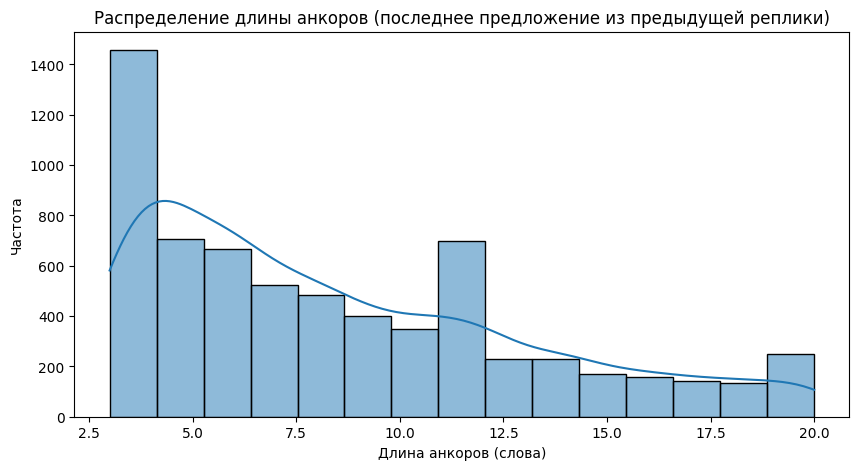

–ó–∞–ø–æ–ª–Ω–µ–Ω–æ 6598 –∞–Ω–∫–æ—Ä–æ–≤ –∏–∑ 8329 —Å—Ç—Ä–æ–∫ –ø–æ—Å–ª–µ –¥–æ—Ä–∞–±–æ—Ç–∫–∏.


In [75]:
# –°–æ–∑–¥–∞—ë–º –∫–æ–ª–æ–Ω–∫—É 'anchor', –µ—Å–ª–∏ –µ—ë –Ω–µ—Ç
if "anchor" not in house_df.columns:
    house_df["anchor"] = None

# –ü—Ä–∏–º–µ–Ω–µ–Ω–∏–µ –∫ —Å—Ç—Ä–æ–∫–∞–º, –≥–¥–µ anchor –Ω–µ –∑–∞–ø–æ–ª–Ω–µ–Ω –∏ previous_line > 20 —Å–ª–æ–≤
mask = house_df["anchor"].isna() & (house_df["previous_line"].apply(count_words) > 20)
house_df.loc[mask, "anchor"] = house_df.loc[mask, "previous_line"].apply(extract_last_sentence)

# –í—ã–≤–æ–¥ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏
house_df["anchor_length"] = house_df["anchor"].dropna().apply(count_words)
print("–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –¥–ª–∏–Ω—ã –∞–Ω–∫–æ—Ä–æ–≤ –ø–æ—Å–ª–µ –∑–∞–ø–æ–ª–Ω–µ–Ω–∏—è –∏–∑ –ø–æ—Å–ª–µ–¥–Ω–µ–≥–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è:")
print(house_df["anchor_length"].describe())

# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –¥–ª–∏–Ω—ã –∞–Ω–∫–æ—Ä–æ–≤
plt.figure(figsize=(10, 5))
sns.histplot(house_df["anchor_length"], bins=15, kde=True)
plt.xlabel("–î–ª–∏–Ω–∞ –∞–Ω–∫–æ—Ä–æ–≤ (—Å–ª–æ–≤–∞)")
plt.ylabel("–ß–∞—Å—Ç–æ—Ç–∞")
plt.title("–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –¥–ª–∏–Ω—ã –∞–Ω–∫–æ—Ä–æ–≤ (–ø–æ—Å–ª–µ–¥–Ω–µ–µ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–µ –∏–∑ –ø—Ä–µ–¥—ã–¥—É—â–µ–π —Ä–µ–ø–ª–∏–∫–∏)")
plt.show()

# –ü–æ–¥—Å—á–µ—Ç –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ –∑–∞–ø–æ–ª–Ω–µ–Ω–Ω—ã—Ö –∞–Ω–∫–æ—Ä–æ–≤
num_filled = house_df["anchor"].notna().sum()
num_total = len(house_df)
print(f"–ó–∞–ø–æ–ª–Ω–µ–Ω–æ {num_filled} –∞–Ω–∫–æ—Ä–æ–≤ –∏–∑ {num_total} —Å—Ç—Ä–æ–∫ –ø–æ—Å–ª–µ –¥–æ—Ä–∞–±–æ—Ç–∫–∏.")


–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –¥–ª–∏–Ω—ã previous_line —É —Å—Ç—Ä–æ–∫ —Å –ø—É—Å—Ç—ã–º –∞–Ω–∫–æ—Ä–æ–º:
count    1731.000000
mean       16.600809
std        18.119245
min         0.000000
25%         2.000000
50%         2.000000
75%        27.500000
max       152.000000
Name: previous_line, dtype: float64


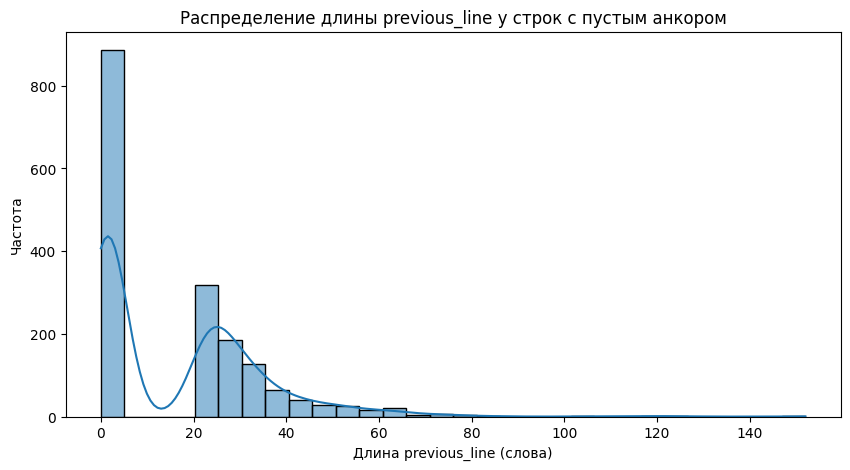

In [76]:
# –§–∏–ª—å—Ç—Ä–∞—Ü–∏—è —Å—Ç—Ä–æ–∫ —Å –ø—É—Å—Ç—ã–º –∞–Ω–∫–æ—Ä–æ–º
empty_anchor_mask = house_df["anchor"].isna()
empty_previous_lengths = house_df.loc[empty_anchor_mask, "previous_line"].dropna().apply(lambda x: len(x.split()))

# –í—ã–≤–æ–¥ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏
print("–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –¥–ª–∏–Ω—ã previous_line —É —Å—Ç—Ä–æ–∫ —Å –ø—É—Å—Ç—ã–º –∞–Ω–∫–æ—Ä–æ–º:")
print(empty_previous_lengths.describe())

# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è
plt.figure(figsize=(10, 5))
sns.histplot(empty_previous_lengths, bins=30, kde=True)
plt.xlabel("–î–ª–∏–Ω–∞ previous_line (—Å–ª–æ–≤–∞)")
plt.ylabel("–ß–∞—Å—Ç–æ—Ç–∞")
plt.title("–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –¥–ª–∏–Ω—ã previous_line —É —Å—Ç—Ä–æ–∫ —Å –ø—É—Å—Ç—ã–º –∞–Ω–∫–æ—Ä–æ–º")
plt.show()


–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –¥–ª–∏–Ω—ã –∞–Ω–∫–æ—Ä–æ–≤ –ø–æ—Å–ª–µ –∑–∞–ø–æ–ª–Ω–µ–Ω–∏—è –ø–æ—Å–ª–µ–¥–Ω–∏–º–∏ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è–º–∏ –∏–∑ previous_line:
count    8329.000000
mean        7.848481
std         4.889126
min         0.000000
25%         4.000000
50%         7.000000
75%        11.000000
max        20.000000
Name: anchor_length, dtype: float64


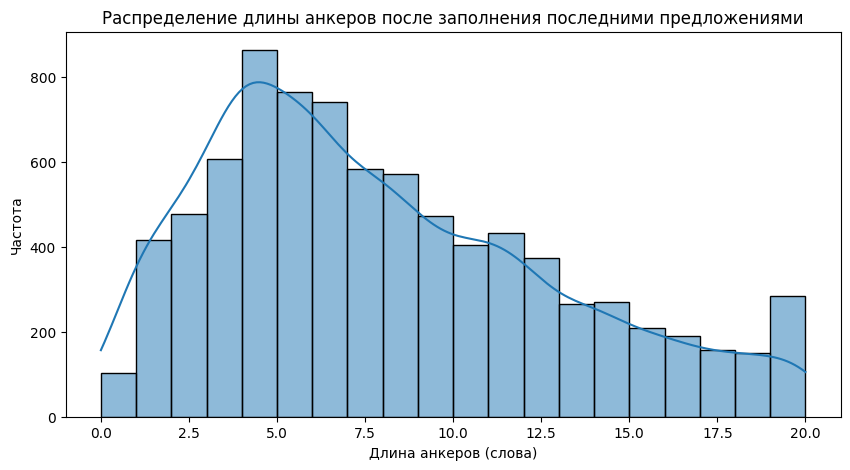

In [77]:
import re

def extract_last_sentences(text, min_words=5, max_words=20):
    """
    –ë–µ—Ä–µ—Ç 1-3 –ø–æ—Å–ª–µ–¥–Ω–∏—Ö –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è –∏–∑ —Ç–µ–∫—Å—Ç–∞, —á—Ç–æ–±—ã –ø–æ–ª—É—á–∏—Ç—å –æ—Ç 5 –¥–æ 20 —Å–ª–æ–≤.
    """
    if not isinstance(text, str) or len(text) == 0:
        return None

    # –†–∞–∑–±–∏–≤–∞–µ–º —Ç–µ–∫—Å—Ç –Ω–∞ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è —Å —É—á–µ—Ç–æ–º –ø—É–Ω–∫—Ç—É–∞—Ü–∏–∏
    sentences = re.split(r'(?<=[.!?])\s+', text.strip())

    # –ù–∞—á–∏–Ω–∞–µ–º —Å–æ–±–∏—Ä–∞—Ç—å –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è —Å –∫–æ–Ω—Ü–∞
    selected_sentences = []
    total_words = 0

    for sent in reversed(sentences):  # –î–≤–∏–≥–∞–µ–º—Å—è –æ—Ç –ø–æ—Å–ª–µ–¥–Ω–µ–≥–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è
        words = sent.split()

        if total_words + len(words) > max_words:
            break  # –ï—Å–ª–∏ –ø—Ä–µ–≤—ã—à–∞–µ–º max_words, –æ—Å—Ç–∞–Ω–∞–≤–ª–∏–≤–∞–µ–º—Å—è

        selected_sentences.append(sent)
        total_words += len(words)

        if total_words >= min_words:
            break  # –ö–∞–∫ —Ç–æ–ª—å–∫–æ –Ω–∞–±—Ä–∞–ª–∏ min_words, –æ—Å—Ç–∞–Ω–∞–≤–ª–∏–≤–∞–µ–º—Å—è

    # –°–∫–ª–µ–∏–≤–∞–µ–º –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è –≤ –ø—Ä–∞–≤–∏–ª—å–Ω–æ–º –ø–æ—Ä—è–¥–∫–µ
    return " ".join(reversed(selected_sentences)).strip() if selected_sentences else None

# –ó–∞–ø–æ–ª–Ω—è–µ–º –ø—É—Å—Ç—ã–µ –∞–Ω–∫–æ—Ä—ã
empty_anchor_mask = house_df["anchor"].isna()
house_df.loc[empty_anchor_mask, "anchor"] = house_df.loc[empty_anchor_mask, "previous_line"].apply(extract_last_sentences)

# –ü—Ä–æ–≤–µ—Ä–∫–∞ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏
house_df["anchor_length"] = house_df["anchor"].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
print("–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –¥–ª–∏–Ω—ã –∞–Ω–∫–æ—Ä–æ–≤ –ø–æ—Å–ª–µ –∑–∞–ø–æ–ª–Ω–µ–Ω–∏—è –ø–æ—Å–ª–µ–¥–Ω–∏–º–∏ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è–º–∏ –∏–∑ previous_line:")
print(house_df["anchor_length"].describe())

# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è
plt.figure(figsize=(10, 5))
sns.histplot(house_df["anchor_length"], bins=20, kde=True)
plt.xlabel("–î–ª–∏–Ω–∞ –∞–Ω–∫–µ—Ä–æ–≤ (—Å–ª–æ–≤–∞)")
plt.ylabel("–ß–∞—Å—Ç–æ—Ç–∞")
plt.title("–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –¥–ª–∏–Ω—ã –∞–Ω–∫–µ—Ä–æ–≤ –ø–æ—Å–ª–µ –∑–∞–ø–æ–ª–Ω–µ–Ω–∏—è –ø–æ—Å–ª–µ–¥–Ω–∏–º–∏ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è–º–∏")
plt.show()


In [78]:
nan_count = house_df["anchor"].isna().sum()
print(f"–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ NaN –≤ –∫–æ–ª–æ–Ω–∫–µ 'anchor': {nan_count}")


–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ NaN –≤ –∫–æ–ª–æ–Ω–∫–µ 'anchor': 102


In [79]:
def fill_remaining_anchors(row, max_words=20):
    """
    –ï—Å–ª–∏ –∞–Ω–∫–æ—Ä –≤—Å–µ –µ—â–µ NaN, –∑–∞–ø–æ–ª–Ω—è–µ–º –µ–≥–æ –ø–æ–ª–Ω–æ—Å—Ç—å—é previous_line –∏–ª–∏ context_1 + previous_line.
    """
    previous = row.get("previous_line", "")
    context = row.get("context_1", "")

    if not isinstance(previous, str):
        previous = ""
    if not isinstance(context, str):
        context = ""

    # –ï—Å–ª–∏ previous_line –Ω–µ —Å–ª–∏—à–∫–æ–º –¥–ª–∏–Ω–Ω—ã–π, –±–µ—Ä–µ–º –µ–≥–æ –ø–æ–ª–Ω–æ—Å—Ç—å—é
    if 5 <= len(previous.split()) <= max_words:
        return previous

    # –ï—Å–ª–∏ previous_line –∫–æ—Ä–æ—Ç–∫–∏–π, –¥–æ–±–∞–≤–ª—è–µ–º context_1 (–µ—Å–ª–∏ –æ–Ω –µ—Å—Ç—å –∏ –Ω–µ –¥—É–±–ª–∏—Ä—É–µ—Ç—Å—è)
    if context and previous and context not in previous:
        combined_text = f"{context} {previous}"
    else:
        combined_text = previous

    # –ü—Ä–æ–≤–µ—Ä—è–µ–º –¥–ª–∏–Ω—É –ø–æ–ª—É—á–µ–Ω–Ω–æ–≥–æ –∞–Ω–∫–µ—Ä–∞
    words = combined_text.split()
    return " ".join(words[:max_words]) if len(words) > max_words else combined_text

# –ó–∞–ø–æ–ª–Ω—è–µ–º –æ—Å—Ç–∞–≤—à–∏–µ—Å—è NaN
house_df.loc[house_df["anchor"].isna(), "anchor"] = house_df[house_df["anchor"].isna()].apply(fill_remaining_anchors, axis=1)

# –ü—Ä–æ–≤–µ—Ä–∫–∞, –æ—Å—Ç–∞–ª–∏—Å—å –ª–∏ NaN
nan_count_after = house_df["anchor"].isna().sum()
print(f"–û—Å—Ç–∞–ª–æ—Å—å NaN –ø–æ—Å–ª–µ –∑–∞–ø–æ–ª–Ω–µ–Ω–∏—è: {nan_count_after}")


–û—Å—Ç–∞–ª–æ—Å—å NaN –ø–æ—Å–ª–µ –∑–∞–ø–æ–ª–Ω–µ–Ω–∏—è: 0


–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ —Ñ–æ—Ä–º–∏—Ä–æ–≤–∞–Ω–∏—è –∞–Ω–∫–æ—Ä–æ–≤:
- Simple copy: 59
- Truncated: 0
- Context 1 added: 1571
- Context 2 added: 3026
- Context 3 added: 1391
- Context 4 added: 273
- Context 5 added: 21
- Prev in context ignored: 16
- Problematic cases: 0
- Response removed: 16
- Response removed after context: 12922


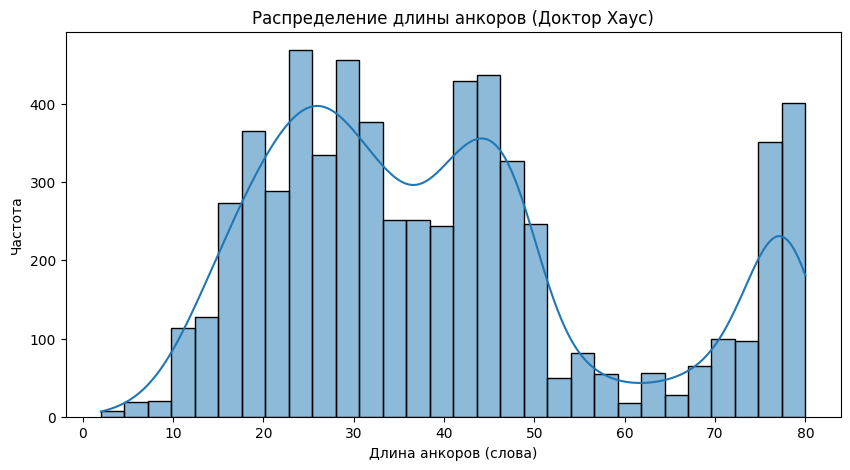

In [12]:
# –§—É–Ω–∫—Ü–∏—è –¥–ª—è –ø–æ–¥—Å—á–µ—Ç–∞ —Å–ª–æ–≤
def count_words(text):
    return len(text.split())

# –§—É–Ω–∫—Ü–∏—è –¥–ª—è —Ä–∞–∑–¥–µ–ª–µ–Ω–∏—è –Ω–∞ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è
def split_sentences(text):
    return re.split(r'(?<=[.!?])\s+', text.strip())

# –°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –ø–æ —Å–ø–æ—Å–æ–±—É —Å–æ–∑–¥–∞–Ω–∏—è –∞–Ω–∫–æ—Ä–æ–≤
stats = {
    "simple_copy": 0,
    "truncated": 0,
    "context_1_added": 0,
    "context_2_added": 0,
    "context_3_added": 0,
    "context_4_added": 0,
    "context_5_added": 0,
    "prev_in_context_ignored": 0,
    "problematic_cases": 0,
    "response_removed": 0,
    "response_removed_after_context": 0  # –î–æ–±–∞–≤–ª–µ–Ω –∫–ª—é—á
}

# –°–ø–∏—Å–∫–∏ –¥–ª—è –ø—Ä–æ–±–ª–µ–º–Ω—ã—Ö —Å–ª—É—á–∞–µ–≤
long_unprocessed = []  # –î–ª–∏–Ω–Ω—ã–µ previous_line, –∫–æ—Ç–æ—Ä—ã–µ –Ω–µ —É–¥–∞–ª–æ—Å—å –æ–±—Ä–µ–∑–∞—Ç—å
short_unprocessed = []  # –ö–æ—Ä–æ—Ç–∫–∏–µ, –∫–æ—Ç–æ—Ä—ã–º –Ω–µ —Ö–≤–∞—Ç–∏–ª–æ –∫–æ–Ω—Ç–µ–∫—Å—Ç–∞


def truncate_long_anchor(text, max_words=75):
    """–û–±—Ä–µ–∑–∞–µ—Ç –∞–Ω–∫–æ—Ä –¥–æ `max_words`, –Ω–∞—á–∏–Ω–∞—è —Å –∫–æ–Ω—Ü–∞."""
    if not isinstance(text, str) or len(text) == 0:
        return ""

    sentences = split_sentences(text)  # –†–∞–∑–±–∏–≤–∞–µ—Ç –Ω–∞ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è
    truncated_text = ""

    # –î–æ–±–∞–≤–ª—è–µ–º –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è —Å –∫–æ–Ω—Ü–∞, –ø–æ–∫–∞ –Ω–µ –¥–æ—Å—Ç–∏–≥–Ω–µ–º `max_words`
    for i in range(len(sentences) - 1, -1, -1):
        truncated_text = " ".join(sentences[i:] + [truncated_text]).strip()
        if count_words(truncated_text) <= max_words:
            return truncated_text

    return truncated_text  # –ï—Å–ª–∏ –Ω–∏—á–µ–≥–æ –Ω–µ –ø–æ–¥–æ—à–ª–æ, –æ—Å—Ç–∞–≤–ª—è–µ–º –∫–∞–∫ –µ—Å—Ç—å

# –§—É–Ω–∫—Ü–∏—è –æ–±—ä–µ–¥–∏–Ω–µ–Ω–∏—è –∫–æ—Ä–æ—Ç–∫–∏—Ö –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π
def merge_short_sentences(sentences, min_length=5):
    """–û–±—ä–µ–¥–∏–Ω—è–µ—Ç —Å–ª–∏—à–∫–æ–º –∫–æ—Ä–æ—Ç–∫–∏–µ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è —Å —Å–æ—Å–µ–¥–Ω–∏–º–∏."""
    merged_sentences = []
    buffer = ""

    for sent in sentences:
        if len(sent.split()) < min_length:  # –ï—Å–ª–∏ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–µ –∫–æ—Ä–æ—Ç–∫–æ–µ
            buffer += " " + sent  # –î–æ–±–∞–≤–ª—è–µ–º –≤ –±—É—Ñ–µ—Ä
        else:
            if buffer:
                merged_sentences.append(buffer.strip() + " " + sent)  # –û–±—ä–µ–¥–∏–Ω—è–µ–º —Å –ø—Ä–µ–¥—ã–¥—É—â–∏–º–∏
                buffer = ""  # –û—á–∏—â–∞–µ–º –±—É—Ñ–µ—Ä
            else:
                merged_sentences.append(sent)  # –î–æ–±–∞–≤–ª—è–µ–º –Ω–æ—Ä–º–∞–ª—å–Ω–æ–µ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–µ

    # –ü—Ä–æ–≤–µ—Ä—è–µ–º, –µ—Å—Ç—å –ª–∏ –¥–∞–Ω–Ω—ã–µ –≤ merged_sentences –ø–µ—Ä–µ–¥ –¥–æ–±–∞–≤–ª–µ–Ω–∏–µ–º buffer
    if buffer and merged_sentences:
        merged_sentences[-1] += " " + buffer  # –î–æ–±–∞–≤–ª—è–µ–º –æ—Å—Ç–∞–≤—à–∏–π—Å—è –±—É—Ñ–µ—Ä –∫ –ø–æ—Å–ª–µ–¥–Ω–µ–º—É –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—é
    elif buffer:  # –ï—Å–ª–∏ buffer –µ—Å—Ç—å, –Ω–æ merged_sentences –ø—É—Å—Ç, –ø—Ä–æ—Å—Ç–æ –¥–æ–±–∞–≤–ª—è–µ–º buffer
        merged_sentences.append(buffer.strip())

    return merged_sentences

def remove_duplicate_sentences(text):
    """–£–¥–∞–ª—è–µ—Ç –ø–æ–≤—Ç–æ—Ä—è—é—â–∏–µ—Å—è –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è –≤ —Ç–µ–∫—Å—Ç–µ."""
    if not isinstance(text, str) or len(text) == 0:
        return ""

    sentences = split_sentences(text)  # –†–∞–∑–±–∏–≤–∞–µ—Ç –Ω–∞ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è
    unique_sentences = list(dict.fromkeys(sentences))  # –£–±–∏—Ä–∞–µ—Ç –¥—É–±–ª–∏–∫–∞—Ç—ã, —Å–æ—Ö—Ä–∞–Ω—è—è –ø–æ—Ä—è–¥–æ–∫
    return " ".join(unique_sentences)

# –§—É–Ω–∫—Ü–∏—è —Å–æ–∑–¥–∞–Ω–∏—è –∞–Ω–∫–æ—Ä–æ–≤ —Å —É—á–µ—Ç–æ–º –∫–æ—Ä–æ—Ç–∫–∏—Ö –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π
def create_anchor(row):
    """–°–æ–∑–¥–∞–µ—Ç –∞–Ω–∫–æ—Ä–Ω—É—é —Ä–µ–ø–ª–∏–∫—É —Å —É—á–µ—Ç–æ–º –∫–æ–Ω—Ç–µ–∫—Å—Ç–∞, —É–¥–∞–ª–µ–Ω–∏—è –¥—É–±–ª–∏–∫–∞—Ç–æ–≤ –∏ –∫–æ—Ä–æ—Ç–∫–∏—Ö –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π."""
    min_words, max_words = 50, 75
    soft_min, soft_max = 40, 80
    previous = row.get("previous_line", "")
    response = row.get("line", "")
    context_columns = ["context_1", "context_2", "context_3", "context_4", "context_5"]

    # –ï—Å–ª–∏ previous_line —É–∂–µ –µ—Å—Ç—å –≤ context_1, –∑–∞–º–µ–Ω—è–µ—Ç—Å—è
    if pd.notna(row["context_1"]) and pd.notna(previous) and previous in row["context_1"]:
        previous = row["context_1"]
        stats["prev_in_context_ignored"] += 1

    # –ü—Ä–æ–≤–µ—Ä–∫–∞ –Ω–∞–ª–∏—á–∏—è —Ç–µ–∫—Å—Ç–∞
    if pd.isna(previous) or count_words(previous) == 0:
        stats["problematic_cases"] += 1
        short_unprocessed.append(row.to_dict())
        return None

    # –£–¥–∞–ª–µ–Ω–∏–µ `response` –∏–∑ `previous`
    if response in previous:
        previous = previous.replace(response, "").strip()
        stats["response_removed"] += 1

    # –û—á–∏—Å—Ç–∫–∞ –ø–æ–≤—Ç–æ—Ä—è—é—â–∏—Ö—Å—è –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π
    previous = remove_duplicate_sentences(previous)

    # –†–∞–∑–±–∏–µ–Ω–∏–µ –Ω–∞ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è –∏ –æ–±—Ä–∞–±–æ—Ç–∫–∞ –∫–æ—Ä–æ—Ç–∫–∏—Ö
    sentences = split_sentences(previous)
    sentences = merge_short_sentences(sentences)

    # –û–±—ä–µ–¥–∏–Ω–µ–Ω–∏–µ –≤ —Ç–µ–∫—Å—Ç
    previous = " ".join(sentences)
    words_count = count_words(previous)

    # –ü—Ä–æ–≤–µ—Ä–∫–∞ –¥–ª–∏–Ω—ã –ø–æ—Å–ª–µ –æ—á–∏—Å—Ç–∫–∏
    if min_words <= words_count <= max_words:
        stats["simple_copy"] += 1
        return previous

    # –ï—Å–ª–∏ —Å–ª–∏—à–∫–æ–º –¥–ª–∏–Ω–Ω—ã–π, –æ—Ç—Å–µ–∫–∞–µ–º –ø–æ—Å–ª–µ–¥–Ω–∏–µ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è
    if words_count > max_words:
        previous = truncate_long_anchor(previous)
        words_count = count_words(previous)

    # –ï—Å–ª–∏ previous_line –∫–æ—Ä–æ—Ç–∫–∏–π, –¥–æ–±–∞–≤–ª—è–µ—Ç—Å—è –∫–æ–Ω—Ç–µ–∫—Å—Ç
    full_context = [previous]

    for i, col in enumerate(context_columns, start=1):
        if col in row and pd.notna(row[col]):
            full_context.append(row[col])
            combined_text = " ".join(full_context)
            combined_words = count_words(combined_text)

            # –û—á–∏—Å—Ç–∫–∞ –ø–æ–≤—Ç–æ—Ä–æ–≤ –∏ —É–¥–∞–ª–µ–Ω–∏—è `response`
            combined_text = remove_duplicate_sentences(combined_text)
            if response in combined_text:
                combined_text = combined_text.replace(response, "").strip()
                stats["response_removed_after_context"] += 1

            if min_words <= combined_words <= max_words:
                stats[f"context_{i}_added"] += 1
                return combined_text

            if combined_words > soft_max:
                prev_words = count_words(" ".join(full_context[:-1]))
                if soft_min <= prev_words <= soft_max:
                    stats[f"context_{i}_added"] += 1
                    return " ".join(full_context[:-1])

                # –û–±—Ä–µ–∑–∫–∞ –ø–æ—Å–ª–µ–¥–Ω–µ–≥–æ –¥–æ–±–∞–≤–ª–µ–Ω–Ω–æ–≥–æ –∫–æ–Ω—Ç–µ–∫—Å—Ç–∞
                sentences = split_sentences(row[col])
                sentences = merge_short_sentences(sentences)  # –û–±—ä–µ–¥–∏–Ω–µ–Ω–∏–µ –∫–æ—Ä–æ—Ç–∫–∏—Ö
                for j in range(len(sentences) - 1, -1, -1):
                    truncated_text = " ".join(full_context[:-1]) + " " + " ".join(sentences[:j])
                    truncated_words = count_words(truncated_text)

                    if soft_min <= truncated_words <= soft_max:
                        stats[f"context_{i}_added"] += 1
                        return truncated_text

                stats["problematic_cases"] += 1
                short_unprocessed.append(row.to_dict())
                return None

    stats["problematic_cases"] += 1
    short_unprocessed.append(row.to_dict())
    return None

# –ü—Ä–∏–º–µ–Ω–µ–Ω–∏–µ –æ–±–Ω–æ–≤–ª–µ–Ω–Ω–æ–≥–æ –º–µ—Ç–æ–¥–∞
house_df["anchor"] = house_df.apply(create_anchor, axis=1)

# –í—ã–≤–æ–¥ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏
print("–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ —Ñ–æ—Ä–º–∏—Ä–æ–≤–∞–Ω–∏—è –∞–Ω–∫–æ—Ä–æ–≤:")
for key, value in stats.items():
    print(f"- {key.replace('_', ' ').capitalize()}: {value}")

# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è
plt.figure(figsize=(10, 5))
sns.histplot(house_df["anchor"].dropna().apply(count_words), bins=30, kde=True)
plt.xlabel("–î–ª–∏–Ω–∞ –∞–Ω–∫–æ—Ä–æ–≤ (—Å–ª–æ–≤–∞)")
plt.ylabel("–ß–∞—Å—Ç–æ—Ç–∞")
plt.title("–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –¥–ª–∏–Ω—ã –∞–Ω–∫–æ—Ä–æ–≤ (–î–æ–∫—Ç–æ—Ä –•–∞—É—Å)")
plt.show()


–û–±–Ω–æ–≤–ª–µ–Ω–Ω–∞—è —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –¥–ª–∏–Ω—ã –∞–Ω–∫–æ—Ä–æ–≤:
count    6341.000000
mean       73.389213
std        23.576640
min         3.000000
25%        56.000000
50%        72.000000
75%        82.000000
max       227.000000
Name: anchor_length, dtype: float64


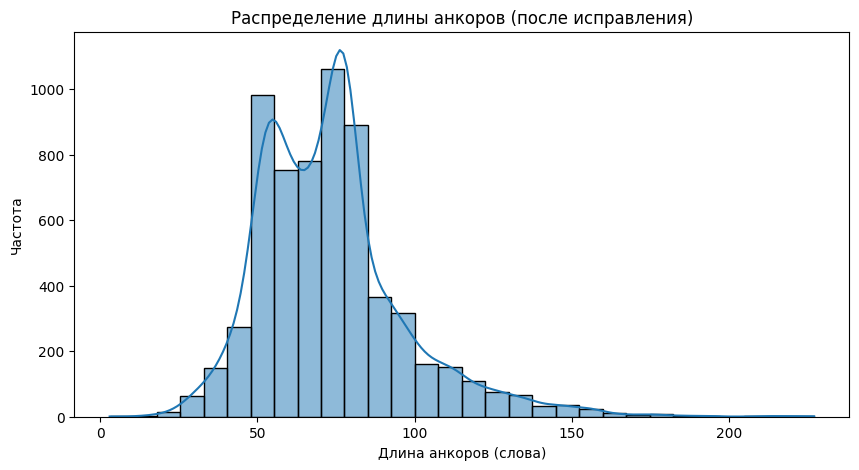

In [13]:
def improve_short_anchors(row, min_words=50):
    """–î–æ–ø–æ–ª–Ω—è–µ—Ç –∫–æ—Ä–æ—Ç–∫–∏–µ –∞–Ω–∫–æ—Ä—ã –∫–æ–Ω—Ç–µ–∫—Å—Ç–æ–º, —É–¥–∞–ª—è–µ—Ç –ø–æ–≤—Ç–æ—Ä–µ–Ω–∏—è –∏ –æ—Ç–≤–µ—Ç."""
    anchor = row["anchor"]
    response = row["line"]
    context_long = row.get("context_long", "")  # –î–ª–∏–Ω–Ω—ã–π –∫–æ–Ω—Ç–µ–∫—Å—Ç

    # –ï—Å–ª–∏ –∞–Ω–∫–æ—Ä —É–∂–µ –¥–æ—Å—Ç–∞—Ç–æ—á–Ω–æ –¥–ª–∏–Ω–Ω—ã–π, –æ—Å—Ç–∞–≤–ª—è–µ–º –∫–∞–∫ –µ—Å—Ç—å
    if count_words(anchor) >= min_words:
        return anchor

    # –î–æ–±–∞–≤–ª—è–µ–º –∫–æ–Ω—Ç–µ–∫—Å—Ç, –µ—Å–ª–∏ –æ–Ω –µ—Å—Ç—å
    if pd.notna(context_long):
        anchor += " " + context_long

    # –£–¥–∞–ª–µ–Ω–∏–µ –¥—É–±–ª–∏–∫–∞—Ç–æ–≤
    anchor = remove_duplicate_sentences(anchor)

    # –£–¥–∞–ª–µ–Ω–∏–µ –æ—Ç–≤–µ—Ç–∞, –µ—Å–ª–∏ –æ–Ω –ø–æ–ø–∞–ª –≤ –∞–Ω–∫–æ—Ä
    if response in anchor:
        anchor = anchor.replace(response, "").strip()

    # –ü–æ–≤—Ç–æ—Ä–Ω–∞—è –ø—Ä–æ–≤–µ—Ä–∫–∞ –¥–ª–∏–Ω—ã
    if count_words(anchor) < min_words and pd.notna(row["previous_line"]):
        anchor = row["previous_line"] + " " + anchor

    return anchor

# –ü—Ä–∏–º–µ–Ω–µ–Ω–∏–µ —É–ª—É—á—à–µ–Ω–∏—è –∫ –∫–æ—Ä–æ—Ç–∫–∏–º –∞–Ω–∫–æ—Ä–∞–º
house_df["anchor"] = house_df.apply(improve_short_anchors, axis=1)

# –ü–æ–≤—Ç–æ—Ä–Ω–∞—è –ø—Ä–æ–≤–µ—Ä–∫–∞ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏
print("–û–±–Ω–æ–≤–ª–µ–Ω–Ω–∞—è —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –¥–ª–∏–Ω—ã –∞–Ω–∫–æ—Ä–æ–≤:")
house_df["anchor_length"] = house_df["anchor"].apply(count_words)
print(house_df["anchor_length"].describe())

# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è
plt.figure(figsize=(10, 5))
sns.histplot(house_df["anchor_length"], bins=30, kde=True)
plt.xlabel("–î–ª–∏–Ω–∞ –∞–Ω–∫–æ—Ä–æ–≤ (—Å–ª–æ–≤–∞)")
plt.ylabel("–ß–∞—Å—Ç–æ—Ç–∞")
plt.title("–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –¥–ª–∏–Ω—ã –∞–Ω–∫–æ—Ä–æ–≤ (–ø–æ—Å–ª–µ –∏—Å–ø—Ä–∞–≤–ª–µ–Ω–∏—è)")
plt.show()

–û–±–Ω–æ–≤–ª–µ–Ω–Ω–∞—è —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –¥–ª–∏–Ω—ã –∞–Ω–∫–æ—Ä–æ–≤:
count    6341.000000
mean       70.606214
std        18.644676
min        15.000000
25%        58.000000
50%        71.000000
75%        80.000000
max       282.000000
Name: anchor_length, dtype: float64


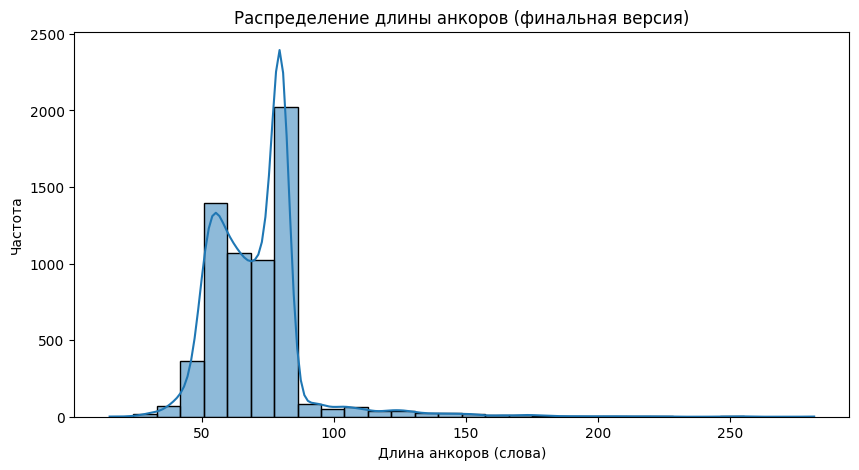

In [14]:
def truncate_long_anchor(text, max_words=80):
    """–û–±—Ä–µ–∑–∞–µ—Ç –∞–Ω–∫–æ—Ä –¥–æ `max_words`, –Ω–∞—á–∏–Ω–∞—è —Å –Ω–∞—á–∞–ª–∞, —á—Ç–æ–±—ã —Å–æ—Ö—Ä–∞–Ω–∏—Ç—å –ø–æ—Å–ª–µ–¥–Ω–∏–µ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è."""
    if not isinstance(text, str) or len(text) == 0:
        return ""

    words = text.split()
    if len(words) > max_words:
        return " ".join(words[-max_words:])  # –ë–µ—Ä–µ–º –ø–æ—Å–ª–µ–¥–Ω–∏–µ `max_words` —Å–ª–æ–≤

    return text  # –ï—Å–ª–∏ —Ç–µ–∫—Å—Ç —É–∂–µ –≤ –ø—Ä–µ–¥–µ–ª–∞—Ö –Ω–æ—Ä–º—ã, –Ω–µ –æ–±—Ä–µ–∑–∞–µ–º

def improve_anchor(row, min_words=50, max_words=80):
    """–û–ø—Ç–∏–º–∏–∑–∏—Ä—É–µ—Ç –∞–Ω–∫–æ—Ä—ã: —Å–æ–∫—Ä–∞—â–∞–µ—Ç –¥–ª–∏–Ω–Ω—ã–µ, –¥–æ–±–∞–≤–ª—è–µ—Ç –∫–æ–Ω—Ç–µ–∫—Å—Ç –¥–ª—è –∫–æ—Ä–æ—Ç–∫–∏—Ö, —É–¥–∞–ª—è–µ—Ç –ø–æ–≤—Ç–æ—Ä—ã –∏ –æ—Ç–≤–µ—Ç—ã."""
    anchor = row["anchor"]
    response = row["line"]
    context_long = row.get("context_long", "")  # –î–ª–∏–Ω–Ω—ã–π –∫–æ–Ω—Ç–µ–∫—Å—Ç

    # –£–¥–∞–ª–µ–Ω–∏–µ –¥—É–±–ª–∏–∫–∞—Ç–æ–≤
    anchor = remove_duplicate_sentences(anchor)

    # –£–¥–∞–ª–µ–Ω–∏–µ –æ—Ç–≤–µ—Ç–∞, –∑–∞–º–µ–Ω—è—è –Ω–∞ "..."
    if response in anchor:
        anchor = anchor.replace(response, "...").strip()
        stats["response_removed_after_context"] += 1

    words_count = count_words(anchor)

    # –û–±—Ä–µ–∑–∫–∞ —Å–ª–∏—à–∫–æ–º –¥–ª–∏–Ω–Ω—ã—Ö –∞–Ω–∫–æ—Ä–æ–≤ (–±–µ—Ä–µ–º –ø–æ—Å–ª–µ–¥–Ω–∏–µ 80 —Å–ª–æ–≤)
    if words_count > max_words:
        anchor = truncate_long_anchor(anchor, max_words)

    # –ï—Å–ª–∏ –∞–Ω–∫–æ—Ä —Å–ª–∏—à–∫–æ–º –∫–æ—Ä–æ—Ç–∫–∏–π, –¥–æ–±–∞–≤–ª—è–µ–º –∫–æ–Ω—Ç–µ–∫—Å—Ç
    if words_count < min_words and pd.notna(context_long):
        anchor += " " + context_long
        anchor = remove_duplicate_sentences(anchor)

    return anchor

# –ü—Ä–∏–º–µ–Ω–µ–Ω–∏–µ —É–ª—É—á—à–µ–Ω–∏–π –∫ –∞–Ω–∫–æ—Ä–∞–º
house_df["anchor"] = house_df.apply(improve_anchor, axis=1)

# –ü–æ–≤—Ç–æ—Ä–Ω–∞—è –ø—Ä–æ–≤–µ—Ä–∫–∞ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏
print("–û–±–Ω–æ–≤–ª–µ–Ω–Ω–∞—è —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –¥–ª–∏–Ω—ã –∞–Ω–∫–æ—Ä–æ–≤:")
house_df["anchor_length"] = house_df["anchor"].apply(count_words)
print(house_df["anchor_length"].describe())

# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è
plt.figure(figsize=(10, 5))
sns.histplot(house_df["anchor_length"], bins=30, kde=True)
plt.xlabel("–î–ª–∏–Ω–∞ –∞–Ω–∫–æ—Ä–æ–≤ (—Å–ª–æ–≤–∞)")
plt.ylabel("–ß–∞—Å—Ç–æ—Ç–∞")
plt.title("–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –¥–ª–∏–Ω—ã –∞–Ω–∫–æ—Ä–æ–≤ (—Ñ–∏–Ω–∞–ª—å–Ω–∞—è –≤–µ—Ä—Å–∏—è)")
plt.show()


–§–∏–Ω–∞–ª—å–Ω–∞—è —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –¥–ª–∏–Ω—ã –∞–Ω–∫–æ—Ä–æ–≤:
count    6341.000000
mean       66.114493
std        13.148874
min        16.000000
25%        54.000000
50%        68.000000
75%        80.000000
max        80.000000
Name: anchor_length, dtype: float64


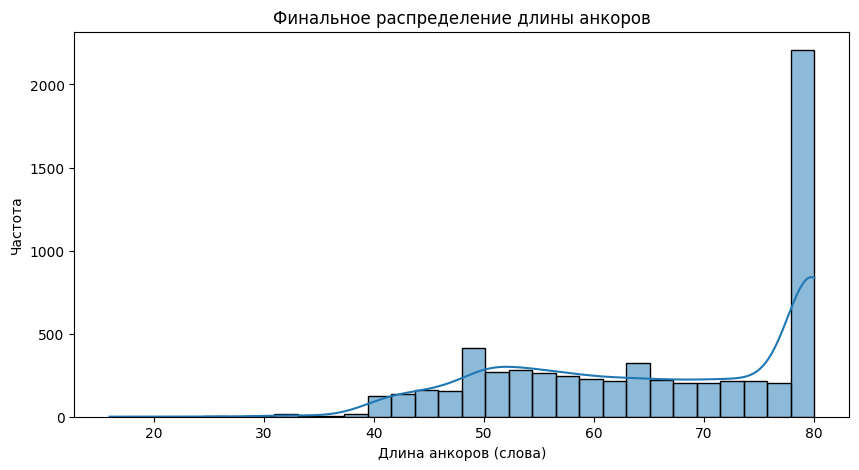

In [15]:
def truncate_long_anchor(text, max_words=80):
    """–û–±—Ä–µ–∑–∞–µ—Ç –∞–Ω–∫–æ—Ä –¥–æ `max_words`, –Ω–∞—á–∏–Ω–∞—è —Å –Ω–∞—á–∞–ª–∞, —á—Ç–æ–±—ã —Å–æ—Ö—Ä–∞–Ω–∏—Ç—å –ø–æ—Å–ª–µ–¥–Ω–∏–µ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è."""
    words = text.split()
    return " ".join(words[-max_words:]) if len(words) > max_words else text

def improve_anchor(row, min_words=40, max_words=80):
    """–û–ø—Ç–∏–º–∏–∑–∏—Ä—É–µ—Ç –∞–Ω–∫–æ—Ä—ã: —Å–æ–∫—Ä–∞—â–∞–µ—Ç –¥–ª–∏–Ω–Ω—ã–µ, –¥–æ–±–∞–≤–ª—è–µ—Ç –∫–æ–Ω—Ç–µ–∫—Å—Ç –¥–ª—è –∫–æ—Ä–æ—Ç–∫–∏—Ö, —É–¥–∞–ª—è–µ—Ç –ø–æ–≤—Ç–æ—Ä—ã –∏ –æ—Ç–≤–µ—Ç—ã."""
    anchor = row["anchor"]
    response = row["line"]
    context_long = row.get("context_long", "")

    # –£–¥–∞–ª–µ–Ω–∏–µ –¥—É–±–ª–∏–∫–∞—Ç–æ–≤
    anchor = remove_duplicate_sentences(anchor)

    # –£–¥–∞–ª–µ–Ω–∏–µ –æ—Ç–≤–µ—Ç–∞, –∑–∞–º–µ–Ω—è—è –Ω–∞ "..."
    if response in anchor:
        anchor = anchor.replace(response, "...").strip()
        stats["response_removed_after_context"] += 1

    words_count = count_words(anchor)

    # –û–±—Ä–µ–∑–∫–∞ —Å–ª–∏—à–∫–æ–º –¥–ª–∏–Ω–Ω—ã—Ö –∞–Ω–∫–æ—Ä–æ–≤
    if words_count > max_words:
        anchor = truncate_long_anchor(anchor, max_words)

    # –ï—Å–ª–∏ –∞–Ω–∫–æ—Ä —Å–ª–∏—à–∫–æ–º –∫–æ—Ä–æ—Ç–∫–∏–π, –¥–æ–±–∞–≤–ª—è–µ—Ç—Å—è –∫–æ–Ω—Ç–µ–∫—Å—Ç
    if words_count < min_words and pd.notna(context_long):
        anchor += " " + context_long
        anchor = remove_duplicate_sentences(anchor)

        # –ü–æ–≤—Ç–æ—Ä–Ω–∞—è –ø—Ä–æ–≤–µ—Ä–∫–∞ –ø–æ—Å–ª–µ –¥–æ–±–∞–≤–ª–µ–Ω–∏—è –∫–æ–Ω—Ç–µ–∫—Å—Ç–∞
        if count_words(anchor) > max_words:
            anchor = truncate_long_anchor(anchor, max_words)

    return anchor

# –ü—Ä–∏–º–µ–Ω–µ–Ω–∏–µ —Ñ–∏–Ω–∞–ª—å–Ω–æ–π –≤–µ—Ä—Å–∏–∏ —É–ª—É—á—à–µ–Ω–∏—è –∞–Ω–∫–æ—Ä–æ–≤
house_df["anchor"] = house_df.apply(improve_anchor, axis=1)

# –ü–æ–≤—Ç–æ—Ä–Ω–∞—è –ø—Ä–æ–≤–µ—Ä–∫–∞ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏
print("–§–∏–Ω–∞–ª—å–Ω–∞—è —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –¥–ª–∏–Ω—ã –∞–Ω–∫–æ—Ä–æ–≤:")
house_df["anchor_length"] = house_df["anchor"].apply(count_words)
print(house_df["anchor_length"].describe())

# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è
plt.figure(figsize=(10, 5))
sns.histplot(house_df["anchor_length"], bins=30, kde=True)
plt.xlabel("–î–ª–∏–Ω–∞ –∞–Ω–∫–æ—Ä–æ–≤ (—Å–ª–æ–≤–∞)")
plt.ylabel("–ß–∞—Å—Ç–æ—Ç–∞")
plt.title("–§–∏–Ω–∞–ª—å–Ω–æ–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –¥–ª–∏–Ω—ã –∞–Ω–∫–æ—Ä–æ–≤")
plt.show()

–§–∏–Ω–∞–ª—å–Ω–∞—è —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –¥–ª–∏–Ω—ã –∞–Ω–∫–æ—Ä–æ–≤ (—Å –∫–æ—Ä—Ä–µ–∫—Ç–∏—Ä–æ–≤–∫–æ–π min/max):
count    6341.000000
mean       65.580192
std        13.786214
min        16.000000
25%        54.000000
50%        68.000000
75%        80.000000
max        85.000000
Name: anchor_length, dtype: float64


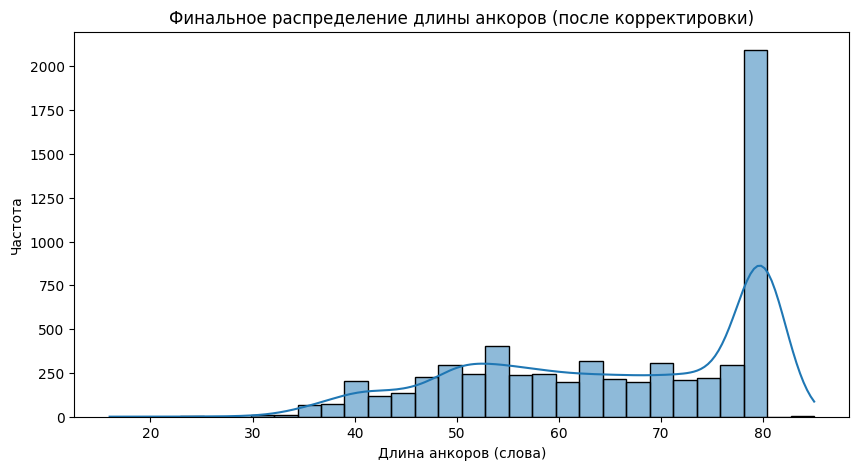

In [16]:
def improve_anchor_final(row, min_words=35, max_words=85):
    """–ì–∞—Ä–∞–Ω—Ç–∏—Ä—É–µ—Ç, —á—Ç–æ –∞–Ω–∫–æ—Ä—ã –±—É–¥—É—Ç –≤ –ø—Ä–µ–¥–µ–ª–∞—Ö –æ—Ç min_words –¥–æ max_words."""
    anchor = row["anchor"]
    response = row["line"]
    context_long = row.get("context_long", "")

    # –£–¥–∞–ª–µ–Ω–∏–µ –¥—É–±–ª–∏–∫–∞—Ç–æ–≤
    anchor = remove_duplicate_sentences(anchor)

    # –£–¥–∞–ª–µ–Ω–∏–µ –æ—Ç–≤–µ—Ç–∞, –∑–∞–º–µ–Ω—è—è –Ω–∞ "..."
    if response in anchor:
        anchor = anchor.replace(response, "...").strip()
        stats["response_removed_after_context"] += 1

    words_count = count_words(anchor)

    # –û–±—Ä–µ–∑–∫–∞ —Å–ª–∏—à–∫–æ–º –¥–ª–∏–Ω–Ω—ã—Ö –∞–Ω–∫–æ—Ä–æ–≤
    if words_count > max_words:
        anchor = truncate_long_anchor(anchor, max_words)

    # –ï—Å–ª–∏ –∞–Ω–∫–æ—Ä —Å–ª–∏—à–∫–æ–º –∫–æ—Ä–æ—Ç–∫–∏–π, –¥–æ–±–∞–≤–ª—è–µ—Ç—Å—è –∫–æ–Ω—Ç–µ–∫—Å—Ç
    if words_count < min_words and pd.notna(context_long):
        anchor += " " + context_long
        anchor = remove_duplicate_sentences(anchor)

        # –ü–æ–≤—Ç–æ—Ä–Ω–∞—è –ø—Ä–æ–≤–µ—Ä–∫–∞ –ø–æ—Å–ª–µ –¥–æ–±–∞–≤–ª–µ–Ω–∏—è –∫–æ–Ω—Ç–µ–∫—Å—Ç–∞
        if count_words(anchor) > max_words:
            anchor = truncate_long_anchor(anchor, max_words)

    return anchor

# –ü—Ä–∏–º–µ–Ω–µ–Ω–∏–µ —Ñ–∏–Ω–∞–ª—å–Ω–æ–≥–æ —É–ª—É—á—à–µ–Ω–∏—è
house_df["anchor"] = house_df.apply(improve_anchor_final, axis=1)

# –ü—Ä–æ–≤–µ—Ä–∫–∞ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏ –ø–æ—Å–ª–µ —Ñ–∏–Ω–∞–ª—å–Ω–æ–≥–æ –∏—Å–ø—Ä–∞–≤–ª–µ–Ω–∏—è
print("–§–∏–Ω–∞–ª—å–Ω–∞—è —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –¥–ª–∏–Ω—ã –∞–Ω–∫–æ—Ä–æ–≤ (—Å –∫–æ—Ä—Ä–µ–∫—Ç–∏—Ä–æ–≤–∫–æ–π min/max):")
house_df["anchor_length"] = house_df["anchor"].apply(count_words)
print(house_df["anchor_length"].describe())

# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è
plt.figure(figsize=(10, 5))
sns.histplot(house_df["anchor_length"], bins=30, kde=True)
plt.xlabel("–î–ª–∏–Ω–∞ –∞–Ω–∫–æ—Ä–æ–≤ (—Å–ª–æ–≤–∞)")
plt.ylabel("–ß–∞—Å—Ç–æ—Ç–∞")
plt.title("–§–∏–Ω–∞–ª—å–Ω–æ–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –¥–ª–∏–Ω—ã –∞–Ω–∫–æ—Ä–æ–≤ (–ø–æ—Å–ª–µ –∫–æ—Ä—Ä–µ–∫—Ç–∏—Ä–æ–≤–∫–∏)")
plt.show()


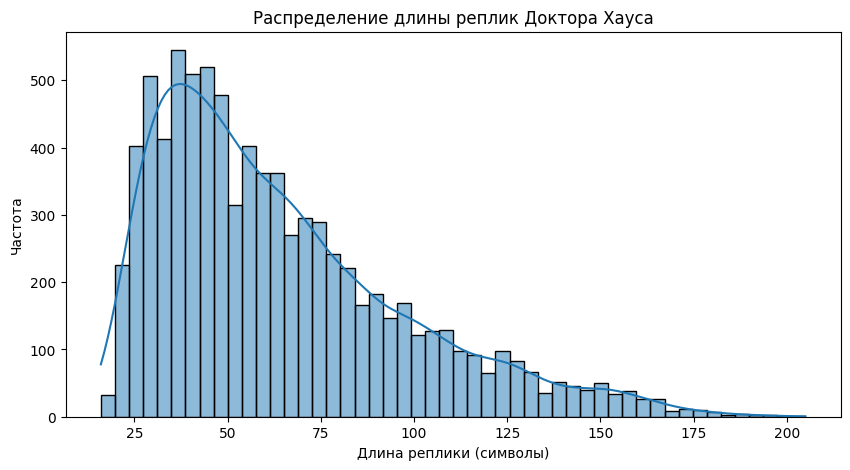

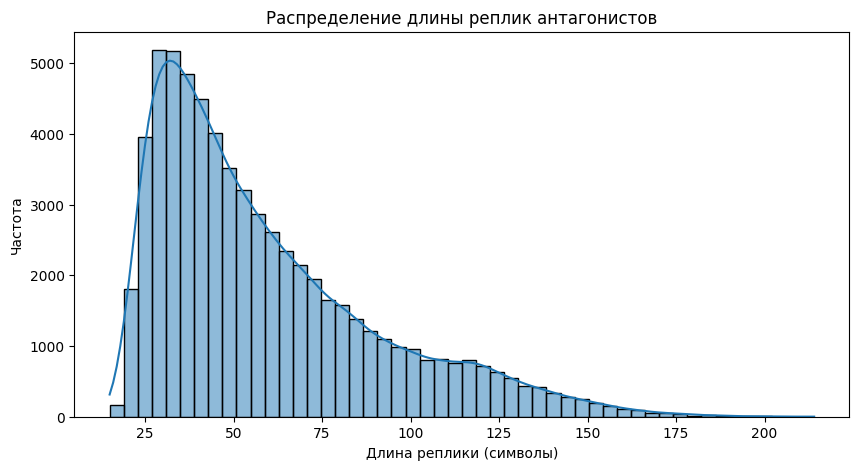

In [80]:
def plot_length_distribution(df, title):
    """
    –§—É–Ω–∫—Ü–∏—è –¥–ª—è –ø–æ—Å—Ç—Ä–æ–µ–Ω–∏—è —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –¥–ª–∏–Ω—ã —Ä–µ–ø–ª–∏–∫.

    df: DataFrame —Å –∫–æ–ª–æ–Ω–∫–æ–π "line".
    title: –ó–∞–≥–æ–ª–æ–≤–æ–∫ –≥—Ä–∞—Ñ–∏–∫–∞.
    """
    lengths = df["line"].apply(len)

    plt.figure(figsize=(10, 5))
    sns.histplot(lengths, bins=50, kde=True)
    plt.xlabel("–î–ª–∏–Ω–∞ —Ä–µ–ø–ª–∏–∫–∏ (—Å–∏–º–≤–æ–ª—ã)")
    plt.ylabel("–ß–∞—Å—Ç–æ—Ç–∞")
    plt.title(title)
    plt.show()

# –ü–æ—Å—Ç—Ä–æ–µ–Ω–∏–µ –≥—Ä–∞—Ñ–∏–∫–æ–≤
plot_length_distribution(house_df, "–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –¥–ª–∏–Ω—ã —Ä–µ–ø–ª–∏–∫ –î–æ–∫—Ç–æ—Ä–∞ –•–∞—É—Å–∞")
plot_length_distribution(antagonists_df, "–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –¥–ª–∏–Ω—ã —Ä–µ–ø–ª–∏–∫ –∞–Ω—Ç–∞–≥–æ–Ω–∏—Å—Ç–æ–≤")

In [81]:
# –ü–∞—Ä–∞–º–µ—Ç—Ä—ã –ø—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–∏
MIN_WORDS = 5  # –ú–∏–Ω–∏–º–∞–ª—å–Ω–∞—è –¥–ª–∏–Ω–∞ —Ä–µ–ø–ª–∏–∫–∏
MAX_WORDS = 30  # –ú–∞–∫—Å–∏–º–∞–ª—å–Ω–∞—è –¥–ª–∏–Ω–∞ –ø–æ—Å–ª–µ —Ä–∞–∑–±–∏–µ–Ω–∏—è –Ω–∞ —á–∞–Ω–∫–∏

def clean_text(text):
    """–ü–æ–≤—Ç–æ—Ä–Ω–∞—è –æ—á–∏—Å—Ç–∫–∞ —Ç–µ–∫—Å—Ç–∞ –æ—Ç –ø—Ä–æ–±–ª–µ–º–Ω—ã—Ö —Å–∏–º–≤–æ–ª–æ–≤, –ª–∏—à–Ω–∏—Ö –ø—Ä–æ–±–µ–ª–æ–≤ –∏ —ç–º–æ–¥–∑–∏."""
    if not isinstance(text, str) or len(text) == 0:
        return ""

    text = text.replace("ÔøΩ", "")
    text = re.sub(r"\s+", " ", text).strip()
    text = re.sub(r"[^\x00-\x7F]+", "", text)

    return text

def split_into_chunks(text, min_words=MIN_WORDS, max_words=MAX_WORDS):
    """
    –†–∞–∑–±–∏–≤–∞–µ—Ç —Ç–µ–∫—Å—Ç –Ω–∞ —á–∞–Ω–∫–∏, —Å –ø—Ä–∏–æ—Ä–∏—Ç–µ—Ç–æ–º —Ä–∞–∑–±–∏–µ–Ω–∏—è –ø–æ —Ç–æ—á–∫–µ (.), –∑–∞—Ç–µ–º –ø–æ !?.
    –ï—Å–ª–∏ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–µ —Å–ª–∏—à–∫–æ–º –¥–ª–∏–Ω–Ω–æ–µ, –¥–µ–ª–∏—Ç—Å—è –Ω–∞ —Ä–∞–≤–Ω—ã–µ —á–∞—Å—Ç–∏, –Ω–æ –Ω–µ –º–µ–Ω–µ–µ min_words –≤ —á–∞–Ω–∫–µ.
    """
    if not isinstance(text, str) or len(text) == 0:
        return []

    # –†–∞–∑–¥–µ–ª–µ–Ω–∏–µ —Å –ø—Ä–∏–æ—Ä–∏—Ç–µ—Ç–æ–º: —Å–Ω–∞—á–∞–ª–∞ `.`, –∑–∞—Ç–µ–º `!?`
    sentences = re.split(r'([.])\s+', text)  # –°–Ω–∞—á–∞–ª–∞ –ø–æ —Ç–æ—á–∫–µ
    sentences = ["".join(sentences[i:i+2]) for i in range(0, len(sentences), 2)]
    sentences = sum([re.split(r'([!?])\s+', s) for s in sentences], [])  # –î–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω–æ –ø–æ `!?`
    sentences = ["".join(sentences[i:i+2]) for i in range(0, len(sentences), 2)]

    # –û–±—ä–µ–¥–∏–Ω–µ–Ω–∏–µ —Å–ª–∏—à–∫–æ–º –∫–æ—Ä–æ—Ç–∫–∏—Ö –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π
    chunks = []
    buffer = []

    for sentence in sentences:
        words = sentence.split()

        if len(words) > max_words:  # –ï—Å–ª–∏ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–µ > max_words, –¥–µ–ª–∏–º –≤—Ä—É—á–Ω—É—é
            for i in range(0, len(words), max_words):
                chunks.append(" ".join(words[i:i + max_words]))
        else:
            buffer.extend(words)

            if len(buffer) >= min_words:  # –ï—Å–ª–∏ –Ω–∞–∫–æ–ø–∏–ª–∏ –¥–æ—Å—Ç–∞—Ç–æ—á–Ω–æ —Å–ª–æ–≤, —Ñ–∏–∫—Å–∏—Ä—É–µ–º —á–∞–Ω–∫
                chunks.append(" ".join(buffer))
                buffer = []

    if buffer:
        chunks.append(" ".join(buffer))

    return chunks

def process_dataframe(df, name):
    """
    –û–±—Ä–∞–±–æ—Ç–∫–∞ –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–∞, –∑–∞–º–µ–Ω—è—è –¥–ª–∏–Ω–Ω—ã–µ —Ä–µ–ø–ª–∏–∫–∏ –∏—Ö —á–∞–Ω–∫–∞–º–∏.
    """
    initial_count = len(df)
    avg_length_before = df["line"].str.split().str.len().mean()

    # –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Å–ª–∏—à–∫–æ–º –∫–æ—Ä–æ—Ç–∫–∏—Ö —Ä–µ–ø–ª–∏–∫
    df["num_words"] = df["line"].str.split().str.len()
    long_replies = df[df["num_words"] > MAX_WORDS]
    short_replies = df[df["num_words"] <= MAX_WORDS]

    print(f"\n–û–±—Ä–∞–±–æ—Ç–∫–∞ {name}: –ò—Å—Ö–æ–¥–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—Ç—Ä–æ–∫: {initial_count}")
    print(f"–°—Ä–µ–¥–Ω—è—è –¥–ª–∏–Ω–∞ —Ä–µ–ø–ª–∏–∫–∏ –¥–æ —Ä–∞–∑–±–∏–µ–Ω–∏—è: {avg_length_before:.2f} —Å–ª–æ–≤")
    print(f"–†–µ–ø–ª–∏–∫ –¥–ª–∏–Ω–Ω–µ–µ {MAX_WORDS} —Å–ª–æ–≤: {len(long_replies)}")

    # –†–∞–∑–¥–µ–ª–µ–Ω–∏–µ –¥–ª–∏–Ω–Ω—ã—Ö —Å—Ç—Ä–æ–∫–∏ –Ω–∞ —á–∞–Ω–∫–∏, —Å–æ—Ö—Ä–∞–Ω—è—è –≤—Å–µ –¥–∞–Ω–Ω—ã–µ —Å—Ç—Ä–æ–∫–∏
    expanded_data = []
    for _, row in long_replies.iterrows():
        text_chunks = split_into_chunks(row["line"])
        for chunk in text_chunks:
            if len(chunk.split()) >= MIN_WORDS:  # –ò—Å–∫–ª—é—á–∞–µ–º —Å–ª–∏—à–∫–æ–º –∫–æ—Ä–æ—Ç–∫–∏–µ —á–∞–Ω–∫–∏
                new_row = row.copy()
                new_row["line"] = chunk
                expanded_data.append(new_row)

    # –°–æ–∑–¥–∞–Ω–∏–µ –Ω–æ–≤–æ–≥–æ –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–∞ —Å –æ–±–Ω–æ–≤–ª–µ–Ω–Ω—ã–º–∏ —Ä–µ–ø–ª–∏–∫–∞–º–∏
    expanded_df = pd.DataFrame(expanded_data)

    # –û–±—ä–µ–¥–∏–Ω–µ–Ω–∏–µ –∫–æ—Ä–æ—Ç–∫–∏—Ö –∏ —Ä–∞–∑–¥–µ–ª–µ–Ω–Ω—ã—Ö —Ä–µ–ø–ª–∏–∫
    df = pd.concat([short_replies, expanded_df], ignore_index=True)

    # –£–¥–∞–ª–µ–Ω–∏–µ —Ä–µ–ø–ª–∏–∫ –º–µ–Ω–µ–µ 5 —Å–ª–æ–≤
    df = df[df["line"].str.split().str.len() >= MIN_WORDS].reset_index(drop=True)

    # –§–∏–Ω–∞–ª—å–Ω—ã–µ –≤—ã—á–∏—Å–ª–µ–Ω–∏—è
    final_count = len(df)
    avg_length_after = df["line"].str.split().str.len().mean()
    num_new_rows = final_count - initial_count

    print(f"\n–û–±—Ä–∞–±–æ—Ç–∫–∞ {name}:")
    print(f"- –î–ª–∏–Ω–∞ –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–∞ –¥–æ —Ä–∞–∑–±–∏–µ–Ω–∏—è: {initial_count}")
    print(f"- –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–æ–≤—ã—Ö —Å—Ç—Ä–æ–∫: {num_new_rows}")
    print(f"- –ò—Ç–æ–≥–æ–≤–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—Ç—Ä–æ–∫: {final_count}")
    print(f"- –°—Ä–µ–¥–Ω—è—è –¥–ª–∏–Ω–∞ —Ä–µ–ø–ª–∏–∫–∏ –ø–æ—Å–ª–µ —Ä–∞–∑–±–∏–µ–Ω–∏—è: {avg_length_after:.2f} —Å–ª–æ–≤")

    # –ü—Ä–æ–≤–µ—Ä–∫–∞, –æ—Å—Ç–∞–ª–∏—Å—å –ª–∏ –µ—â–µ –¥–ª–∏–Ω–Ω—ã–µ —Ä–µ–ø–ª–∏–∫–∏ –ø–æ—Å–ª–µ —Ä–∞–∑–±–∏–µ–Ω–∏—è
    long_after = df[df["line"].str.split().str.len() > MAX_WORDS]
    if not long_after.empty:
        print("\n–û—Å—Ç–∞–ª–∏—Å—å —Ä–µ–ø–ª–∏–∫–∏ –¥–ª–∏–Ω–Ω–µ–µ 30 —Å–ª–æ–≤! –ü—Ä–∏–Ω—É–¥–∏—Ç–µ–ª—å–Ω–æ–µ —Ä–∞–∑–±–∏–µ–Ω–∏–µ:")
        df["line"] = df["line"].apply(lambda text: split_into_chunks(text, min_words=MIN_WORDS, max_words=MAX_WORDS))
        df = df.explode("line").reset_index(drop=True)
        df = df[df["line"].str.split().str.len() >= MIN_WORDS]
        print("–í—Å–µ —Ä–µ–ø–ª–∏–∫–∏ —Ç–µ–ø–µ—Ä—å < 30 —Å–ª–æ–≤.")

    # –£–¥–∞–ª–µ–Ω–∏–µ –Ω–µ–Ω—É–∂–Ω—ã—Ö —Å—Ç–æ–ª–±—Ü–æ–≤
    df = df.drop(columns=["num_words"])

    return df

# –û—á–∏—Å—Ç–∫–∞ –¥–∞–Ω–Ω—ã—Ö –ø–µ—Ä–µ–¥ —Ä–∞–∑–±–∏–µ–Ω–∏–µ–º
def preprocess_dataframe(df, text_column="line", group_by_character=True):
    """–û—á–∏—Å—Ç–∫–∞ –¥–∞–Ω–Ω—ã—Ö: —É–¥–∞–ª–µ–Ω–∏–µ –ø—É—Å—Ç—ã—Ö —Å—Ç—Ä–æ–∫, –∫–æ—Ä–æ—Ç–∫–∏—Ö —Ä–µ–ø–ª–∏–∫, –≤–æ–ø—Ä–æ—Å–æ–≤, –¥—É–±–ª–∏–∫–∞—Ç–æ–≤ –∏ –ø–æ–¥–æ–∑—Ä–∏—Ç–µ–ª—å–Ω—ã—Ö —Å–∏–º–≤–æ–ª–æ–≤"""

    df = df.dropna(subset=[text_column]).reset_index(drop=True)
    df[text_column] = df[text_column].apply(clean_text)

    # –£–¥–∞–ª–µ–Ω–∏–µ —Å–ª–∏—à–∫–æ–º –∫–æ—Ä–æ—Ç–∫–∏—Ö —Ä–µ–ø–ª–∏–∫
    df = df[df[text_column].str.split().str.len() >= MIN_WORDS].reset_index(drop=True)

    # –£–¥–∞–ª–µ–Ω–∏–µ –¥—É–±–ª–∏–∫–∞—Ç–æ–≤
    df = df.drop_duplicates(subset=[text_column]).reset_index(drop=True)

    return df

# –ß–∏—Å—Ç–∏–º –∏ –æ–±—Ä–∞–±–∞—Ç—ã–≤–∞–µ–º –¥–∞–Ω–Ω—ã–µ
house_df = preprocess_dataframe(house_df, group_by_character=False)
antagonists_df = preprocess_dataframe(antagonists_df)

house_df = process_dataframe(house_df, "–î–æ–∫—Ç–æ—Ä –•–∞—É—Å")
antagonists_df = process_dataframe(antagonists_df, "–ê–Ω—Ç–∞–≥–æ–Ω–∏—Å—Ç—ã")

# –í—ã–≤–æ–¥ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏
print(f"\n–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ä–µ–ø–ª–∏–∫ –ø–æ—Å–ª–µ –æ—á–∏—Å—Ç–∫–∏: {len(house_df)} (–î–æ–∫—Ç–æ—Ä –•–∞—É—Å), {len(antagonists_df)} (–ê–Ω—Ç–∞–≥–æ–Ω–∏—Å—Ç—ã).")

# –ü—Ä–æ–≤–µ—Ä–∫–∞ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è
print("\n–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –ø–æ—Å–ª–µ –ø—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–∏:")
print(f"- –°—Ä–µ–¥–Ω—è—è –¥–ª–∏–Ω–∞ —Ä–µ–ø–ª–∏–∫ (–î–æ–∫—Ç–æ—Ä –•–∞—É—Å): {house_df['line'].str.split().str.len().mean():.2f} —Å–ª–æ–≤")
print(f"- –°—Ä–µ–¥–Ω—è—è –¥–ª–∏–Ω–∞ —Ä–µ–ø–ª–∏–∫ (–ê–Ω—Ç–∞–≥–æ–Ω–∏—Å—Ç—ã): {antagonists_df['line'].str.split().str.len().mean():.2f} —Å–ª–æ–≤")
print(f"- –ú–∏–Ω–∏–º–∞–ª—å–Ω–∞—è –¥–ª–∏–Ω–∞ —Ä–µ–ø–ª–∏–∫–∏ (–î–æ–∫—Ç–æ—Ä –•–∞—É—Å): {house_df['line'].str.split().str.len().min()} —Å–ª–æ–≤")
print(f"- –ú–∏–Ω–∏–º–∞–ª—å–Ω–∞—è –¥–ª–∏–Ω–∞ —Ä–µ–ø–ª–∏–∫–∏ (–ê–Ω—Ç–∞–≥–æ–Ω–∏—Å—Ç—ã): {antagonists_df['line'].str.split().str.len().min()} —Å–ª–æ–≤")
print(f"- –ú–∞–∫—Å–∏–º–∞–ª—å–Ω–∞—è –¥–ª–∏–Ω–∞ —Ä–µ–ø–ª–∏–∫–∏ (–î–æ–∫—Ç–æ—Ä –•–∞—É—Å): {house_df['line'].str.split().str.len().max()} —Å–ª–æ–≤")
print(f"- –ú–∞–∫—Å–∏–º–∞–ª—å–Ω–∞—è –¥–ª–∏–Ω–∞ —Ä–µ–ø–ª–∏–∫–∏ (–ê–Ω—Ç–∞–≥–æ–Ω–∏—Å—Ç—ã): {antagonists_df['line'].str.split().str.len().max()} —Å–ª–æ–≤")



–û–±—Ä–∞–±–æ—Ç–∫–∞ –î–æ–∫—Ç–æ—Ä –•–∞—É—Å: –ò—Å—Ö–æ–¥–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—Ç—Ä–æ–∫: 8328
–°—Ä–µ–¥–Ω—è—è –¥–ª–∏–Ω–∞ —Ä–µ–ø–ª–∏–∫–∏ –¥–æ —Ä–∞–∑–±–∏–µ–Ω–∏—è: 11.68 —Å–ª–æ–≤
–†–µ–ø–ª–∏–∫ –¥–ª–∏–Ω–Ω–µ–µ 30 —Å–ª–æ–≤: 2

–û–±—Ä–∞–±–æ—Ç–∫–∞ –î–æ–∫—Ç–æ—Ä –•–∞—É—Å:
- –î–ª–∏–Ω–∞ –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–∞ –¥–æ —Ä–∞–∑–±–∏–µ–Ω–∏—è: 8328
- –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–æ–≤—ã—Ö —Å—Ç—Ä–æ–∫: 0
- –ò—Ç–æ–≥–æ–≤–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—Ç—Ä–æ–∫: 8328
- –°—Ä–µ–¥–Ω—è—è –¥–ª–∏–Ω–∞ —Ä–µ–ø–ª–∏–∫–∏ –ø–æ—Å–ª–µ —Ä–∞–∑–±–∏–µ–Ω–∏—è: 11.68 —Å–ª–æ–≤

–û—Å—Ç–∞–ª–∏—Å—å —Ä–µ–ø–ª–∏–∫–∏ –¥–ª–∏–Ω–Ω–µ–µ 30 —Å–ª–æ–≤! –ü—Ä–∏–Ω—É–¥–∏—Ç–µ–ª—å–Ω–æ–µ —Ä–∞–∑–±–∏–µ–Ω–∏–µ:
–í—Å–µ —Ä–µ–ø–ª–∏–∫–∏ —Ç–µ–ø–µ—Ä—å < 30 —Å–ª–æ–≤.

–û–±—Ä–∞–±–æ—Ç–∫–∞ –ê–Ω—Ç–∞–≥–æ–Ω–∏—Å—Ç—ã: –ò—Å—Ö–æ–¥–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—Ç—Ä–æ–∫: 64595
–°—Ä–µ–¥–Ω—è—è –¥–ª–∏–Ω–∞ —Ä–µ–ø–ª–∏–∫–∏ –¥–æ —Ä–∞–∑–±–∏–µ–Ω–∏—è: 11.28 —Å–ª–æ–≤
–†–µ–ø–ª–∏–∫ –¥–ª–∏–Ω–Ω–µ–µ 30 —Å–ª–æ–≤: 24

–û–±—Ä–∞–±–æ—Ç–∫–∞ –ê–Ω—Ç–∞–≥–æ–Ω–∏—Å—Ç—ã:
- –î–ª–∏–Ω–∞ –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–∞ –¥–æ —Ä–∞–∑–±–

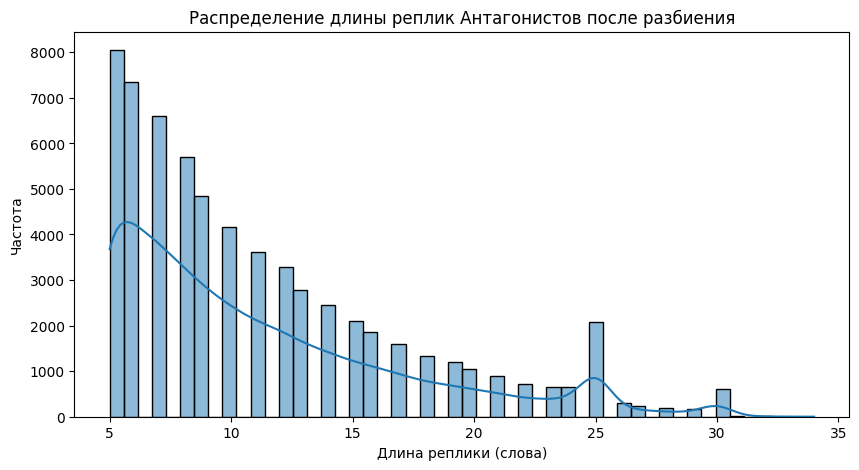

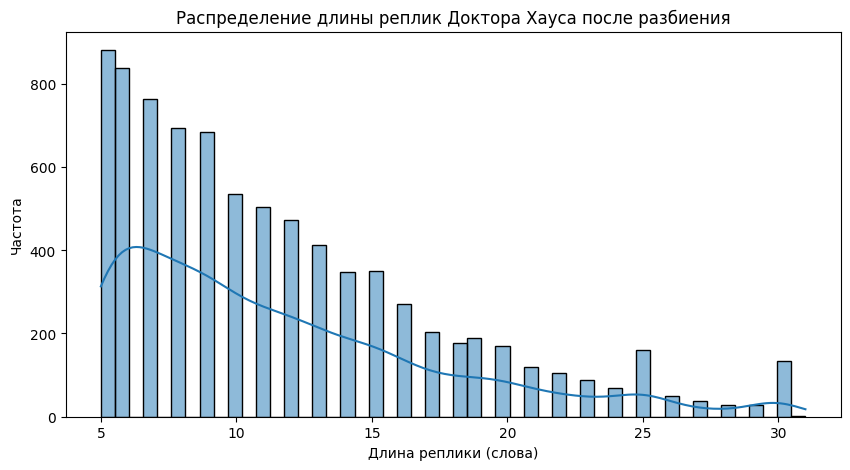

In [82]:
def plot_length_distribution(df, title):
    """
    –°—Ç—Ä–æ–∏—Ç —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –¥–ª–∏–Ω—ã —Ä–µ–ø–ª–∏–∫ –≤ —Å–∏–º–≤–æ–ª–∞—Ö.

    df: DataFrame —Å –∫–æ–ª–æ–Ω–∫–æ–π "line".
    title: –ó–∞–≥–æ–ª–æ–≤–æ–∫ –≥—Ä–∞—Ñ–∏–∫–∞.
    """
    lengths = df["line"].apply(lambda x: len(x.split()))  # –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å–ª–æ–≤ –≤ –∫–∞–∂–¥–æ–π —Ä–µ–ø–ª–∏–∫–µ

    plt.figure(figsize=(10, 5))
    sns.histplot(lengths, bins=50, kde=True)
    plt.xlabel("–î–ª–∏–Ω–∞ —Ä–µ–ø–ª–∏–∫–∏ (—Å–ª–æ–≤–∞)")
    plt.ylabel("–ß–∞—Å—Ç–æ—Ç–∞")
    plt.title(title)
    plt.show()

# –ü–æ—Å—Ç—Ä–æ–µ–Ω–∏–µ –≥—Ä–∞—Ñ–∏–∫–æ–≤
plot_length_distribution(antagonists_df, "–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –¥–ª–∏–Ω—ã —Ä–µ–ø–ª–∏–∫ –ê–Ω—Ç–∞–≥–æ–Ω–∏—Å—Ç–æ–≤ –ø–æ—Å–ª–µ —Ä–∞–∑–±–∏–µ–Ω–∏—è")
plot_length_distribution(house_df, "–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –¥–ª–∏–Ω—ã —Ä–µ–ø–ª–∏–∫ –î–æ–∫—Ç–æ—Ä–∞ –•–∞—É—Å–∞ –ø–æ—Å–ª–µ —Ä–∞–∑–±–∏–µ–Ω–∏—è")

In [83]:
# –ü—Ä–æ–≤–µ—Ä—è–µ–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—É—Å—Ç—ã—Ö –∏ NaN –∑–Ω–∞—á–µ–Ω–∏–π –≤ –∞–Ω–∫–æ—Ä–∞—Ö
num_empty_anchors = (house_df["anchor"] == "").sum()
num_nan_anchors = house_df["anchor"].isna().sum()

print(f"–ü—É—Å—Ç—ã—Ö –∞–Ω–∫–æ—Ä–æ–≤: {num_empty_anchors}")
print(f"NaN –∞–Ω–∫–æ—Ä–æ–≤: {num_nan_anchors}")

# –ï—Å–ª–∏ –µ—Å—Ç—å –ø—É—Å—Ç—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è, –≤—ã–≤–æ–¥–∏–º –ø—Ä–∏–º–µ—Ä—ã
if num_empty_anchors > 0 or num_nan_anchors > 0:
    print("\n–ü—Ä–∏–º–µ—Ä—ã –ø—É—Å—Ç—ã—Ö –∞–Ω–∫–æ—Ä–æ–≤:")
    print(house_df[house_df["anchor"].isna() | (house_df["anchor"] == "")].head())


–ü—É—Å—Ç—ã—Ö –∞–Ω–∫–æ—Ä–æ–≤: 1
NaN –∞–Ω–∫–æ—Ä–æ–≤: 0

–ü—Ä–∏–º–µ—Ä—ã –ø—É—Å—Ç—ã—Ö –∞–Ω–∫–æ—Ä–æ–≤:
       name  season previous_line previous_speaker  \
1924  house       2                 mandarin woman   

                                           context_long  is_greeting  \
1924  I can count to ten and ask to go to the bathro...        False   

      is_question  is_negation  is_exclamation  is_sarcasm  ...  \
1924        False        False           False        True  ...   

                                              context_2  \
1924  You speak Mandarin? Okay, Im going to leave yo...   

                                              context_3  \
1924  Her boobs are bigger. You speak Mandarin? Okay...   

                                              context_4  \
1924  Shes been taking the decongestants, but shes n...   

                                              context_5 is_self_question  \
1924  Shes been taking the decongestants, but shes n...            False   

   

In [85]:
def fill_last_empty_anchor(row, min_words=5, max_words=20):
    """
    –ó–∞–ø–æ–ª–Ω—è–µ—Ç –ø–æ—Å–ª–µ–¥–Ω–∏–π –ø—É—Å—Ç–æ–π –∞–Ω–∫–æ—Ä, –∏—Å–ø–æ–ª—å–∑—É—è context_1 -> context_2 -> context_3 –∏ —Ç.–¥.
    –ï—Å–ª–∏ –Ω–∏—á–µ–≥–æ –Ω–µ –Ω–∞–π–¥–µ–Ω–æ, —Å—Ç–∞–≤–∏–º "UNKNOWN".
    """
    context_columns = ["context_1", "context_2", "context_3", "context_4", "context_5"]

    for col in context_columns:
        context = row.get(col, "")
        if isinstance(context, str) and len(context.strip()) > 0:
            words = context.split()
            if min_words <= len(words) <= max_words:
                return context
            elif len(words) > max_words:
                return " ".join(words[:max_words])  # –ë–µ—Ä–µ–º –ø–µ—Ä–≤—ã–µ max_words —Å–ª–æ–≤

    return "UNKNOWN"  # –ï—Å–ª–∏ –≤–æ–æ–±—â–µ –Ω–µ—Ç –∫–æ–Ω—Ç–µ–∫—Å—Ç–∞

# –ó–∞–ø–æ–ª–Ω—è–µ–º –ø–æ—Å–ª–µ–¥–Ω–∏–π –ø—É—Å—Ç–æ–π –∞–Ω–∫–æ—Ä
house_df.loc[house_df["anchor"] == "", "anchor"] = house_df[house_df["anchor"] == ""].apply(fill_last_empty_anchor, axis=1)

# –ü—Ä–æ–≤–µ—Ä—è–µ–º, –æ—Å—Ç–∞–ª–∏—Å—å –ª–∏ –ø—É—Å—Ç—ã–µ –∞–Ω–∫–æ—Ä—ã
empty_anchor_count = (house_df["anchor"] == "").sum()
print(f"–û—Å—Ç–∞–ª–æ—Å—å –ø—É—Å—Ç—ã—Ö –∞–Ω–∫–æ—Ä–æ–≤: {empty_anchor_count}")


–û—Å—Ç–∞–ª–æ—Å—å –ø—É—Å—Ç—ã—Ö –∞–Ω–∫–æ—Ä–æ–≤: 0


In [86]:
# –ü—Ä–æ–≤–µ—Ä–∫–∞, —Å–æ–¥–µ—Ä–∂–∏—Ç—Å—è –ª–∏ –æ—Ç–≤–µ—Ç –≤ –∞–Ω–∫–æ—Ä–µ
house_df["answer_in_anchor"] = house_df.apply(lambda row: row["line"] in row["anchor"], axis=1)

# –ü–æ–¥—Å—á–µ—Ç –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ —Ç–∞–∫–∏—Ö —Å–ª—É—á–∞–µ–≤
num_issues = house_df["answer_in_anchor"].sum()
print(f"–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –∞–Ω–∫–æ—Ä–æ–≤, —Å–æ–¥–µ—Ä–∂–∞—â–∏—Ö –æ—Ç–≤–µ—Ç: {num_issues}")

# –ü—Ä–∏–º–µ—Ä—ã –ø—Ä–æ–±–ª–µ–º–Ω—ã—Ö —Å—Ç—Ä–æ–∫
if num_issues > 0:
    print("\n–ü—Ä–∏–º–µ—Ä—ã –∞–Ω–∫–æ—Ä–æ–≤, —Å–æ–¥–µ—Ä–∂–∞—â–∏—Ö –æ—Ç–≤–µ—Ç:")
    print(house_df[house_df["answer_in_anchor"]][["anchor", "line"]].head(5))

–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –∞–Ω–∫–æ—Ä–æ–≤, —Å–æ–¥–µ—Ä–∂–∞—â–∏—Ö –æ—Ç–≤–µ—Ç: 18

–ü—Ä–∏–º–µ—Ä—ã –∞–Ω–∫–æ—Ä–æ–≤, —Å–æ–¥–µ—Ä–∂–∞—â–∏—Ö –æ—Ç–≤–µ—Ç:
                                                 anchor  \
54    From what Ive read false paternity is more lik...   
754   Hes not gonna fire anybody. Its not about the ...   
986   What kind of snake? Oh, there are people to fi...   
1557  Ill be right back. So you had a fight, Im sure...   
1560  It was about nothing. You fought over mail del...   

                                                line  
54                        Fifty bucks says Im right.  
754                         Its not about the money.  
986   Oh, there are people to find those things out.  
1557     So you had a fight, Im sure itll blow over.  
1560                   You fought over mail delivery  


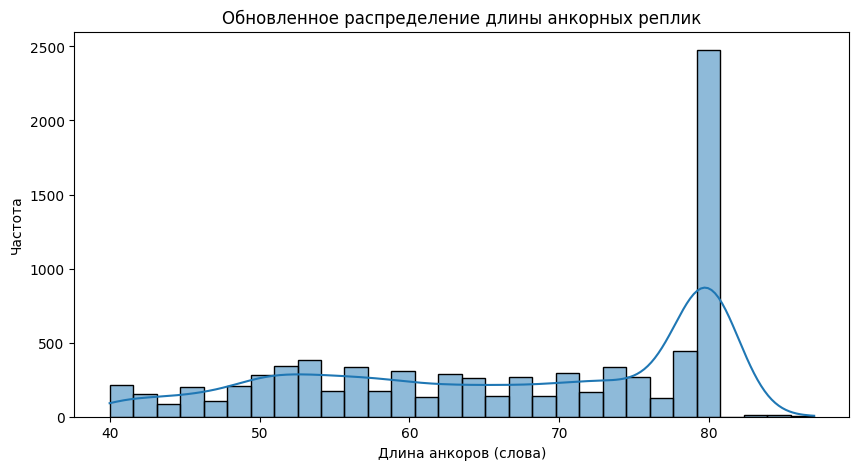

In [22]:
def fix_short_anchors(row, min_length=40):
    """–î–æ–±–∞–≤–ª—è–µ—Ç –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—ã–π –∫–æ–Ω—Ç–µ–∫—Å—Ç –∫ —Å–ª–∏—à–∫–æ–º –∫–æ—Ä–æ—Ç–∫–∏–º –∞–Ω–∫–æ—Ä–∞–º."""
    anchor = row["anchor"]
    context_columns = ["context_1", "context_2", "context_3", "context_4", "context_5"]

    # –ï—Å–ª–∏ –∞–Ω–∫–æ—Ä —Å–ª–∏—à–∫–æ–º –∫–æ—Ä–æ—Ç–∫–∏–π, –¥–æ–±–∞–≤–ª—è–µ–º –∫–æ–Ω—Ç–µ–∫—Å—Ç
    if count_words(anchor) < min_length:
        for col in context_columns:
            if pd.notna(row[col]) and count_words(row[col]) > 5:  # –ë–µ—Ä–µ–º —Ç–æ–ª—å–∫–æ –æ—Å–º—ã—Å–ª–µ–Ω–Ω—ã–π –∫–æ–Ω—Ç–µ–∫—Å—Ç
                anchor = anchor + " " + row[col]
                if count_words(anchor) >= min_length:
                    break

    return anchor.strip()

# –ü—Ä–∏–º–µ–Ω—è–µ–º –∏—Å–ø—Ä–∞–≤–ª–µ–Ω–∏–µ –∫ —Å–ª–∏—à–∫–æ–º –∫–æ—Ä–æ—Ç–∫–∏–º –∞–Ω–∫–æ—Ä–∞–º
house_df["anchor"] = house_df.apply(fix_short_anchors, axis=1)

# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –æ–±–Ω–æ–≤–ª–µ–Ω–Ω–æ–≥–æ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è
plt.figure(figsize=(10, 5))
sns.histplot(house_df["anchor"].dropna().apply(count_words), bins=30, kde=True)
plt.xlabel("–î–ª–∏–Ω–∞ –∞–Ω–∫–æ—Ä–æ–≤ (—Å–ª–æ–≤–∞)")
plt.ylabel("–ß–∞—Å—Ç–æ—Ç–∞")
plt.title("–û–±–Ω–æ–≤–ª–µ–Ω–Ω–æ–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –¥–ª–∏–Ω—ã –∞–Ω–∫–æ—Ä–Ω—ã—Ö —Ä–µ–ø–ª–∏–∫")
plt.show()


In [97]:
from sentence_transformers import SentenceTransformer, util
import torch

# –ó–∞–≥—Ä—É–∂–∞–µ–º –º–æ–¥–µ–ª—å –∏ –æ—Ç–ø—Ä–∞–≤–ª—è–µ–º –µ–µ –Ω–∞ GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
# model = SentenceTransformer("all-MiniLM-L6-v2").to(device)
model = SentenceTransformer("all-mpnet-base-v2").to(device)


# –í–µ–∫—Ç–æ—Ä–∏–∑–∞—Ü–∏—è –∞–Ω–∫–æ—Ä–æ–≤ –∏ –Ω–µ–≥–∞—Ç–∏–≤–Ω—ã—Ö –ø—Ä–∏–º–µ—Ä–æ–≤
anchor_embeddings = model.encode(house_df["anchor"].tolist(), convert_to_tensor=True, device=device)
antagonist_embeddings = model.encode(antagonists_df["line"].tolist(), convert_to_tensor=True, device=device)

# –í—ã—á–∏—Å–ª–µ–Ω–∏–µ –∫–æ—Å–∏–Ω—É—Å–Ω–æ–≥–æ —Å—Ö–æ–¥—Å—Ç–≤–∞
similarities = util.pytorch_cos_sim(anchor_embeddings, antagonist_embeddings).cpu().numpy()

In [98]:
import numpy as np

threshold_lower = 0.05  # –û—Å–ª–∞–±–ª—è–µ–º –Ω–∏–∂–Ω–∏–π –ø–æ—Ä–æ–≥
threshold_upper = 0.2   # –£–º–µ–Ω—å—à–∞–µ–º –≤–µ—Ä—Ö–Ω–∏–π –ø–æ—Ä–æ–≥
top_k = 50  # –†–∞—Å—à–∏—Ä—è–µ–º –≤—ã–±–æ—Ä–∫—É –¥–ª—è –Ω–µ–≥–∞—Ç–∏–≤–Ω—ã—Ö –ø—Ä–∏–º–µ—Ä–æ–≤

# –ü—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ DataFrame –≤ –º–∞—Å—Å–∏–≤—ã
antagonist_lines = antagonists_df["line"].values
similarities_np = np.array(similarities)

# –°–æ–∑–¥–∞–Ω–∏–µ —Å–ø–∏—Å–∫–∞ –¥–ª—è –Ω–µ–≥–∞—Ç–∏–≤–Ω—ã—Ö –ø—Ä–∏–º–µ—Ä–æ–≤
new_hard_negatives = np.full(len(house_df), "", dtype=object)

for i in range(similarities_np.shape[0]):
    sorted_idx = np.argsort(similarities_np[i])[::-1]  # –°–æ—Ä—Ç–∏—Ä–æ–≤–∫–∞ –ø–æ —É–±—ã–≤–∞–Ω–∏—é
    candidates = sorted_idx[
        (similarities_np[i][sorted_idx] > threshold_lower) &
        (similarities_np[i][sorted_idx] < threshold_upper)
    ]  # –§–∏–ª—å—Ç—Ä–∞—Ü–∏—è —Å–ª–∏—à–∫–æ–º –ª–µ–≥–∫–∏—Ö –∏ —Å–ª–∏—à–∫–æ–º –ø–æ—Ö–æ–∂–∏—Ö –ø—Ä–∏–º–µ—Ä–æ–≤

    if len(candidates) > 5:
        neg_idx = np.random.choice(candidates[:top_k])  # –í—ã–±–∏—Ä–∞–µ–º —Å–ª—É—á–∞–π–Ω—ã–π –∏–∑ top-k
        new_hard_negatives[i] = antagonist_lines[neg_idx]

# –î–æ–±–∞–≤–ª—è–µ–º –≤ house_df –∫–æ–ª–æ–Ω–∫—É —Å –Ω–µ–≥–∞—Ç–∏–≤–Ω—ã–º–∏ –æ—Ç–≤–µ—Ç–∞–º–∏
house_df["neg_answer"] = new_hard_negatives
print(f"–û–±–Ω–æ–≤–ª–µ–Ω–æ {len(new_hard_negatives)} –Ω–µ–≥–∞—Ç–∏–≤–Ω—ã—Ö –ø—Ä–∏–º–µ—Ä–æ–≤.")

# === –¢–µ–ø–µ—Ä—å —Å–æ–∑–¥–∞–µ–º —Ç—Ä–∏–ø–ª–µ—Ç—ã ===
triplets_df = house_df[["anchor", "line", "neg_answer"]].copy()
triplets_df.columns = ["anchor", "response", "neg_response"]  # –ü–µ—Ä–µ–∏–º–µ–Ω–æ–≤—ã–≤–∞–µ–º –¥–ª—è –µ–¥–∏–Ω–æ–æ–±—Ä–∞–∑–∏—è

print(f"–°–æ–∑–¥–∞–Ω–æ {len(triplets_df)} —Ç—Ä–∏–ø–ª–µ—Ç–æ–≤.")

# –ü—Ä–æ–≤–µ—Ä–∫–∞ –Ω–∞ NaN
assert triplets_df.isna().sum().sum() == 0, "–ï—Å—Ç—å NaN –≤ —Ç—Ä–∏–ø–ª–µ—Ç–∞—Ö!"


–û–±–Ω–æ–≤–ª–µ–Ω–æ 8316 –Ω–µ–≥–∞—Ç–∏–≤–Ω—ã—Ö –ø—Ä–∏–º–µ—Ä–æ–≤.
–°–æ–∑–¥–∞–Ω–æ 8316 —Ç—Ä–∏–ø–ª–µ—Ç–æ–≤.


In [106]:
import os
import pickle
from google.colab import files

# –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –¥–∏—Ä–µ–∫—Ç–æ—Ä–∏–π –¥–ª—è —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏—è —Ñ–∞–π–ª–æ–≤
output_dir = "/content/data"
os.makedirs(output_dir, exist_ok=True)

# –ü—É—Ç–∏ –¥–ª—è —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏—è —Ñ–∞–π–ª–æ–≤
house_final_path = os.path.join(output_dir, "house_final_cleaned.csv")
antagonists_final_path = os.path.join(output_dir, "antagonists_final_cleaned.csv")
triplets_path = os.path.join(output_dir, "house_triplets.pkl")

# –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –æ–±–Ω–æ–≤–ª—ë–Ω–Ω—ã—Ö –¥–∞—Ç–∞—Å–µ—Ç–æ–≤
house_df.to_csv(house_final_path, index=False)
antagonists_df.to_csv(antagonists_final_path, index=False)

# –ü—Ä–æ–≤–µ—Ä—è–µ–º, —á—Ç–æ –≤ —Ç—Ä–∏–ø–ª–µ—Ç–∞—Ö –Ω–µ—Ç NaN –ø–µ—Ä–µ–¥ —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ–º
assert triplets_df.isna().sum().sum() == 0, "–û—à–∏–±–∫–∞: –í —Ç—Ä–∏–ø–ª–µ—Ç–∞—Ö –µ—Å—Ç—å NaN!"

# –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ —Ç—Ä–∏–ø–ª–µ—Ç–æ–≤ –≤ pickle-—Ñ–æ—Ä–º–∞—Ç–µ
with open(triplets_path, "wb") as f:
    pickle.dump(triplets_df, f)

print(f"–§–∏–Ω–∞–ª—å–Ω—ã–π –¥–∞—Ç–∞—Å–µ—Ç –î–æ–∫—Ç–æ—Ä–∞ –•–∞—É—Å–∞ —Å–æ—Ö—Ä–∞–Ω—ë–Ω: {house_final_path}")
print(f"–§–∏–Ω–∞–ª—å–Ω—ã–π –¥–∞—Ç–∞—Å–µ—Ç –∞–Ω—Ç–∞–≥–æ–Ω–∏—Å—Ç–æ–≤ —Å–æ—Ö—Ä–∞–Ω—ë–Ω: {antagonists_final_path}")
print(f"–¢—Ä–∏–ø–ª–µ—Ç—ã —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã –≤: {triplets_path}")

# –ê–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–∞—è –∑–∞–≥—Ä—É–∑–∫–∞ —Ñ–∞–π–ª–æ–≤ –¥–ª—è —Å–∫–∞—á–∏–≤–∞–Ω–∏—è
files.download(house_final_path)
files.download(antagonists_final_path)
files.download(triplets_path)


–§–∏–Ω–∞–ª—å–Ω—ã–π –¥–∞—Ç–∞—Å–µ—Ç –î–æ–∫—Ç–æ—Ä–∞ –•–∞—É—Å–∞ —Å–æ—Ö—Ä–∞–Ω—ë–Ω: /content/data/house_final_cleaned.csv
–§–∏–Ω–∞–ª—å–Ω—ã–π –¥–∞—Ç–∞—Å–µ—Ç –∞–Ω—Ç–∞–≥–æ–Ω–∏—Å—Ç–æ–≤ —Å–æ—Ö—Ä–∞–Ω—ë–Ω: /content/data/antagonists_final_cleaned.csv
–¢—Ä–∏–ø–ª–µ—Ç—ã —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã –≤: /content/data/house_triplets.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

–ü—Ä–∏–º–µ—Ä –∑–∞–≥—Ä—É–∂–µ–Ω–Ω—ã—Ö —Ç—Ä–∏–ø–ª–µ—Ç–æ–≤:
                                              anchor  \
0    And shes not responding to radiation treatment.   
1                        Your cousin goes to an HMO?   
2  Youve got three overqualified doctors working ...   
3                                   Is she a doctor?   
4                                                Dr.   

                                            response neg_response  
0                                    Is she a doctor               
1                                    Is she a doctor               
2                                    Is she a doctor               
3  No, treating illnesses is why we became doctor...               
4  No, treating illnesses is why we became doctor...               


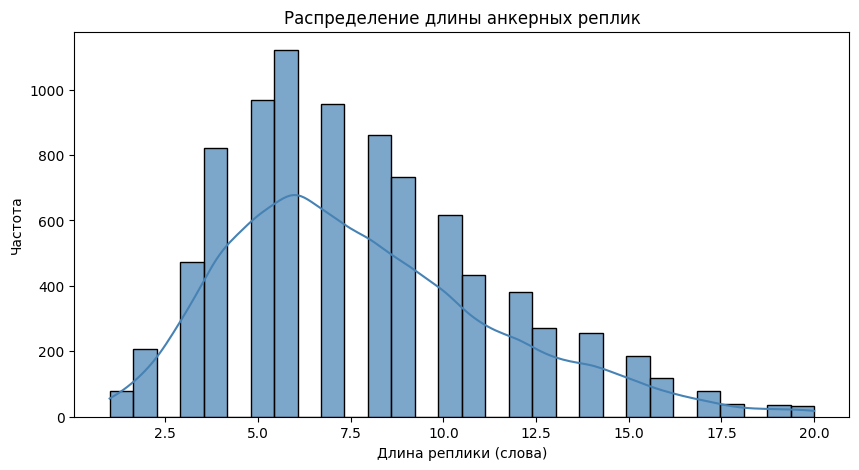

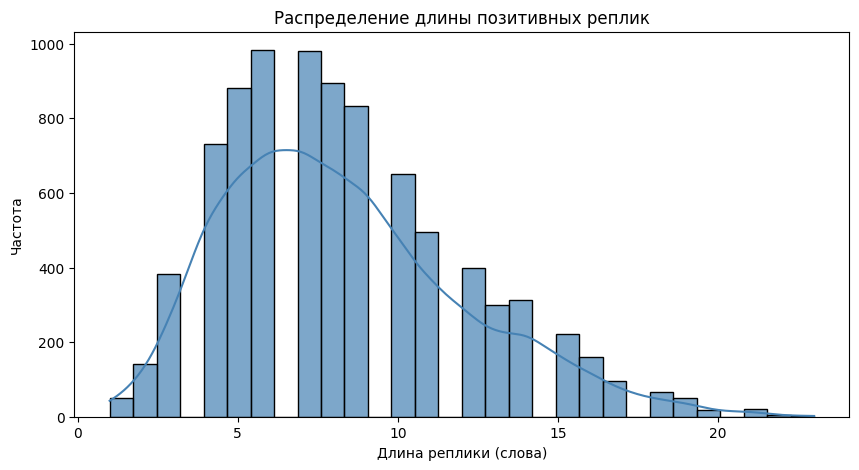

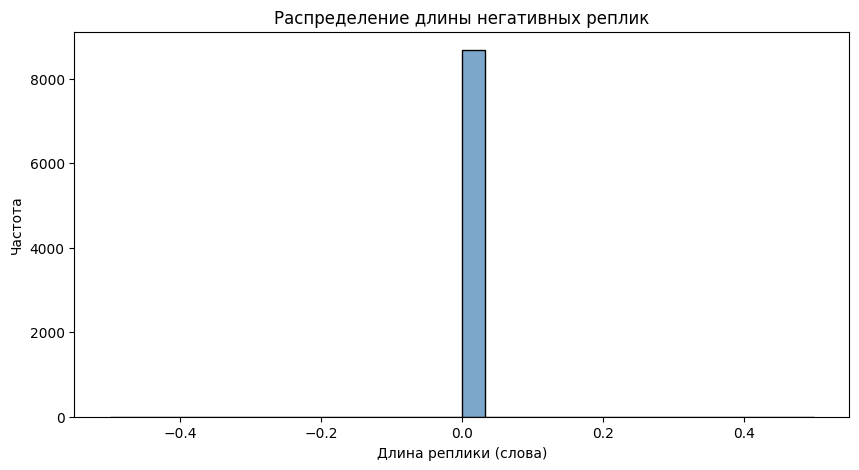

In [107]:
# –ü—É—Ç–∏ –∫ —Å–æ—Ö—Ä–∞–Ω–µ–Ω–Ω—ã–º –¥–∞–Ω–Ω—ã–º
triplets_path = "/content/data/house_triplets.pkl"

# –ó–∞–≥—Ä—É–∑–∫–∞ —Ç—Ä–∏–ø–ª–µ—Ç–æ–≤
with open(triplets_path, "rb") as f:
    triplets_df = pickle.load(f)

# –ü—Ä–æ–≤–µ—Ä–∫–∞ —Å—Ç—Ä—É–∫—Ç—É—Ä—ã –∑–∞–≥—Ä—É–∂–µ–Ω–Ω–æ–≥–æ –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–∞
print("–ü—Ä–∏–º–µ—Ä –∑–∞–≥—Ä—É–∂–µ–Ω–Ω—ã—Ö —Ç—Ä–∏–ø–ª–µ—Ç–æ–≤:")
print(triplets_df.head())

# –§—É–Ω–∫—Ü–∏—è –¥–ª—è –ø–æ—Å—Ç—Ä–æ–µ–Ω–∏—è —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –¥–ª–∏–Ω—ã —Ä–µ–ø–ª–∏–∫
def plot_length_distribution(df, column_name, title):
    lengths = df[column_name].str.split().str.len()

    plt.figure(figsize=(10, 5))
    sns.histplot(lengths, bins=30, kde=True, color="steelblue", alpha=0.7)
    plt.xlabel("–î–ª–∏–Ω–∞ —Ä–µ–ø–ª–∏–∫–∏ (—Å–ª–æ–≤–∞)")
    plt.ylabel("–ß–∞—Å—Ç–æ—Ç–∞")
    plt.title(title)
    plt.show()

# –ü–æ—Å—Ç—Ä–æ–µ–Ω–∏–µ –≥—Ä–∞—Ñ–∏–∫–æ–≤
plot_length_distribution(triplets_df, "anchor", "–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –¥–ª–∏–Ω—ã –∞–Ω–∫–µ—Ä–Ω—ã—Ö —Ä–µ–ø–ª–∏–∫")
plot_length_distribution(triplets_df, "response", "–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –¥–ª–∏–Ω—ã –ø–æ–∑–∏—Ç–∏–≤–Ω—ã—Ö —Ä–µ–ø–ª–∏–∫")
plot_length_distribution(triplets_df, "neg_response", "–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –¥–ª–∏–Ω—ã –Ω–µ–≥–∞—Ç–∏–≤–Ω—ã—Ö —Ä–µ–ø–ª–∏–∫")

In [101]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# –í–µ–∫—Ç–æ—Ä–∏–∑–∞—Ü–∏—è –∞–Ω–∫–æ—Ä–Ω—ã—Ö —Ä–µ–ø–ª–∏–∫, –ø–æ–∑–∏—Ç–∏–≤–Ω—ã—Ö –∏ –Ω–µ–≥–∞—Ç–∏–≤–Ω—ã—Ö –æ—Ç–≤–µ—Ç–æ–≤
print("–í–µ–∫—Ç–æ—Ä–∏–∑–∞—Ü–∏—è –∞–Ω–∫–æ—Ä–Ω—ã—Ö —Ä–µ–ø–ª–∏–∫ –∏ –æ—Ç–≤–µ—Ç–æ–≤...")
anchor_vectors = model.encode(triplets_df["anchor"].tolist(), convert_to_numpy=True)
response_vectors = model.encode(triplets_df["response"].tolist(), convert_to_numpy=True)
negative_vectors = model.encode(triplets_df["neg_response"].tolist(), convert_to_numpy=True)

# –í—ã—á–∏—Å–ª–µ–Ω–∏–µ –∫–æ—Å–∏–Ω—É—Å–Ω–æ–≥–æ —Å—Ö–æ–¥—Å—Ç–≤–∞ –∞–Ω–∫–æ—Ä–Ω—ã—Ö —Ä–µ–ø–ª–∏–∫ —Å –ø–æ–∑–∏—Ç–∏–≤–Ω—ã–º–∏ –æ—Ç–≤–µ—Ç–∞–º–∏
similarity_scores = cosine_similarity(anchor_vectors, response_vectors)
avg_similarity = np.mean(similarity_scores.diagonal())

# –í—ã—á–∏—Å–ª–µ–Ω–∏–µ –∫–æ—Å–∏–Ω—É—Å–Ω–æ–≥–æ —Å—Ö–æ–¥—Å—Ç–≤–∞ –∞–Ω–∫–æ—Ä–Ω—ã—Ö —Ä–µ–ø–ª–∏–∫ —Å –Ω–µ–≥–∞—Ç–∏–≤–Ω—ã–º–∏ –æ—Ç–≤–µ—Ç–∞–º–∏
neg_similarity_scores = cosine_similarity(anchor_vectors, negative_vectors)
avg_neg_similarity = np.mean(neg_similarity_scores.diagonal())

# –í—ã–≤–æ–¥ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
print(f"–°—Ä–µ–¥–Ω–µ–µ –∫–æ—Å–∏–Ω—É—Å–Ω–æ–µ —Å—Ö–æ–¥—Å—Ç–≤–æ –∞–Ω–∫–æ—Ä–Ω—ã—Ö —Ä–µ–ø–ª–∏–∫ –∏ –ø–æ–∑–∏—Ç–∏–≤–Ω—ã—Ö –æ—Ç–≤–µ—Ç–æ–≤: {avg_similarity:.4f}")
print(f"–°—Ä–µ–¥–Ω–µ–µ –∫–æ—Å–∏–Ω—É—Å–Ω–æ–µ —Å—Ö–æ–¥—Å—Ç–≤–æ –∞–Ω–∫–æ—Ä–Ω—ã—Ö —Ä–µ–ø–ª–∏–∫ –∏ –Ω–µ–≥–∞—Ç–∏–≤–Ω—ã—Ö –æ—Ç–≤–µ—Ç–æ–≤: {avg_neg_similarity:.4f}")

–í–µ–∫—Ç–æ—Ä–∏–∑–∞—Ü–∏—è –∞–Ω–∫–æ—Ä–Ω—ã—Ö —Ä–µ–ø–ª–∏–∫ –∏ –æ—Ç–≤–µ—Ç–æ–≤...
–°—Ä–µ–¥–Ω–µ–µ –∫–æ—Å–∏–Ω—É—Å–Ω–æ–µ —Å—Ö–æ–¥—Å—Ç–≤–æ –∞–Ω–∫–æ—Ä–Ω—ã—Ö —Ä–µ–ø–ª–∏–∫ –∏ –ø–æ–∑–∏—Ç–∏–≤–Ω—ã—Ö –æ—Ç–≤–µ—Ç–æ–≤: 0.2024
–°—Ä–µ–¥–Ω–µ–µ –∫–æ—Å–∏–Ω—É—Å–Ω–æ–µ —Å—Ö–æ–¥—Å—Ç–≤–æ –∞–Ω–∫–æ—Ä–Ω—ã—Ö —Ä–µ–ø–ª–∏–∫ –∏ –Ω–µ–≥–∞—Ç–∏–≤–Ω—ã—Ö –æ—Ç–≤–µ—Ç–æ–≤: 0.1996


In [102]:
import pickle
import os

# –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –¥–∏—Ä–µ–∫—Ç–æ—Ä–∏–π –¥–ª—è —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏—è
vector_output_dir = "/content/data/vectors"
os.makedirs(vector_output_dir, exist_ok=True)

# –ü—É—Ç–∏ –¥–ª—è —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏—è –≤–µ–∫—Ç–æ—Ä–æ–≤
anchor_vectors_path = os.path.join(vector_output_dir, "anchor_vectors.pkl")
response_vectors_path = os.path.join(vector_output_dir, "response_vectors.pkl")
negative_vectors_path = os.path.join(vector_output_dir, "negative_vectors.pkl")

# –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –≤–µ–∫—Ç–æ—Ä–æ–≤ –≤ —Ñ–∞–π–ª—ã
with open(anchor_vectors_path, "wb") as f:
    pickle.dump(anchor_vectors, f)

with open(response_vectors_path, "wb") as f:
    pickle.dump(response_vectors, f)

with open(negative_vectors_path, "wb") as f:
    pickle.dump(negative_vectors, f)

print(f"–í–µ–∫—Ç–æ—Ä—ã –∞–Ω–∫–æ—Ä–Ω—ã—Ö —Ä–µ–ø–ª–∏–∫ —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã –≤: {anchor_vectors_path}")
print(f"–í–µ–∫—Ç–æ—Ä—ã –ø–æ–∑–∏—Ç–∏–≤–Ω—ã—Ö –æ—Ç–≤–µ—Ç–æ–≤ —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã –≤: {response_vectors_path}")
print(f"–í–µ–∫—Ç–æ—Ä—ã –Ω–µ–≥–∞—Ç–∏–≤–Ω—ã—Ö –æ—Ç–≤–µ—Ç–æ–≤ —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã –≤: {negative_vectors_path}")

–í–µ–∫—Ç–æ—Ä—ã –∞–Ω–∫–æ—Ä–Ω—ã—Ö —Ä–µ–ø–ª–∏–∫ —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã –≤: /content/data/vectors/anchor_vectors.pkl
–í–µ–∫—Ç–æ—Ä—ã –ø–æ–∑–∏—Ç–∏–≤–Ω—ã—Ö –æ—Ç–≤–µ—Ç–æ–≤ —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã –≤: /content/data/vectors/response_vectors.pkl
–í–µ–∫—Ç–æ—Ä—ã –Ω–µ–≥–∞—Ç–∏–≤–Ω—ã—Ö –æ—Ç–≤–µ—Ç–æ–≤ —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã –≤: /content/data/vectors/negative_vectors.pkl
